In [1]:
import os
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/homes/gws/chanwkim/vit-shapley/notebooks
/homes/gws/chanwkim/vit-shapley


In [2]:
import pickle

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

import matplotlib.gridspec as gridspec

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as ticker
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import wandb
api = wandb.Api()
from cycler import cycler

import cv2

# https://github.com/dsc/colorbrewer-python/blob/master/colorbrewer.py

Set1 = {
    3: [[228,26,28], [55,126,184], [77,175,74]],
    4: [[228,26,28], [55,126,184], [77,175,74], [152,78,163]],
    5: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0]],
    6: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0], [255,255,51]],
    7: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0], [255,255,51], [166,86,40]],
    8: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0], [255,255,51], [166,86,40], [247,129,191]],
    9: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0], [255,255,51], [166,86,40], [247,129,191], [153,153,153]],
}

Paired = {
    3: [(166,206,227), [31,120,180], [178,223,138]],
    4: [[166,206,227], [31,120,180], [178,223,138], [51,160,44]],
    5: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153]],
    6: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28]],
    7: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111]],
    8: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0]],
    9: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0], [202,178,214]],
    10: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0], [202,178,214], [106,61,154]],
    11: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0], [202,178,214], [106,61,154], [255,255,153]],
    12: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0], [202,178,214], [106,61,154], [255,255,153], [177,89,40]]
}

plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor']='1.0'
plt.rcParams['legend.framealpha']=0

fig_temp = plt.figure()
ax_temp=fig_temp.add_subplot()
plt.clf()

<Figure size 432x288 with 0 Axes>

In [3]:
backbone_type_config_dict={'vit_base_patch16_224':[],
                           'vit_small_patch16_224':[],
                           'vit_tiny_patch16_224':[],
                           'vit_large_patch16_224':[],
                          }

# Read alll data

In [4]:
def get_retraining_status(backbone_type, dataset_name, api_dir="ch6845/transformer_interpretability_project_retraining"):
    api.flush()
    runs = api.runs(api_dir)
    result_dict_list=[]
    for run in runs:
        print(run.config["datasets"], run.config["backbone_type"])
        try:
            print(run.name)
            if run.config["datasets"]!=dataset_name:
                print(run.name, "pass")
                continue
            if run.config["backbone_type"]!=backbone_type:
                print(run.name, "pass")
                continue
            #print(run.config)
            result_dict_list.append({"name": run.name,
                                     "accuracy": run.summary["test/accuracy"] if "test/accuracy" in run.summary.keys() else np.nan,
                                     "cohenkappa": run.summary["test/cohenkappa"] if "test/cohenkappa" in run.summary.keys() else np.nan,
                                     "backbone_type": run.config["classifier_backbone_type"],
                                     "datasets": run.config["datasets"],
                                     "classifier_enable_pos_embed": run.config["classifier_enable_pos_embed"] if "classifier_enable_pos_embed" in run.config else True,

                                     "explanation_location_train": run.config["explanation_location_train"],
                                     "explanation_mask_amount_train": run.config["explanation_mask_amount_train"],
                                     "explanation_mask_ascending_train": run.config["explanation_mask_ascending_train"],

                                     "explanation_location_val": run.config["explanation_location_val"],
                                     "explanation_mask_amount_val": run.config["explanation_mask_amount_val"],
                                     "explanation_mask_ascending_val": run.config["explanation_mask_ascending_val"],

                                     "explanation_location_test": run.config["explanation_location_test"],
                                     "explanation_mask_amount_test": run.config["explanation_mask_amount_test"],
                                     "explanation_mask_ascending_test": run.config["explanation_mask_ascending_test"]

                                    })
        except:
            print(run.name, 'error')

        #print('\n')
    result_df=pd.DataFrame(result_dict_list)
    #result_df=result_df[(result_df["backbone_type"]==backbone_type) & (result_df["datasets"]==dataset_name)]
    return result_df

In [5]:
# get_retraining_status(backbone_type=backbone_type, 
#                       dataset_name=dataset_name,
#                       api_dir="ch6845/transformer_interpretability_project_retraining")

In [6]:
data_loaded_all={}

for evaluation_stage in ["1_classifier_evaluate",
                         "2_surrogate_evaluate",
                         "3_explanation_generate",
                         "4_insert_delete",
                         "5_sensitivity",
                         "6_noretraining",
                         "7_classifiermasked",
                         "8_elapsedtime",
                         "9_estimationerror",
                         "9_retraining",
                         "10_retrainingnopos"
                        ]:
    data_loaded_all.setdefault(evaluation_stage,{})
    
    for dataset_name in ["ImageNette", "MURA", "Pet"]:
        print(evaluation_stage, dataset_name, end=" -- ")
        
        data_loaded_all[evaluation_stage].setdefault(dataset_name,{})        
        
        for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
            data_loaded_all[evaluation_stage][dataset_name].setdefault(backbone_type, {})
            
            if evaluation_stage=="1_classifier_evaluate":                       
                classifier_result_list_path=f'results/1_classifier_evaluate/{dataset_name}/{backbone_type}_test.pickle'
                
                if os.path.isfile(classifier_result_list_path):
                    with open(classifier_result_list_path, "rb") as f:
                        classifier_result_list=pickle.load(f)
                else:
                    classifier_result_list={}
                print(backbone_type, len(classifier_result_list))
                data_loaded_all[evaluation_stage][dataset_name][backbone_type]=classifier_result_list
                print(' ')
            elif evaluation_stage=="2_surrogate_evaluate":
                surrogate_result_path=f'results/2_surrogate_evaluate/{dataset_name}/{backbone_type}_test.csv'
                if os.path.isfile(surrogate_result_path):
                    surrogate_result=pd.read_csv(surrogate_result_path)
                else:
                    surrogate_result=[]
                print(backbone_type, len(surrogate_result))
                data_loaded_all[evaluation_stage][dataset_name][backbone_type]=surrogate_result
                print(' ')  
                    
        if evaluation_stage=="3_explanation_generate":
            print(' ')
            explanation_save_dict={}
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                explanation_save_dict_backbone={"attention_rollout":{},
                                                "attention_last":{},
                                                "LRP":{},
                                                "gradcam":{},
                                                "gradcamgithub": {},
                                                "vanillapixel": {},
                                                "vanillaembedding": {},
                                                "sgpixel": {},
                                                "sgembedding": {},
                                                "vargradpixel": {},
                                                "vargradembedding": {},               
                                                "igpixel": {},
                                                "igembedding": {},
                                                "leaveoneoutclassifier": {},
                                                "leaveoneoutsurrogate": {},
                                                "riseclassifier": {},
                                                "risesurrogate": {},
                                                "ours": {},
                                                "kernelshap": {}
                                                }
                explanation_save_dict[backbone_type]=explanation_save_dict_backbone            
            
            
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                print(backbone_type,'\n')
                for explanation_method, explanation_save_dict_backbone_method in explanation_save_dict[backbone_type].items():
                    explanation_save_dict_path=f'results/3_explanation_generate/{dataset_name}/{backbone_type}_{explanation_method}_test.pickle'

                    if os.path.isfile(explanation_save_dict_path):
                        with open(explanation_save_dict_path, 'rb') as f:
                            explanation_save_dict_loaded=pickle.load(f)
                    else:
                        explanation_save_dict_loaded={}

                    len_original=len(explanation_save_dict_backbone_method)            
                    len_loaded=len(explanation_save_dict_loaded)
                    explanation_save_dict_backbone_method.update(explanation_save_dict_loaded)
                    len_updated=len(explanation_save_dict_backbone_method)                    
                    len_unique=len(set([i.replace('l0','').replace('l1lambda','').replace('l2lambda','').replace('l3','').replace('deeper','') for i in explanation_save_dict_backbone_method.keys()]))

                    print(f'{explanation_method:24}  {len_original:6}   + {len_loaded:6}   -> {len_updated:6} unique: {len_unique:6}')                                
            data_loaded_all[evaluation_stage][dataset_name]=explanation_save_dict
            print(' ')    
            
        if evaluation_stage=="4_insert_delete":
            print(' ')
            insertdelete_save_dict={}
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                insertdelete_save_dict_backbone={"random":{},
                                                 "attention_rollout":{},
                                                 "attention_last":{},
                                                 "LRP":{},
                                                 "gradcam":{},
                                                 "gradcamgithub": {},
                                                 "vanillapixel": {},
                                                 "vanillaembedding": {},
                                                 "sgpixel": {},
                                                 "sgembedding": {},
                                                 "vargradpixel": {},
                                                 "vargradembedding": {},               
                                                 "igpixel": {},
                                                 "igembedding": {},
                                                 "leaveoneoutclassifier": {},
                                                 "leaveoneoutsurrogate": {},
                                                 "riseclassifier": {},
                                                 "risesurrogate": {},
                                                 "ours": {},
                                                 "kernelshap": {}
                                                }
                insertdelete_save_dict[backbone_type]=insertdelete_save_dict_backbone     
            
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                print(backbone_type,'\n')
                for explanation_method, insertdelete_save_dict_backbone_method in insertdelete_save_dict[backbone_type].items():
                    insertdelete_save_dict_path=f'results/4_insert_delete/{dataset_name}/{backbone_type}_{explanation_method}_test.pickle'

                    if os.path.isfile(insertdelete_save_dict_path):
                        with open(insertdelete_save_dict_path, 'rb') as f:
                            insertdelete_save_dict_loaded=pickle.load(f)
                    else:
                        insertdelete_save_dict_loaded={}

                    len_original=len(insertdelete_save_dict_backbone_method)            
                    len_loaded=len(insertdelete_save_dict_loaded)
                    insertdelete_save_dict_backbone_method.update(insertdelete_save_dict_loaded)
                    len_updated=len(insertdelete_save_dict_backbone_method)
                    len_unique=len(set([i.replace('l0','').replace('l1lambda','').replace('l2lambda','').replace('l3','').replace('deeper','') for i in insertdelete_save_dict_backbone_method.keys()]))

                    print(f'{explanation_method:24}  {len_original:6}   + {len_loaded:6}   -> {len_updated:6} unique: {len_unique:6}')                    
            data_loaded_all[evaluation_stage][dataset_name]=insertdelete_save_dict
            print(' ')
            
        if evaluation_stage=="5_sensitivity":
            print(' ')
            sensitivity_save_dit={}
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                print(backbone_type,'\n')
                sensitivity_save_dit_backbone={"attention_rollout":{},
                                               "attention_last":{},
                                               "LRP":{},
                                               "gradcam":{},
                                               "gradcamgithub": {},
                                               "vanillapixel": {},
                                               "vanillaembedding": {},
                                               "sgpixel": {},
                                               "sgembedding": {},
                                               "vargradpixel": {},
                                               "vargradembedding": {},               
                                               "igpixel": {},
                                               "igembedding": {},
                                               "leaveoneoutclassifier": {},
                                               "leaveoneoutsurrogate": {},
                                               "riseclassifier": {},
                                               "risesurrogate": {},
                                               "ours": {},
                                               }
                sensitivity_save_dit[backbone_type]=sensitivity_save_dit_backbone       
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                print(backbone_type,'\n')
                for explanation_method, sensitivity_save_dit_backbone_method in sensitivity_save_dit[backbone_type].items():
                    sensitivity_save_dit_path=f'results/5_sensitivity/{dataset_name}/{backbone_type}_{explanation_method}_test.pickle'

                    if os.path.isfile(sensitivity_save_dit_path):
                        with open(sensitivity_save_dit_path, 'rb') as f:
                            sensitivity_save_dit_loaded=pickle.load(f)
                    else:
                        sensitivity_save_dit_loaded={}

                    len_original=len(sensitivity_save_dit_backbone_method)            
                    len_loaded=len(sensitivity_save_dit_loaded)
                    sensitivity_save_dit_backbone_method.update(sensitivity_save_dit_loaded)
                    len_updated=len(sensitivity_save_dit_backbone_method)
                    len_unique=len(set([i.replace('l0','').replace('l1lambda','').replace('l2lambda','').replace('l3','').replace('deeper','') for i in sensitivity_save_dit_backbone_method.keys()]))

                    print(f'{explanation_method:24}  {len_original:6}   + {len_loaded:6}   -> {len_updated:6} unique: {len_unique:6}')            
            data_loaded_all[evaluation_stage][dataset_name]=sensitivity_save_dit
            print(' ')
            
        if evaluation_stage=="6_noretraining":
            print(' ')
            noretraining_save_dict={}
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                noretraining_save_dict_backbone={"random":{},
                                                 "attention_rollout":{},
                                                 "attention_last":{},
                                                 "LRP":{},
                                                 "gradcam":{},
                                                 "gradcamgithub": {},
                                                 "vanillapixel": {},
                                                 "vanillaembedding": {},
                                                 "sgpixel": {},
                                                 "sgembedding": {},
                                                 "vargradpixel": {},
                                                 "vargradembedding": {},               
                                                 "igpixel": {},
                                                 "igembedding": {},
                                                 "leaveoneoutclassifier": {},
                                                 "leaveoneoutsurrogate": {},
                                                 "riseclassifier": {},
                                                 "risesurrogate": {},
                                                 "ours": {},
                                                }
                noretraining_save_dict[backbone_type]=noretraining_save_dict_backbone     
            
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                print(backbone_type,'\n')
                for explanation_method, noretraining_save_dict_backbone_method in noretraining_save_dict[backbone_type].items():
                    noretraining_save_dict_path=f'results/6_noretraining/{dataset_name}/{backbone_type}_{explanation_method}_test.pickle'

                    if os.path.isfile(noretraining_save_dict_path):
                        with open(noretraining_save_dict_path, 'rb') as f:
                            noretraining_save_dict_loaded=pickle.load(f)
                    else:
                        noretraining_save_dict_loaded={}

                    len_original=len(noretraining_save_dict_backbone_method)            
                    len_loaded=len(noretraining_save_dict_loaded)
                    noretraining_save_dict_backbone_method.update(noretraining_save_dict_loaded)
                    len_updated=len(noretraining_save_dict_backbone_method)
                    len_unique=len(set([i.replace('l0','').replace('l1lambda','').replace('l2lambda','').replace('l3','').replace('deeper','') for i in noretraining_save_dict_backbone_method.keys()]))

                    print(f'{explanation_method:24}  {len_original:6}   + {len_loaded:6}   -> {len_updated:6} unique: {len_unique:6}')                    
            data_loaded_all[evaluation_stage][dataset_name]=noretraining_save_dict
            print(' ')
            
        if evaluation_stage=="7_classifiermasked":
            print(' ')
            classifiermasked_save_dict={}
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                classifiermasked_save_dict_backbone={"random":{},
                                                 "attention_rollout":{},
                                                 "attention_last":{},
                                                 "LRP":{},
                                                 "gradcam":{},
                                                 "gradcamgithub": {},
                                                 "vanillapixel": {},
                                                 "vanillaembedding": {},
                                                 "sgpixel": {},
                                                 "sgembedding": {},
                                                 "vargradpixel": {},
                                                 "vargradembedding": {},               
                                                 "igpixel": {},
                                                 "igembedding": {},
                                                 "leaveoneoutclassifier": {},
                                                 "leaveoneoutsurrogate": {},
                                                 "riseclassifier": {},
                                                 "risesurrogate": {},
                                                 "ours": {},
                                                }
                classifiermasked_save_dict[backbone_type]=classifiermasked_save_dict_backbone     
            
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                print(backbone_type,'\n')
                for explanation_method, classifiermasked_save_dict_backbone_method in classifiermasked_save_dict[backbone_type].items():
                    classifiermasked_save_dict_path=f'results/7_classifiermasked/{dataset_name}/{backbone_type}_{explanation_method}_test.pickle'

                    if os.path.isfile(classifiermasked_save_dict_path):
                        with open(classifiermasked_save_dict_path, 'rb') as f:
                            classifiermasked_save_dict_loaded=pickle.load(f)
                    else:
                        classifiermasked_save_dict_loaded={}

                    len_original=len(classifiermasked_save_dict_backbone_method)            
                    len_loaded=len(classifiermasked_save_dict_loaded)
                    classifiermasked_save_dict_backbone_method.update(classifiermasked_save_dict_loaded)
                    len_updated=len(classifiermasked_save_dict_backbone_method)
                    len_unique=len(set([i.replace('l0','').replace('l1lambda','').replace('l2lambda','').replace('l3','').replace('deeper','') for i in classifiermasked_save_dict_backbone_method.keys()]))

                    print(f'{explanation_method:24}  {len_original:6}   + {len_loaded:6}   -> {len_updated:6} unique: {len_unique:6}')                    
            data_loaded_all[evaluation_stage][dataset_name]=classifiermasked_save_dict            
            print(' ')
            
        if evaluation_stage=="8_elapsedtime":
            print(' ')
            elapsedtime_save_dict={}
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                elapsedtime_save_dict_backbone={"random":{},
                                                 "attention_rollout":{},
                                                 "attention_last":{},
                                                 "LRP":{},
                                                 "gradcam":{},
                                                 "gradcamgithub": {},
                                                 "vanillapixel": {},
                                                 "vanillaembedding": {},
                                                 "sgpixel": {},
                                                 "sgembedding": {},
                                                 "vargradpixel": {},
                                                 "vargradembedding": {},               
                                                 "igpixel": {},
                                                 "igembedding": {},
                                                 "leaveoneoutclassifier": {},
                                                 "leaveoneoutsurrogate": {},
                                                 "riseclassifier": {},
                                                 "risesurrogate": {},
                                                 "ours": {},
                                                }
                elapsedtime_save_dict[backbone_type]=elapsedtime_save_dict_backbone 
            
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                print(backbone_type,'\n')
                for explanation_method, elapsedtime_save_dict_backbone_method in elapsedtime_save_dict[backbone_type].items():
                    elapsedtime_save_dict_path=f'results/8_elapsedtime/{dataset_name}/{backbone_type}_{explanation_method}_test.pickle'

                    if os.path.isfile(elapsedtime_save_dict_path):
                        with open(elapsedtime_save_dict_path, 'rb') as f:
                            elapsedtime_save_dict_loaded=pickle.load(f)
                    else:
                        elapsedtime_save_dict_loaded={}

                    len_original=len(elapsedtime_save_dict_backbone_method)            
                    len_loaded=len(elapsedtime_save_dict_loaded)
                    elapsedtime_save_dict_backbone_method.update(elapsedtime_save_dict_loaded)
                    len_updated=len(elapsedtime_save_dict_backbone_method)

                    print(f'{explanation_method:24}  {len_original:6}   + {len_loaded:6}   -> {len_updated:6}')                                                                                                                                    
            data_loaded_all[evaluation_stage][dataset_name]=elapsedtime_save_dict
            print(' ')
            
            
        if evaluation_stage=="9_estimationerror":
            print(' ')
            elapsedtime_save_dict={}
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                elapsedtime_save_dict_backbone={"kernelshap":{},
                                                "kernelshapnopair":{},
                                                "ours": {},
                                                }
                elapsedtime_save_dict[backbone_type]=elapsedtime_save_dict_backbone 
            
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                print(backbone_type,'\n')
                for explanation_method, elapsedtime_save_dict_backbone_method in elapsedtime_save_dict[backbone_type].items():
                    elapsedtime_save_dict_path=f'results/9_estimationerror/{dataset_name}/{backbone_type}_{explanation_method}_test.pickle'

                    if os.path.isfile(elapsedtime_save_dict_path):
                        with open(elapsedtime_save_dict_path, 'rb') as f:
                            elapsedtime_save_dict_loaded=pickle.load(f)
                    else:
                        elapsedtime_save_dict_loaded={}

                    len_original=len(elapsedtime_save_dict_backbone_method)            
                    len_loaded=len(elapsedtime_save_dict_loaded)
                    elapsedtime_save_dict_backbone_method.update(elapsedtime_save_dict_loaded)
                    len_updated=len(elapsedtime_save_dict_backbone_method)

                    print(f'{explanation_method:24}  {len_original:6}   + {len_loaded:6}   -> {len_updated:6}')                                                                                                                                    
            data_loaded_all[evaluation_stage][dataset_name]=elapsedtime_save_dict
            print(' ')            
            
            
        if evaluation_stage=="9_retraining":
            print(' ')
            retraining_save_dict={}
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                retraining_save_dict[backbone_type]=get_retraining_status(backbone_type=backbone_type, 
                                                                          dataset_name=dataset_name,
                                                                          api_dir="ch6845/transformer_interpretability_project_retraining")
                print(len(retraining_save_dict[backbone_type]))
            data_loaded_all[evaluation_stage][dataset_name]=retraining_save_dict
            print(' ')
        if evaluation_stage=="10_retrainingnopos":
            print(' ')
            retrainingnopos_save_dict={}
            for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
                retrainingnopos_save_dict[backbone_type]=get_retraining_status(backbone_type=backbone_type,
                                                                               dataset_name=dataset_name,
                                                                               api_dir="ch6845/transformer_interpretability_project_retraining_nopos")
                print(len(retrainingnopos_save_dict[backbone_type]))
            data_loaded_all[evaluation_stage][dataset_name]=retrainingnopos_save_dict            
            print(' ')
            
    print('--------------------------')

1_classifier_evaluate ImageNette -- vit_base_patch16_224 1963
 
vit_small_patch16_224 1963
 
vit_tiny_patch16_224 1963
 
vit_large_patch16_224 1963
 
1_classifier_evaluate MURA -- vit_base_patch16_224 3197
 
vit_small_patch16_224 0
 
vit_tiny_patch16_224 0
 
vit_large_patch16_224 0
 
1_classifier_evaluate Pet -- vit_base_patch16_224 735
 
vit_small_patch16_224 0
 
vit_tiny_patch16_224 0
 
vit_large_patch16_224 0
 
--------------------------
2_surrogate_evaluate ImageNette -- vit_base_patch16_224 9450
 
vit_small_patch16_224 0
 
vit_tiny_patch16_224 0
 
vit_large_patch16_224 0
 
2_surrogate_evaluate MURA -- vit_base_patch16_224 15435
 
vit_small_patch16_224 0
 
vit_tiny_patch16_224 0
 
vit_large_patch16_224 0
 
2_surrogate_evaluate Pet -- vit_base_patch16_224 0
 
vit_small_patch16_224 0
 
vit_tiny_patch16_224 0
 
vit_large_patch16_224 0
 
--------------------------
3_explanation_generate ImageNette --  
vit_base_patch16_224 

attention_rollout              0   +   1963   ->   1963 uniqu

LRP                            0   +    735   ->    735 unique:    735
gradcam                        0   +    735   ->    735 unique:    735
gradcamgithub                  0   +    735   ->    735 unique:    735
vanillapixel                   0   +    735   ->    735 unique:    735
vanillaembedding               0   +    735   ->    735 unique:    735
sgpixel                        0   +    735   ->    735 unique:    735
sgembedding                    0   +    735   ->    735 unique:    735
vargradpixel                   0   +    735   ->    735 unique:    735
vargradembedding               0   +    735   ->    735 unique:    735
igpixel                        0   +    735   ->    735 unique:    735
igembedding                    0   +    735   ->    735 unique:    735
leaveoneoutclassifier          0   +    735   ->    735 unique:    735
leaveoneoutsurrogate           0   +      0   ->      0 unique:      0
riseclassifier                 0   +    735   ->    735 unique:    735
risesu

random                         0   +   1001   ->   1001 unique:   1001
attention_rollout              0   +   1001   ->   1001 unique:   1001
attention_last                 0   +   1001   ->   1001 unique:   1001
LRP                            0   +   1001   ->   1001 unique:   1001
gradcam                        0   +   1001   ->   1001 unique:   1001
gradcamgithub                  0   +   1001   ->   1001 unique:   1001
vanillapixel                   0   +   1001   ->   1001 unique:   1001
vanillaembedding               0   +   1001   ->   1001 unique:   1001
sgpixel                        0   +   1001   ->   1001 unique:   1001
sgembedding                    0   +   1001   ->   1001 unique:   1001
vargradpixel                   0   +   1001   ->   1001 unique:   1001
vargradembedding               0   +   1001   ->   1001 unique:   1001
igpixel                        0   +   1001   ->   1001 unique:   1001
igembedding                    0   +   1001   ->   1001 unique:   1001
leaveo

random                         0   +    345   ->    345 unique:    345
attention_rollout              0   +    345   ->    345 unique:    345
attention_last                 0   +    345   ->    345 unique:    345
LRP                            0   +    345   ->    345 unique:    345
gradcam                        0   +    345   ->    345 unique:    345
gradcamgithub                  0   +    345   ->    345 unique:    345
vanillapixel                   0   +    345   ->    345 unique:    345
vanillaembedding               0   +    345   ->    345 unique:    345
sgpixel                        0   +    345   ->    345 unique:    345
sgembedding                    0   +    345   ->    345 unique:    345
vargradpixel                   0   +    345   ->    345 unique:    345
vargradembedding               0   +    345   ->    345 unique:    345
igpixel                        0   +    344   ->    344 unique:    344
igembedding                    0   +    344   ->    344 unique:    344
leaveo

vanillapixel                   0   +   1001   ->   1001 unique:   1001
vanillaembedding               0   +   1001   ->   1001 unique:   1001
sgpixel                        0   +   1001   ->   1001 unique:   1001
sgembedding                    0   +   1001   ->   1001 unique:   1001
vargradpixel                   0   +   1001   ->   1001 unique:   1001
vargradembedding               0   +   1001   ->   1001 unique:   1001
igpixel                        0   +   1001   ->   1001 unique:   1001
igembedding                    0   +   1001   ->   1001 unique:   1001
leaveoneoutclassifier          0   +   1001   ->   1001 unique:   1001
leaveoneoutsurrogate           0   +      0   ->      0 unique:      0
riseclassifier                 0   +   1001   ->   1001 unique:   1001
risesurrogate                  0   +      0   ->      0 unique:      0
ours                           0   +   1001   ->   1001 unique:   1001
vit_large_patch16_224 

attention_rollout              0   +    816   ->    8

riseclassifier                 0   +    735   ->    735 unique:    735
risesurrogate                  0   +      0   ->      0 unique:      0
ours                           0   +    735   ->    735 unique:    735
vit_small_patch16_224 

attention_rollout              0   +      0   ->      0 unique:      0
attention_last                 0   +      0   ->      0 unique:      0
LRP                            0   +      0   ->      0 unique:      0
gradcam                        0   +      0   ->      0 unique:      0
gradcamgithub                  0   +      0   ->      0 unique:      0
vanillapixel                   0   +      0   ->      0 unique:      0
vanillaembedding               0   +      0   ->      0 unique:      0
sgpixel                        0   +      0   ->      0 unique:      0
sgembedding                    0   +      0   ->      0 unique:      0
vargradpixel                   0   +      0   ->      0 unique:      0
vargradembedding               0   +      0   ->     

random                         0   +   1024   ->   1024 unique:   1024
attention_rollout              0   +   1024   ->   1024 unique:   1024
attention_last                 0   +   1024   ->   1024 unique:   1024
LRP                            0   +   1024   ->   1024 unique:   1024
gradcam                        0   +   1024   ->   1024 unique:   1024
gradcamgithub                  0   +   1024   ->   1024 unique:   1024
vanillapixel                   0   +   1024   ->   1024 unique:   1024
vanillaembedding               0   +   1024   ->   1024 unique:   1024
sgpixel                        0   +   1024   ->   1024 unique:   1024
sgembedding                    0   +   1024   ->   1024 unique:   1024
vargradpixel                   0   +   1024   ->   1024 unique:   1024
vargradembedding               0   +   1024   ->   1024 unique:   1024
igpixel                        0   +   1024   ->   1024 unique:   1024
igembedding                    0   +   1024   ->   1024 unique:   1024
leaveo

leaveoneoutclassifier          0   +   1024   ->   1024
leaveoneoutsurrogate           0   +      0   ->      0
riseclassifier                 0   +   1024   ->   1024
risesurrogate                  0   +      0   ->      0
ours                           0   +   1024   ->   1024
vit_small_patch16_224 

random                         0   +      0   ->      0
attention_rollout              0   +      0   ->      0
attention_last                 0   +      0   ->      0
LRP                            0   +      0   ->      0
gradcam                        0   +      0   ->      0
gradcamgithub                  0   +      0   ->      0
vanillapixel                   0   +      0   ->      0
vanillaembedding               0   +      0   ->      0
sgpixel                        0   +      0   ->      0
sgembedding                    0   +      0   ->      0
vargradpixel                   0   +      0   ->      0
vargradembedding               0   +      0   ->      0
igpixel                 

ImageNette vit_small_patch16_224
220605_033323_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_182
220605_033323_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_182 pass
ImageNette vit_small_patch16_224
220605_032056_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_168
220605_032056_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_168 pass
ImageNette vit_small_patch16_224
220605_030826_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_140
220605_030826_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_140 pass
ImageNette vit_small_patch16_224
220605_025603_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_112
220605_025603_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_112 pass
ImageNette vit_small_patch16_224
220605_024336_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_inser

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_14
ImageNette vit_base_patch16_224
220516_073308_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_56
ImageNette vit_base_patch16_224
220516_073308_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_56
ImageNette vit_base_patch16_224
220516_072711_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_a

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_84
ImageNette vit_base_patch16_224
220516_013508_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_56
ImageNette vit_base_patch16_224
220516_013426_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_last_84
ImageNette vit_base_patch16_224
220516_012807_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_

ImageNette vit_small_patch16_224
220605_033323_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_182
ImageNette vit_small_patch16_224
220605_032056_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_168
ImageNette vit_small_patch16_224
220605_030826_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_140
ImageNette vit_small_patch16_224
220605_025603_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_112
ImageNette vit_small_patch16_224
220605_024336_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_84
ImageNette vit_small_patch16_224
220605_023113_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_56
ImageNette vit_small_patch16_224
220605_021851_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_28
ImageNette vit_small_patch16_224
220605_020625_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_14
Imag

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_28
ImageNette vit_small_patch16_224
220601_195305_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_7
ImageNette vit_small_patch16_224
220601_194022_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_3
ImageNette vit_small_patch16_224
220601_130522_ImageNette_ROAR_classifier_vit_small_pa

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_LRP_7
ImageNette vit_small_patch16_224
220531_151235_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_7
ImageNette vit_small_patch16_224
220531_150839_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_7
ImageNette vit_small_patch16_224
220531_150832_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_t

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_28
ImageNette vit_small_patch16_224
220531_131041_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_28
ImageNette vit_small_patch16_224
220531_131040_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_igembedding_28
ImageNette vit_small_patch16_224
220531_131039_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_dele

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

ImageNette vit_base_patch16_224
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3 pass
ImageNette vit_base_patch16_224
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3 pass
ImageNette vit_base_patch16_224
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3 pass
ImageNette vit_base_patch16_224
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3 pass
ImageNette vit_base_patch16_224
220515_230056_ImageNette_ROAR_classifier_vit_base_patch16_

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

220515_230004_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_3 pass
ImageNette vit_base_patch16_224
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_3
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_3 pass
ImageNette vit_base_patch16_224
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_3
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_3 pass
ImageNette vit_base_patch16_224
220515_224515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_last_3
220515_224515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_last_3 pass
ImageNette vit_base_patch16_224
220515_223351_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_1
220515_223351_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

ImageNette vit_small_patch16_224
220605_033323_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_182
220605_033323_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_182 pass
ImageNette vit_small_patch16_224
220605_032056_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_168
220605_032056_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_168 pass
ImageNette vit_small_patch16_224
220605_030826_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_140
220605_030826_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_140 pass
ImageNette vit_small_patch16_224
220605_025603_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_112
220605_025603_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_112 pass
ImageNette vit_small_patch16_224
220605_024336_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_inser

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

ImageNette vit_base_patch16_224
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3 pass
ImageNette vit_base_patch16_224
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3 pass
ImageNette vit_base_patch16_224
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3 pass
ImageNette vit_base_patch16_224
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3 pass
ImageNette vit_base_patch16_224
220515_230056_ImageNette_ROAR_classifier_vit_base_patch16_

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

ImageNette vit_base_patch16_224
220515_230028_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3
220515_230028_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3 pass
ImageNette vit_base_patch16_224
220515_230004_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_3
220515_230004_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_3 pass
ImageNette vit_base_patch16_224
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_3
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_3 pass
ImageNette vit_base_patch16_224
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_3
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_3 pass
ImageNette vit_base_patch16_224
220515_224515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3 pass
ImageNette vit_base_patch16_224
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3 pass
ImageNette vit_base_patch16_224
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3 pass
ImageNette vit_base_patch16_224
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3 pass
ImageNette vit_base_patch16_224
220515_230056_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_3
220515_230056_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_3 pa

220602_034226_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_168 pass
ImageNette vit_base_patch16_224
220602_031739_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_140
220602_031739_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_140 pass
ImageNette vit_base_patch16_224
220602_025258_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_112
220602_025258_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_base_patch16_224
220602_022819_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_84
220602_022819_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_base_patch16_224
220602_020226_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56
220602_020226_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_trai

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

ImageNette vit_base_patch16_224
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3 pass
ImageNette vit_base_patch16_224
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3 pass
ImageNette vit_base_patch16_224
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3 pass
ImageNette vit_base_patch16_224
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3 pass
ImageNette vit_base_patch16_224
220515_230056_ImageNette_ROAR_classifier_vit_base_patch16_

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

220515_230028_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3
220515_230028_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3 pass
ImageNette vit_base_patch16_224
220515_230004_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_3
220515_230004_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_3 pass
ImageNette vit_base_patch16_224
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_3
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_3 pass
ImageNette vit_base_patch16_224
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_3
220515_225723_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_3 pass
ImageNette vit_base_patch16_224
220515_224515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_last_3

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

ImageNette vit_base_patch16_224
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3 pass
ImageNette vit_base_patch16_224
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3 pass
ImageNette vit_base_patch16_224
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3 pass
ImageNette vit_base_patch16_224
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3 pass
ImageNette vit_base_patch16_224
220515_230056_ImageNette_ROAR_classifier_vit_base_patch16_

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

ImageNette vit_small_patch16_224
220605_033323_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_182
220605_033323_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_182 pass
ImageNette vit_small_patch16_224
220605_032056_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_168
220605_032056_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_168 pass
ImageNette vit_small_patch16_224
220605_030826_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_140
220605_030826_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_140 pass
ImageNette vit_small_patch16_224
220605_025603_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_112
220605_025603_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_112 pass
ImageNette vit_small_patch16_224
220605_024336_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_inser

ImageNette vit_small_patch16_224
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3
220601_214949_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_3 pass
ImageNette vit_small_patch16_224
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1
220601_213709_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1 pass
ImageNette vit_small_patch16_224
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112
220601_205653_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_112 pass
ImageNette vit_small_patch16_224
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84
220601_204418_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_84 pass
ImageNette vit_small_patch16_224
220601_201830_ImageNette_ROAR_cla

ImageNette vit_small_patch16_224
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112
220531_161752_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_small_patch16_224
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112
220531_161434_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_ours_112 pass
ImageNette vit_small_patch16_224
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112
220531_161429_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220531_161425_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_small_patch16_224
220531_161145_Ima

ImageNette vit_small_patch16_224
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14
220531_152014_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14 pass
ImageNette vit_small_patch16_224
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14
220531_152007_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14 pass
ImageNette vit_small_patch16_224
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14
220531_152000_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14 pass
ImageNette vit_small_patch16_224
220531_151332_ImageNette_ROAR_c

ImageNette vit_small_patch16_224
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168
220531_141627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_168 pass
ImageNette vit_small_patch16_224
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168
220531_141624_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168
220531_141610_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_168 pass
ImageNette vit_small_patch16_224
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168
220531_141554_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_168 pass
ImageNette vit_small_patch16_224
220531_141548_I

ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_56 pass
ImageNette vit_small_patch16_224
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56
220531_132341_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_56 pass
ImageNette vit_small_patch16_224
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28
220531_131228_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_28 pass
ImageNette vit_small_patch16_224
220531_131045_ImageNette_ROAR_classifier_vit_small_patch16_22

ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_1 pass
ImageNette vit_small_patch16_224
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1
220531_121915_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_leaveoneoutclassifier_1 pass
ImageNette vit_small_patch16_224
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1
220531_121816_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_1 pass
ImageNette vit_small_patch16_224
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1
220531_121810_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_1 pass
ImageNette vit_small_patch16_224
220531_121807_I

ImageNette vit_base_patch16_224
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112
220516_102722_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_leaveoneoutclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112
220516_102701_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_112 pass
ImageNette vit_base_patch16_224
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112
220516_102654_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_112 pass
ImageNette vit_base_patch16_224
220516_102542_Im

ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_14 pass
ImageNette vit_base_patch16_224
220516_073516_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_i

ImageNette vit_base_patch16_224
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182
220516_044227_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_182 pass
ImageNette vit_base_patch16_224
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182
220516_043903_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_sgembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vargradembedding_182 pass
ImageNette vit_base_patch16_224
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182
220516_043852_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_182 pass
ImageNette vit_base_patch16_224
220516_043752_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train

ImageNette vit_base_patch16_224
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84
220516_015714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_84 pass
ImageNette vit_base_patch16_224
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84
220516_015501_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_84 pass
ImageNette vit_base_patch16_224
220516_014434_ImageNette_ROAR_classifier_vit_base_patch16_224_

ImageNette vit_base_patch16_224
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3
220515_230626_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_3 pass
ImageNette vit_base_patch16_224
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3
220515_230303_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_3 pass
ImageNette vit_base_patch16_224
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3
220515_230230_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_3 pass
ImageNette vit_base_patch16_224
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3
220515_230225_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_leaveoneoutclassifier_3 pass
ImageNette vit_base_patch16_224
220515_230056_ImageNette_ROAR_classifier_vit_base_patch16_

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
ImageNette vit_small_patch16_224
220601_164234_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_3_nopos
220601_164234_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_3_nopos pas

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
ImageNette vit_base_patch16_224
220516_223937_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_rollout_112_nopos
ImageNette vit_base_patch16_224
220516_223716_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_gradcam_112_nopos
ImageNette vit_base_patch16_224
220516_223116_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_112_nopos
ImageNette vit_base_patch16_224
220516_223014_ImageNe

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
ImageNette vit_base_patch16_224
220516_163309_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_7_nopos
ImageNette vit_base_patch16_224
220516_163301_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_56_nopos
ImageNette vit_base_patch16_224
220516_162821_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_last_7_nopos
ImageNette vit_base_patch16_224
220516_161747_ImageNette_ROAR_classifier_vit_ba

ImageNette vit_small_patch16_224
220606_160332_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_0_nopos
ImageNette vit_small_patch16_224
220606_160332_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_0_nopos
ImageNette vit_base_patch16_224
220605_165339_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_random_0_nopos
220605_165339_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_random_0_nopos pass
ImageNette vit_small_patch16_224
220605_033323_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_182_nopos
ImageNette vit_small_patch16_224
220605_032056_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_168_nopos
ImageNette vit_small_patch16_224
220605_030826_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_random_140_nopos
ImageNette vit_small_patch16_224
220605_025603_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_tra

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch16_224
220601_164234_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_3_nopos
ImageNette vit_small_patch16_224
220601_162950_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
ImageNette vit_small_patch16_224
220531_200129_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_14_nopos
ImageNette vit_small_patch16_224
220531_200127_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcam_14_nopos
ImageNette vit_small_patch16_224
220531_200127_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vanillaembedding_14_nopos
ImageNette vit_small_patch16_224
22053

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
ImageNette vit_small_patch16_224
220531_180555_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_rollout_56_nopos
ImageNette vit_small_patch16_224
220531_180548_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_igembedding_56_nopos
ImageNette vit_small_patch16_224
220531_180548_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_56_nopos
ImageNette vit_small_patch16_224
220531_180203_ImageN

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

ImageNette vit_base_patch16_224
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos pass
ImageNette vit_base_patch16_224
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_13324

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

ImageNette vit_base_patch16_224
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos pass
ImageNette vit_base_patch16_224
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_13324

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

ImageNette vit_base_patch16_224
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos pass
ImageNette vit_base_patch16_224
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_13324

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

ImageNette vit_base_patch16_224
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos pass
ImageNette vit_base_patch16_224
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_13324

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_133240_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_112_nopos
220516_133240_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcam_112_nopos pass
ImageNette vit_base_patch16_224
220516_132915_ImageNette_ROAR_classi

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

ImageNette vit_base_patch16_224
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos pass
ImageNette vit_base_patch16_224
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_13324

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

ImageNette vit_base_patch16_224
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos pass
ImageNette vit_base_patch16_224
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_13324

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

ImageNette vit_base_patch16_224
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos pass
ImageNette vit_base_patch16_224
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_13324

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

ImageNette vit_base_patch16_224
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos pass
ImageNette vit_base_patch16_224
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_13324

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

ImageNette vit_base_patch16_224
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos
220516_133845_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_168_nopos pass
ImageNette vit_base_patch16_224
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos
220516_133515_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_ours_168_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_112_nopos pass
ImageNette vit_base_patch16_224
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos
220516_133352_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_13324

ImageNette vit_base_patch16_224
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos
220601_171924_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_28_nopos pass
ImageNette vit_small_patch16_224
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos
220601_170755_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_gradcamgithub_1_nopos pass
ImageNette vit_small_patch16_224
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos
220601_165500_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcamgithub_1_nopos pass
ImageNette vit_base_patch16_224
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos
220601_165425_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_gradcamgithub_56_nopos pass
ImageNette vit_small_patch

ImageNette vit_small_patch16_224
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos
220531_210630_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_rollout_140_nopos pass
ImageNette vit_small_patch16_224
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos
220531_210628_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_igembedding_140_nopos pass
ImageNette vit_small_patch16_224
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos
220531_210620_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_140_nopos pass
ImageNette vit_small_patch16_224
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220531_210411_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_vargradembedding_112_nopos p

ImageNette vit_small_patch16_224
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos
220531_200741_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_riseclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos
220531_200724_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_leaveoneoutclassifier_14_nopos pass
ImageNette vit_small_patch16_224
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos
220531_200204_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_small_patch16_224
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos
220531_200141_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_insert_sgembedding_14_nopos pass


ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_attention_last_1_nopos pass
ImageNette vit_small_patch16_224
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos
220531_190951_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_1_nopos pass
ImageNette vit_small_patch16_224
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos
220531_190711_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_3_nopos pass
ImageNette vit_small_patch16_224
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos
220531_190259_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_3_nopos pass
ImageNette vit_small_patch16_224
220531_190243

ImageNette vit_small_patch16_224
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos
220531_180730_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_84_nopos pass
ImageNette vit_small_patch16_224
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos
220531_180627_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_gradcam_56_nopos pass
ImageNette vit_small_patch16_224
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos
220531_180614_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vanillaembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos
220531_180607_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_sgembedding_56_nopos pass
ImageNette vit_small_patch16_224
220531_180555

ImageNette vit_small_patch16_224
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos
220531_171359_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_LRP_182_nopos pass
ImageNette vit_small_patch16_224
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos
220531_171003_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_vargradembedding_182_nopos pass
ImageNette vit_small_patch16_224
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos
220531_170615_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_ours_182_nopos pass
ImageNette vit_small_patch16_224
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos
220531_170608_ImageNette_ROAR_classifier_vit_small_patch16_224_1e-5_train_delete_riseclassifier_182_nopos pass
ImageNette vit_small_patch16_224
22053

ImageNette vit_base_patch16_224
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos
220517_032738_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_140_nopos pass
ImageNette vit_base_patch16_224
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos
220517_030911_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_LRP_140_nopos pass
ImageNette vit_base_patch16_224
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos
220517_025714_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_ours_140_nopos pass
ImageNette vit_base_patch16_224
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos
220517_025556_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vargradembedding_112_nopos pass
ImageNette vit_base_patch16_224
220517_024851_Imag

ImageNette vit_base_patch16_224
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos
220516_225623_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_112_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_riseclassifier_7_nopos pass
ImageNette vit_base_patch16_224
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos
220516_225221_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_sgembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos
220516_224435_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_112_nopos pass
ImageNette vit_base_patch16_

ImageNette vit_base_patch16_224
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos
220516_195836_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_attention_last_14_nopos pass
ImageNette vit_base_patch16_224
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos
220516_194840_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos
220516_194051_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_3_nopos pass
ImageNette vit_base_patch16_224
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos
220516_193801_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_insert_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_193420_Imag

ImageNette vit_base_patch16_224
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos
220516_165451_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_igembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos
220516_164147_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_LRP_56_nopos pass
ImageNette vit_base_patch16_224
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos
220516_163941_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_vanillaembedding_7_nopos pass
ImageNette vit_base_patch16_224
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos
220516_163528_ImageNette_ROAR_classifier_vit_base_patch16_224_1e-5_train_delete_attention_rollout_7_nopos pass
ImageNette vit_base_patch16_224
220516_16330

0
 
--------------------------


35k 3min

64

500 batches/min

640k 1hour

1203k 1hour

# Formatting tool

In [7]:
def backbone_type_mapper(backbone_type):
    if backbone_type=="vit_base_patch16_224":
        return "ViT-Base"
    elif backbone_type=="vit_small_patch16_224":
        return "ViT-Small"
    else:
        raise

In [8]:
def mask_location_mapper(mask_location):
    if mask_location=="pre-softmax":
        return "Masking (Pre-softmax)"
    elif mask_location=="post-softmax":
        return "Masking (Post-softmax)"
    elif mask_location=="zero-input":
        return  "Zeros at input"
    elif mask_location=="zero-embedding":
        return  "Zeros at embedding"  
    elif mask_location=="random-sampling":
        return  "Random sampling"      
    else:
        raise ValueError(mask_location)
#for mask_location_parameter, mask_location_model in mask_location_parameter_model_list

"""
[("pre-softmax", "original"),
                                        ("pre-softmax", "pre-softmax"),
                                        ("post-softmax", "original"),
                                        ("random-sampling", "original"),
                                        ("zero-input", "original"),
                                        ("zero-input", "zero-input"),
                                        ("zero-embedding", "original")
                                        ]

"""

def mask_location_parameter_model_mapper(mask_location_parameter, mask_location_model):
    if (mask_location_parameter, mask_location_model)==("pre-softmax", "original"):
        return "Masking"
    elif (mask_location_parameter, mask_location_model)==("pre-softmax", "pre-softmax"):
        return "Masking (Fine-tuned)"
    elif (mask_location_parameter, mask_location_model)==("post-softmax", "original"):
        return "Masking (Post-softmax)"
    elif (mask_location_parameter, mask_location_model)==("random-sampling", "original"):
        return "Random imputation"
    elif (mask_location_parameter, mask_location_model)==("zero-input", "zero-input"):
        return "Mask token (Fine-tuned)"
    elif (mask_location_parameter, mask_location_model)==("zero-input", "original"):
        return "Zeros at input"
    elif (mask_location_parameter, mask_location_model)==("zero-embedding", "original"):
        return "Zeros at embedding"
    else:
        raise ValueError(mask_location_parameter, mask_location_model)
    
#     if mask_location=="pre-softmax":
#         return "Masking (Pre-softmax)"
#     elif mask_location=="post-softmax":
#         return "Masking (Post-softmax)"
#     elif mask_location=="zero-input":
#         return  "Zeros at input"
#     elif mask_location=="zero-embedding":
#         return  "Zeros at embedding"  
#     elif mask_location=="random-sampling":
#         return  "Random sampling"      
#     else:
#         raise ValueError(mask_location)        

In [9]:
def insert_delete_mapper(insert_delete, verbose=True):
    if verbose:
        if insert_delete=="insert":
            return "Insertion"
        elif insert_delete=="delete":
            return "Deletion"
        else:
            raise
    else:
        if insert_delete=="insert":
            return "Ins."
        elif insert_delete=="delete":
            return "Del."
        else:
            raise            
    

In [10]:
def target_non_target_mapper(target_non_target):
    if target_non_target=="target":
        return "Target"
    elif target_non_target=="non-target":
        return "Non-target"

In [11]:
def explanation_method_mapper(explanation_method, subset_mode="main"):
    if subset_mode=="main":
        return {"attention_last": "Attention last",
                "attention_rollout": "Attention rollout",
                "LRP": "LRP",
                "gradcam": "GradCAM (Attn)",
                "gradcamgithub": "GradCAM",
                "igembedding": "IntGrad",
                "vanillaembedding": "Vanilla",
                "sgembedding": "SmoothGrad",
                "vargradembedding": "VarGrad",
                "leaveoneoutclassifier": "Leave-one-out",
                "riseclassifier": "RISE",
                "ours": "ViT Shapley",
                "kernelshap": "KernelSHAP",
                "random":"Random"
               }[explanation_method]        
    elif subset_mode=="supple":
        return {"attention_last": "Attention last",
                "attention_rollout": "Attention rollout",
                "LRP": "LRP",
                "gradcam": "GradCAM (Attn)",
                "gradcamgithub": "GradCAM (LN)",
                "igpixel": "IntGrad (Pixel)",
                "igembedding": "IntGrad (Embed.)",
                "vanillapixel": "Vanilla (Pixel)",
                "vanillaembedding": "Vanilla (Embed.)",
                "sgpixel": "SmoothGrad (Pixel)",
                "sgembedding": "SmoothGrad (Embed.)",
                "vargradpixel": "VarGrad (Pixel)",
                "vargradembedding": "VarGrad (Embed.)",
                "leaveoneoutclassifier": "Leave-one-out",
                "riseclassifier": "RISE",
                "ours": "ViT Shapley",
                "kernelshap": "KernelSHAP",
                "random":"Random"                
               }[explanation_method]
    elif subset_mode=="qualitative":
        return {"attention_last": "Attention last",
                "attention_rollout": "Attention rollout",
                "LRP": "LRP",
                "gradcam": "GradCAM (Attn)",
                "gradcamgithub": "GradCAM (LN)",
                "igembedding": "IntGrad",
                "vanillaembedding": "Vanilla",
                "sgembedding": "SmoothGrad",
                "vargradembedding": "VarGrad",
                "leaveoneoutclassifier": "Leave-one-out",
                "riseclassifier": "RISE",
                "ours": "ViT Shapley (Ours)",
                "random":"Random"
               }[explanation_method]   
    else:
        raise

        
        
explanation_method_main=[["attention_last", 
                          "attention_rollout"],
                         ["gradcamgithub", 
                          "igembedding",                                                              
                          "vanillaembedding",                          
                          "sgembedding",
                          "vargradembedding",
                          "LRP"],
                         ["leaveoneoutclassifier",
                          "riseclassifier", 
                          "ours"]]      

explanation_method_main_random=[["attention_last", 
                                  "attention_rollout"],
                                ["gradcamgithub", 
                                 "igembedding",                                                              
                                 "vanillaembedding",                          
                                 "sgembedding",
                                 "vargradembedding",
                                 "LRP"],
                                ["leaveoneoutclassifier",
                                 "riseclassifier", 
                                 "ours"],
                                ["random"]
]

        
explanation_method_main_kernelshap=[["attention_last", 
                          "attention_rollout"],
                         ["gradcamgithub", 
                          "igembedding",                                                              
                          "vanillaembedding",                          
                          "sgembedding",
                          "vargradembedding",
                          "LRP"],
                         ["leaveoneoutclassifier",
                          "riseclassifier", 
                          "kernelshap",                          
                          "ours"]]      

explanation_method_main_random_kernelshap=[["attention_last", 
                                  "attention_rollout"],
                                ["gradcamgithub", 
                                 "igembedding",                                                              
                                 "vanillaembedding",                          
                                 "sgembedding",
                                 "vargradembedding",
                                 "LRP"],
                                ["leaveoneoutclassifier",
                                 "riseclassifier", 
                                 "kernelshap",
                                 "ours"],
                                ["random"]
]

explanation_method_qualitative_main=[["attention_rollout"],
                                     ["LRP"],
                                     ["ours"]] 
        
explanation_method_supple=[["attention_last", 
                          "attention_rollout"],
                         ["gradcamgithub", 
                          "gradcam",
                          "igpixel",
                          "igembedding",                                                              
                          "vanillapixel", 
                          "vanillaembedding",                          
                          "sgpixel",
                          "sgembedding",
                          "vargradpixel",
                          "vargradembedding",
                          "LRP"],
                         ["leaveoneoutclassifier",
                          "riseclassifier", 
                          "ours"]]

explanation_method_supple_random=[
                          ["attention_last", 
                          "attention_rollout"],
                         ["gradcam", 
                          "gradcamgithub",
                          "igpixel",
                          "igembedding",                                                              
                          "vanillapixel", 
                          "vanillaembedding",                          
                          "sgpixel",
                          "sgembedding",
                          "vargradpixel",
                          "vargradembedding",
                          "LRP"],
                         ["leaveoneoutclassifier",
                          "riseclassifier", 
                          "ours"],
                        ["random"]
]

explanation_method_supple_kernelshap=[["attention_last", 
                          "attention_rollout"],
                         ["gradcamgithub", 
                          "gradcam",
                          "igpixel",
                          "igembedding",                                                              
                          "vanillapixel", 
                          "vanillaembedding",                          
                          "sgpixel",
                          "sgembedding",
                          "vargradpixel",
                          "vargradembedding",
                          "LRP"],
                         ["leaveoneoutclassifier",
                          "riseclassifier", 
                          "kernelshap",                          
                          "ours"]]

explanation_method_supple_random_kernelshap=[
                          ["attention_last", 
                          "attention_rollout"],
                         ["gradcam", 
                          "gradcamgithub",
                          "igpixel",
                          "igembedding",                                                              
                          "vanillapixel", 
                          "vanillaembedding",                          
                          "sgpixel",
                          "sgembedding",
                          "vargradpixel",
                          "vargradembedding",
                          "LRP"],
                         ["leaveoneoutclassifier",
                          "riseclassifier", 
                          "kernelshap",
                          "ours"],
                        ["random"]
]

In [12]:
def adapt_path(path_original, dict_keys):
    path_list = ['l0.cs.washington.edu', 'l1lambda.cs.washington.edu', 'l2lambda.cs.washington.edu',
                 'l3.cs.washington.edu', 'deeper.cs.washington.edu', 'sync']

    dict_keys=list(dict_keys)


    for path1 in path_list:
        if path1 in path_original:
            for path2 in path_list:
                path_replaced=path_original.replace(path1, path2)
                if path_replaced in dict_keys:
                    return path_replaced
    return path_original
    #raise ValueError(f"not found {path_original}")

# KL divergence plot

In [13]:
def draw_kl_divergence_accuracy(result_df_dict):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[10][1], 
                                                                               Paired[10][3],
                                                                               Paired[10][5],
                                                                               Paired[10][7],
                                                                               Paired[10][9]
                                                                              ]])
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 18

    result_df_ImageNette["num_excluded"]=196-result_df_ImageNette["num_mask"]
    result_df_MURA["num_excluded"]=196-result_df_MURA["num_mask"]

    mask_location_parameter_model_list=[("pre-softmax", "original"),
                                        ("pre-softmax", "pre-softmax"),
                                        ("zero-input", "original"),                                        
                                        ("zero-input", "zero-input"),
                                        ("post-softmax", "original"),
                                        ("zero-embedding", "original"),                                        
                                        ("random-sampling", "original"),
                                        
]

    
#     fig = plt.figure(constrained_layout=True, figsize=(18, 10))
#     subfigs = fig.subfigures(1, 2)
    
#     ax_ImageNette = subfigs[0].subplots(2, 1)
#     ax_MURA = subfigs[1].subplots(2, 1)
#     axd={"kl_divergence_ImageNette": ax_ImageNette[0],
#          "kl_divergence_MURA": ax_MURA[0],
#          "accuracy_ImageNette": ax_ImageNette[1],
#          "accuracy_MURA": ax_MURA[1],         
#         }

    fig, ax=plt.subplots(3, 2, gridspec_kw={"height_ratios":[1,0.0001,1]}, figsize=(22, 12))
    #ax=fig.add_subplots(2,2)
    
    axd={"kl_divergence_ImageNette": ax[0][0],
         "kl_divergence_MURA": ax[0][1],
         "accuracy_ImageNette": ax[2][0],
         "accuracy_MURA": ax[2][1],
         "empty1": ax[1][0],
         "empty2": ax[1][1],
        }
    
    for plot_key in axd.keys():
        #continue
        if 'empty' in plot_key:
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0)     
    


    for idx1, dataset_name in enumerate(["ImageNette", "MURA"]):
        plot_key=f"kl_divergence_{dataset_name}"
        for mask_location_parameter, mask_location_model in mask_location_parameter_model_list:

            to_plot=result_df_dict[dataset_name][(result_df_dict[dataset_name]["mask_location_parameter"]==mask_location_parameter)&
                                                 (result_df_dict[dataset_name]["mask_location_model"]==mask_location_model)
                                                ].groupby('num_excluded').mean()
   
            axd[plot_key].plot(to_plot['kl_divergence'], 
                                      linestyle='--' if mask_location_model!="original" else '-',
                                      c=plt.rcParams["axes.prop_cycle"].by_key()['color'][["pre-softmax", "post-softmax", "zero-input", "zero-embedding", "random-sampling"].index(mask_location_parameter)],
                                      linewidth=3 if mask_location_model!="original" else 3)        

        axd[plot_key].spines['right'].set_visible(False)
        axd[plot_key].spines['top'].set_visible(False)

        axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
        axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))
        axd[plot_key].xaxis.grid(True, which='major', linewidth=0.4, alpha=0.6)
        axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.4, alpha=0.2)

        axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.25))
        axd[plot_key].yaxis.grid(True, which='major', linewidth=0.4, alpha=0.6)
        axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.4, alpha=0.2)

        #axd[plot_key].set_xlabel('Number of included patches')
        
        
        axd[plot_key].set_ylabel('KL divergence')

        for axis in ['top','bottom','left','right']:
            axd[plot_key].spines[axis].set_linewidth(2)   
            
        axd[plot_key].set_title(dataset_name, pad=10)

        axd[plot_key].set_ylim(0, 3.125)
        axd[plot_key].set_xlim(-2, 200)
        
        
        plot_key=f"accuracy_{dataset_name}"
        for mask_location_parameter, mask_location_model in mask_location_parameter_model_list:

            to_plot=result_df_dict[dataset_name][(result_df_dict[dataset_name]["mask_location_parameter"]==mask_location_parameter)&
                                                 (result_df_dict[dataset_name]["mask_location_model"]==mask_location_model)
                             ].groupby('num_excluded').mean()

            axd[plot_key].plot(to_plot['accuracy'], 
                                 linestyle='--' if mask_location_model!="original" else '-',
                                 c=plt.rcParams["axes.prop_cycle"].by_key()['color'][["pre-softmax", "post-softmax", "zero-input", "zero-embedding", "random-sampling"].index(mask_location_parameter)],
                                 linewidth=3 if mask_location_model!="original" else 3)  

        axd[plot_key].spines['right'].set_visible(False)
        axd[plot_key].spines['top'].set_visible(False)

        axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
        axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))
        axd[plot_key].xaxis.grid(True, which='major', linewidth=0.4, alpha=0.6)
        axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.4, alpha=0.2)

        axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
        axd[plot_key].yaxis.grid(True, which='major', linewidth=0.4, alpha=0.6)
        axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.4, alpha=0.2)

        axd[plot_key].set_xlabel('# of Deleted Patches')
        
     
        axd[plot_key].set_ylabel('Accuracy')


        for axis in ['top','bottom','left','right']:
            axd[plot_key].spines[axis].set_linewidth(2)   

        axd[plot_key].set_title(dataset_name, pad=10)
        
        axd[plot_key].set_ylim(0, 1.05)
        axd[plot_key].set_xlim(-2, 200)

        legend_elements=[Line2D([0], [0], 
                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][["pre-softmax", "post-softmax", "zero-input", "zero-embedding", "random-sampling"].index(mask_location_parameter)],
                                linewidth=5,
                                linestyle='--' if mask_location_model!="original" else '-',
                                label=mask_location_parameter_model_mapper(mask_location_parameter, mask_location_model)) 
                         for mask_location_parameter, mask_location_model in mask_location_parameter_model_list]

    fig.legend(handles=legend_elements, 
                                ncol=5,
                                handletextpad=0.6, 
                                columnspacing=1,
                               loc='lower center', bbox_to_anchor=(0.5, -0.02))  
    
    #fig.tight_layout()
    return fig

In [ ]:
for _, (backbone_type, backbone_type_config) in enumerate({'vit_base_patch16_224': []}.items()):
    print(backbone_type)
    
    result_df_ImageNette = data_loaded_all["2_surrogate_evaluate"]["ImageNette"][backbone_type]
    result_df_MURA = data_loaded_all["2_surrogate_evaluate"]["MURA"][backbone_type]
    
    fig = draw_kl_divergence_accuracy(result_df_dict={"ImageNette": result_df_ImageNette, 
                                             "MURA": result_df_MURA}) 

    #fig=draw_kl_divergence(result_df)

    fig.savefig(f"results/plots/surrogate_evaluate_kl_divergence_accuracy_{backbone_type}.png", bbox_inches='tight')
    fig.savefig(f"results/plots/surrogate_evaluate_kl_divergence_accuracy_{backbone_type}.svg", bbox_inches='tight')
    fig.savefig(f"results/plots/surrogate_evaluate_kl_divergence_accuracy_{backbone_type}.jpg", bbox_inches='tight')
    fig.savefig(f"results/plots/surrogate_evaluate_kl_divergence_accuracy_{backbone_type}.pdf", bbox_inches='tight')

In [ ]:
def draw_kl_divergence(result_df_dict):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[10][1], 
                                                                               Paired[10][3],
                                                                               Paired[10][5],
                                                                               Paired[10][7],
                                                                               Paired[10][9]
                                                                              ]])
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 18

    result_df_ImageNette["num_excluded"]=196-result_df_ImageNette["num_mask"]
    result_df_MURA["num_excluded"]=196-result_df_MURA["num_mask"]

    mask_location_parameter_model_list=[("pre-softmax", "original"),
                                        ("pre-softmax", "pre-softmax"),
                                        ("zero-input", "original"),                                        
                                        ("zero-input", "zero-input"),
                                        ("post-softmax", "original"),
                                        ("zero-embedding", "original"),                                        
                                        ("random-sampling", "original"),
                                        
]

    
#     fig = plt.figure(constrained_layout=True, figsize=(18, 10))
#     subfigs = fig.subfigures(1, 2)
    
#     ax_ImageNette = subfigs[0].subplots(2, 1)
#     ax_MURA = subfigs[1].subplots(2, 1)
#     axd={"kl_divergence_ImageNette": ax_ImageNette[0],
#          "kl_divergence_MURA": ax_MURA[0],
#          "accuracy_ImageNette": ax_ImageNette[1],
#          "accuracy_MURA": ax_MURA[1],         
#         }

    fig, ax=plt.subplots(2, 2, gridspec_kw={"height_ratios":[1,0.0001]}, figsize=(22, 6))
    #ax=fig.add_subplots(2,2)
    
    axd={"kl_divergence_ImageNette": ax[0][0],
         "kl_divergence_MURA": ax[0][1],
         "empty1": ax[1][0],
         "empty2": ax[1][1],
        }
    
    for plot_key in axd.keys():
        #continue
        if 'empty' in plot_key:
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0)     
    


    for idx1, dataset_name in enumerate(["ImageNette", "MURA"]):
        plot_key=f"kl_divergence_{dataset_name}"
        for mask_location_parameter, mask_location_model in mask_location_parameter_model_list:

            to_plot=result_df_dict[dataset_name][(result_df_dict[dataset_name]["mask_location_parameter"]==mask_location_parameter)&
                                                 (result_df_dict[dataset_name]["mask_location_model"]==mask_location_model)
                                                ].groupby('num_excluded').mean()
   
            axd[plot_key].plot(to_plot['kl_divergence'], 
                                      linestyle='--' if mask_location_model!="original" else '-',
                                      c=plt.rcParams["axes.prop_cycle"].by_key()['color'][["pre-softmax", "post-softmax", "zero-input", "zero-embedding", "random-sampling"].index(mask_location_parameter)],
                                      linewidth=3 if mask_location_model!="original" else 3)        

        axd[plot_key].spines['right'].set_visible(False)
        axd[plot_key].spines['top'].set_visible(False)

        axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
        axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))
        axd[plot_key].xaxis.grid(True, which='major', linewidth=0.4, alpha=0.6)
        axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.4, alpha=0.2)

        axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.25))
        axd[plot_key].yaxis.grid(True, which='major', linewidth=0.4, alpha=0.6)
        axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.4, alpha=0.2)

        #axd[plot_key].set_xlabel('Number of included patches')
        
        axd[plot_key].set_xlabel('# of Deleted Patches', labelpad=10)
        
        axd[plot_key].set_ylabel('KL divergence')

        for axis in ['top','bottom','left','right']:
            axd[plot_key].spines[axis].set_linewidth(2)   
            
        axd[plot_key].set_title(dataset_name, pad=10)

        axd[plot_key].set_ylim(0, 3.125)
        axd[plot_key].set_xlim(-2, 200)
        
        legend_elements=[Line2D([0], [0], 
                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][["pre-softmax", "post-softmax", "zero-input", "zero-embedding", "random-sampling"].index(mask_location_parameter)],
                                linewidth=5,
                                linestyle='--' if mask_location_model!="original" else '-',
                                label=mask_location_parameter_model_mapper(mask_location_parameter, mask_location_model)) 
                         for mask_location_parameter, mask_location_model in mask_location_parameter_model_list]        
        
    fig.legend(handles=legend_elements, 
                                ncol=5,
                                handletextpad=0.6, 
                                columnspacing=1,
                               loc='lower center', bbox_to_anchor=(0.5, -0.1)).set_zorder(100) 
    
    #fig.tight_layout()
    return fig

In [ ]:
for _, (backbone_type, backbone_type_config) in enumerate({'vit_base_patch16_224': []}.items()):
    print(backbone_type)
    
    result_df_ImageNette = data_loaded_all["2_surrogate_evaluate"]["ImageNette"][backbone_type]
    result_df_MURA = data_loaded_all["2_surrogate_evaluate"]["MURA"][backbone_type]
    
    fig = draw_kl_divergence(result_df_dict={"ImageNette": result_df_ImageNette, 
                                             "MURA": result_df_MURA}) 

    #fig=draw_kl_divergence(result_df)

    fig.savefig(f"results/plots/surrogate_evaluate_kl_divergence_{backbone_type}.png", bbox_inches='tight')
    fig.savefig(f"results/plots/surrogate_evaluate_kl_divergence_{backbone_type}.svg", bbox_inches='tight')
    fig.savefig(f"results/plots/surrogate_evaluate_kl_divergence_{backbone_type}.jpg", bbox_inches='tight')
    fig.savefig(f"results/plots/surrogate_evaluate_kl_divergence_{backbone_type}.pdf", bbox_inches='tight')

# Process ROC, AUC

In [13]:
data_loaded_all.keys()

dict_keys(['1_classifier_evaluate', '2_surrogate_evaluate', '3_explanation_generate', '4_insert_delete', '5_sensitivity'])

In [14]:
roc_auc_result_dict={}
for dataset_name in ["ImageNette", "MURA", "Pet"]:
    roc_auc_result_dict.setdefault(dataset_name, {})
    for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
        roc_auc_result_dict[dataset_name].setdefault(backbone_type, {})
        print(f'{dataset_name}   {backbone_type}')
        
        roc_auc_dict_list=[]
        for explanation_method, insertdelete_save_dict in data_loaded_all["4_insert_delete"][dataset_name][backbone_type].items():
            for path, insertdelete_dict in insertdelete_save_dict.items():
                classifier_prob_data=data_loaded_all['1_classifier_evaluate'][dataset_name][backbone_type]
                classifier_prob=classifier_prob_data[adapt_path(path, list(classifier_prob_data.keys()))]['prob']
                label=classifier_prob_data[adapt_path(path, list(classifier_prob_data.keys()))]['label']
                
                if len(classifier_prob)==1: # MURA
                    assert classifier_prob[0]>=0 and classifier_prob[0]<=1
                    for metric_mode in ['insert', 'delete']:
                        roc=insertdelete_dict[metric_mode]
                        if explanation_method=="random":
                            assert roc.shape==(10, 1, 196+1)
                            roc_auc_dict_list.append({'explanation_method': explanation_method,
                                                      'metric_mode': metric_mode,
                                                      'path': path,
                                                      'target_roc': roc.mean(axis=0)[0] if classifier_prob[0]>=0.5 else None,
                                                      'target_auc': roc.mean(axis=0)[0].mean(axis=-1) if classifier_prob[0]>=0.5 else None,
                                                      'non-target_roc': roc.mean(axis=0)[0] if classifier_prob[0]<0.5 else None,
                                                      'non-target_auc': roc.mean(axis=0)[0].mean(axis=-1) if classifier_prob[0]<0.5 else None,
                                                      #'accuracy': ((roc>0.5).astype(int)==label).mean(axis=0)[0]
                                                     })                            

                        elif explanation_method in ["attention_rollout", "attention_last"]:
                            assert roc.shape==(1, 196+1)
                            roc_auc_dict_list.append({'explanation_method': explanation_method,
                                                      'metric_mode': metric_mode,                                      
                                                      'path': path,
                                                      'target_roc': roc[0] if classifier_prob[0]>=0.5 else None,
                                                      'target_auc': roc[0].mean(axis=-1) if classifier_prob[0]>=0.5 else None,
                                                      'non-target_roc': roc[0] if classifier_prob[0]<0.5 else None,
                                                      'non-target_auc': roc[0].mean(axis=-1) if classifier_prob[0]<0.5 else None,
                                                      #'accuracy': ((roc>0.5).astype(int)==label)[0].astype(float)
                                                 })
                        else:
                            assert roc.shape==(1, 196+1)
                            roc_auc_dict_list.append({'explanation_method': explanation_method,
                                                      'metric_mode': metric_mode,                                      
                                                      'path': path,
                                                      'target_roc': roc[0] if classifier_prob[0]>=0.5 else None,
                                                      'target_auc': roc[0].mean(axis=-1) if classifier_prob[0]>=0.5 else None,
                                                      'non-target_roc': roc[0] if classifier_prob[0]<0.5 else None,
                                                      'non-target_auc': roc[0].mean(axis=-1) if classifier_prob[0]<0.5 else None,
                                                      #'accuracy': ((roc>0.5).astype(int)==label)[0].astype(float)
                                                 })
                            #ipdb.set_trace()
                        
                else: # ImageNette
                    classifier_prob_argmax=np.argmax(classifier_prob)
                    assert classifier_prob_argmax>=0 and classifier_prob_argmax<len(classifier_prob)
                    for metric_mode in ['insert', 'delete']:
                        roc=insertdelete_dict[metric_mode]
                        if explanation_method=="random":
                            assert roc.shape==(10, len(classifier_prob), 196+1)
                            roc_auc_dict_list.append({'explanation_method': explanation_method,
                                                      'metric_mode': metric_mode,
                                                      'path': path,
                                                      'target_roc': roc.mean(axis=0)[classifier_prob_argmax],
                                                      'target_auc': roc.mean(axis=0)[classifier_prob_argmax].mean(axis=-1),
                                                      'non-target_roc': roc.mean(axis=0)[np.arange(len(roc.mean(axis=0)))!=classifier_prob_argmax].mean(axis=0),
                                                      'non-target_auc': roc.mean(axis=0)[np.arange(len(roc.mean(axis=0)))!=classifier_prob_argmax].mean(axis=0).mean(axis=-1),
                                                      #'accuracy': (roc.argmax(axis=1)==label).mean(axis=0)
                                                     })                             

                        elif explanation_method in ["attention_rollout", "attention_last"]:
                            assert roc.shape==(len(classifier_prob), 196+1)
                            roc_auc_dict_list.append({'explanation_method': explanation_method,
                                                      'metric_mode': metric_mode,                                      
                                                      'path': path,
                                                      'target_roc': roc[classifier_prob_argmax],
                                                      'target_auc': roc[classifier_prob_argmax].mean(axis=-1),
                                                      'non-target_roc': None,
                                                      'non-target_auc': None,
                                                      #'accuracy': (roc.argmax(axis=0)==label).astype(float)
                                                 })
                        else:
                            assert roc.shape==(len(classifier_prob), 196+1)
                            roc_auc_dict_list.append({'explanation_method': explanation_method,
                                                      'metric_mode': metric_mode,                                      
                                                      'path': path,
                                                      'target_roc': roc[classifier_prob_argmax],
                                                      'target_auc': roc[classifier_prob_argmax].mean(axis=-1),
                                                      'non-target_roc': roc[np.arange(len(roc))!=classifier_prob_argmax].mean(axis=0),
                                                      'non-target_auc': roc[np.arange(len(roc))!=classifier_prob_argmax].mean(axis=0).mean(axis=-1),
                                                      #'accuracy': (roc.argmax(axis=0)==label).astype(float)
                                                 })                
        
        roc_auc_result_dict[dataset_name][backbone_type]=roc_auc_dict_list #print(pd.DataFrame(roc_auc_dict_list).groupby(['metric_mode', 'explanation_method']).mean().sort_values('metric_mode', ascending=False))

ImageNette   vit_base_patch16_224
ImageNette   vit_small_patch16_224
ImageNette   vit_tiny_patch16_224
ImageNette   vit_large_patch16_224
MURA   vit_base_patch16_224
MURA   vit_small_patch16_224
MURA   vit_tiny_patch16_224
MURA   vit_large_patch16_224
Pet   vit_base_patch16_224
Pet   vit_small_patch16_224
Pet   vit_tiny_patch16_224
Pet   vit_large_patch16_224


In [18]:
classifier_prob_data

{}

In [17]:
classifier_prob_data.keys()

dict_keys([])

# Process sensitivity-n

In [15]:
sensitivity_result_dict={}
for dataset_name in ["ImageNette", "MURA", "Pet"]:
    sensitivity_result_dict.setdefault(dataset_name, {})
    for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
        sensitivity_result_dict[dataset_name].setdefault(backbone_type, {})
        print(f'{dataset_name}   {backbone_type}')
        
        sensitivity_dict_list=[]
        for explanation_method, sensitivity_save_dict in data_loaded_all["5_sensitivity"][dataset_name][backbone_type].items():
            for path, sensitivity in sensitivity_save_dict.items():        
                classifier_prob_data=data_loaded_all['1_classifier_evaluate'][dataset_name][backbone_type]
                classifier_prob=classifier_prob_data[adapt_path(path, list(classifier_prob_data.keys()))]['prob']                
                
                if len(classifier_prob)==1: # MURA
                    assert classifier_prob[0]>=0 and classifier_prob[0]<=1
                    for num_included_players in ["all"] + list(range(14, 196, 14)):
                        if explanation_method in ["attention_rollout", "attention_last"]:
                            assert sensitivity[num_included_players].shape==(1,)
                            sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                          'path': path,
                                                          'num_included_players': num_included_players,
                                                          'target': sensitivity[num_included_players][0] if classifier_prob[0]>=0.5 else None,
                                                          'non-target': sensitivity[num_included_players][0] if classifier_prob[0]<0.5 else None,
                                                         })

                        else:
                            assert sensitivity[num_included_players].shape==(1,)
                            sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                          'path': path,
                                                          'num_included_players': num_included_players,                                                      
                                                          'target': sensitivity[num_included_players][0] if classifier_prob[0]>=0.5 else None,
                                                          'non-target': sensitivity[num_included_players][0] if classifier_prob[0]<0.5 else None,
                                                         })                       
                    
                else:
                    classifier_prob_argmax=np.argmax(classifier_prob)
                    assert classifier_prob_argmax>=0 and classifier_prob_argmax<=len(classifier_prob)
                    for num_included_players in ["all"] + list(range(14, 196, 14)):
                        if explanation_method in ["attention_rollout", "attention_last"]:
                            assert sensitivity[num_included_players].shape==(len(classifier_prob),)
                            sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                          'path': path,
                                                          'num_included_players': num_included_players,
                                                          'target': sensitivity[num_included_players][classifier_prob_argmax],
                                                          'non-target': None,
                                                         })

                        else:
                            assert sensitivity[num_included_players].shape==(len(classifier_prob),)
                            sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                          'path': path,
                                                          'num_included_players': num_included_players,                                                      
                                                          'target': sensitivity[num_included_players][classifier_prob_argmax],
                                                          'non-target': sensitivity[num_included_players][np.arange(len(sensitivity[num_included_players]))!=classifier_prob_argmax].mean(),
                                                         })                    
        sensitivity_result_dict[dataset_name][backbone_type]=sensitivity_dict_list#print(pd.DataFrame(sensitivity_dict_list).groupby(['explanation_method']).mean())

ImageNette   vit_base_patch16_224
ImageNette   vit_small_patch16_224
ImageNette   vit_tiny_patch16_224
ImageNette   vit_large_patch16_224
MURA   vit_base_patch16_224
MURA   vit_small_patch16_224
MURA   vit_tiny_patch16_224
MURA   vit_large_patch16_224
Pet   vit_base_patch16_224
Pet   vit_small_patch16_224
Pet   vit_tiny_patch16_224
Pet   vit_large_patch16_224


# Process estimationerror

In [ ]:
from scipy import stats

In [ ]:
estimationerror_result_dict={}
for dataset_name in ["ImageNette", "MURA"]:
    estimationerror_result_dict.setdefault(dataset_name, {})
    for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
        estimationerror_result_dict[dataset_name].setdefault(backbone_type, {})
        print(f'{dataset_name}   {backbone_type}')
        
        estimationerror_dict_list=[]
        for explanation_method, estimationerror_save_dict in data_loaded_all["9_estimationerror"][dataset_name][backbone_type].items():
            for path, estimationerror in estimationerror_save_dict.items():        
                classifier_prob_data=data_loaded_all['1_classifier_evaluate'][dataset_name][backbone_type]
                classifier_prob=classifier_prob_data[adapt_path(path, list(classifier_prob_data.keys()))]['prob']                
                if len(classifier_prob)==1: # MURA
                    pass
#                     assert classifier_prob[0]>=0 and classifier_prob[0]<=1
#                     for num_included_players in ["all"] + list(range(14, 196, 14)):
#                         if explanation_method in ["attention_rollout", "attention_last"]:
#                             assert estimationerror[num_included_players].shape==(1,)
#                             estimationerror_dict_list.append({'explanation_method': explanation_method,
#                                                           'path': path,
#                                                           'num_included_players': num_included_players,
#                                                           'target': estimationerror[num_included_players][0] if classifier_prob[0]>=0.5 else None,
#                                                           'non-target': estimationerror[num_included_players][0] if classifier_prob[0]<0.5 else None,
#                                                          })

#                         else:
#                             assert estimationerror[num_included_players].shape==(1,)
#                             estimationerror_dict_list.append({'explanation_method': explanation_method,
#                                                           'path': path,
#                                                           'num_included_players': num_included_players,                                                      
#                                                           'target': estimationerror[num_included_players][0] if classifier_prob[0]>=0.5 else None,
#                                                           'non-target': estimationerror[num_included_players][0] if classifier_prob[0]<0.5 else None,
#                                                          })                       
                    
                else:
                    classifier_prob_argmax=np.argmax(classifier_prob)
                    assert classifier_prob_argmax>=0 and classifier_prob_argmax<=len(classifier_prob)
                    if path in data_loaded_all["9_estimationerror"][dataset_name][backbone_type]["kernelshap"].keys():
                        ground_truth=data_loaded_all["9_estimationerror"][dataset_name][backbone_type]["kernelshap"][path]["estimation"][0].values
                    else:
                        continue
                        
                    
                    if explanation_method=="ours":
                        value=estimationerror['estimation'].T
                        assert value.shape==(196, len(classifier_prob))
                        
                        estimationerror_dict_list.append({'explanation_method': explanation_method,
                                                          'path': path,
                                                          'all': ((value.T-ground_truth.T)**2).sum(axis=1)**(0.5),
                                                          'target': ((value.T-ground_truth.T)[[(classifier_prob_argmax)]]**2).sum(axis=1)**(0.5),
                                                          'non-target': ((value.T-ground_truth.T)[np.arange(ground_truth.shape[1])!=classifier_prob_argmax]**2).sum(axis=1)**(0.5),
                                                          'target_spearman_r': [stats.spearmanr(a=value.T[class_idx], b=ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx==classifier_prob_argmax],
                                                          'non-target_spearman_r': [stats.spearmanr(a=value.T[class_idx], b=ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx!=classifier_prob_argmax],
                                                          'target_pearson_r': [stats.pearsonr(value.T[class_idx], ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx==classifier_prob_argmax],
                                                          'non-target_pearson_r': [stats.pearsonr(value.T[class_idx], ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx!=classifier_prob_argmax],
                                                         })
                        
                    elif explanation_method=="kernelshap":
                        for iter_idx, (value, num_sample) in enumerate(zip(estimationerror['estimation'][1]['values'],
                                                              estimationerror['estimation'][1]['iters'])):                        
                            if num_sample<200000:
                                assert value.shape==(196, len(classifier_prob))
                                estimationerror_dict_list.append({'explanation_method': explanation_method,
                                                                  'path': path,
                                                                  'num_sample': num_sample,
                                                                  'all': ((value.T-ground_truth.T)**2).sum(axis=1)**(0.5),
                                                                  'target': ((value.T-ground_truth.T)[[(classifier_prob_argmax)]]**2).sum(axis=1)**(0.5),
                                                                  'non-target': ((value.T-ground_truth.T)[np.arange(ground_truth.shape[1])!=classifier_prob_argmax]**2).sum(axis=1)**(0.5),
                                                                  'target_spearman_r': [stats.spearmanr(a=value.T[class_idx], b=ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx==classifier_prob_argmax],
                                                                  'non-target_spearman_r': [stats.spearmanr(a=value.T[class_idx], b=ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx!=classifier_prob_argmax],
                                                                  'target_pearson_r': [stats.pearsonr(value.T[class_idx], ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx==classifier_prob_argmax],
                                                                  'non-target_pearson_r': [stats.pearsonr(value.T[class_idx], ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx!=classifier_prob_argmax],
                                                                 })
                    elif explanation_method=="kernelshapnopair":
                        if path=="/homes/gws/chanwkim/.fastai/data/imagenette2-160/val/n03425413/n03425413_13231.JPEG":
                            continue                        
                        print(estimationerror['estimation'][1]['iters'])
                        for iter_idx, (value, num_sample) in enumerate(zip(estimationerror['estimation'][1]['values'],
                                                              estimationerror['estimation'][1]['iters'])):                        
                            
                            if num_sample<200000:
                                assert value.shape==(196, len(classifier_prob))
                                estimationerror_dict_list.append({'explanation_method': explanation_method,
                                                                  'path': path,
                                                                  'num_sample': num_sample,
                                                                  'all': ((value.T-ground_truth.T)**2).sum(axis=1)**(0.5),
                                                                  'target': ((value.T-ground_truth.T)[[(classifier_prob_argmax)]]**2).sum(axis=1)**(0.5),
                                                                  'non-target': ((value.T-ground_truth.T)[np.arange(ground_truth.shape[1])!=classifier_prob_argmax]**2).sum(axis=1)**(0.5),
                                                                  'target_spearman_r': [stats.spearmanr(a=value.T[class_idx], b=ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx==classifier_prob_argmax],
                                                                  'non-target_spearman_r': [stats.spearmanr(a=value.T[class_idx], b=ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx!=classifier_prob_argmax],
                                                                  'target_pearson_r': [stats.pearsonr(value.T[class_idx], ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx==classifier_prob_argmax],
                                                                  'non-target_pearson_r': [stats.pearsonr(value.T[class_idx], ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx!=classifier_prob_argmax],
                                                                 })                              
                    else:
                        raise
                        
                    
                    #print((len(ground_truth)))
                    #dsds
#                     for num_included_players in ["all"] + list(range(14, 196, 14)):
#                         if explanation_method in ["attention_rollout", "attention_last"]:
#                             assert estimationerror[num_included_players].shape==(len(classifier_prob),)
#                             estimationerror_dict_list.append({'explanation_method': explanation_method,
#                                                           'path': path,
#                                                           'num_included_players': num_included_players,
#                                                           'target': estimationerror[num_included_players][classifier_prob_argmax],
#                                                           'non-target': None,
#                                                          })

#                         else:
#                             assert estimationerror[num_included_players].shape==(len(classifier_prob),)
#                             estimationerror_dict_list.append({'explanation_method': explanation_method,
#                                                           'path': path,
#                                                           'num_included_players': num_included_players,                                                      
#                                                           'target': estimationerror[num_included_players][classifier_prob_argmax],
#                                                           'non-target': estimationerror[num_included_players][np.arange(len(estimationerror[num_included_players]))!=classifier_prob_argmax].mean(),
#                                                          })                    
        estimationerror_result_dict[dataset_name][backbone_type]=estimationerror_dict_list#print(pd.DataFrame(estimationerror_dict_list).groupby(['explanation_method']).mean())

In [ ]:
new_list=[]
for i in estimationerror_result_dict["ImageNette"]["vit_base_patch16_224"]:
    if i["path"]=="/homes/gws/chanwkim/.fastai/data/imagenette2-160/val/n03425413/n03425413_13231.JPEG":
        continue
    else:
        new_list.append(i)

In [ ]:
len(new_list)

In [ ]:
estimationerror_result_dict["ImageNette"]["vit_base_patch16_224"]=new_list

In [ ]:
if path=="/homes/gws/chanwkim/.fastai/data/imagenette2-160/val/n03425413/n03425413_13231.JPEG":
    continue

In [ ]:
stats.spearmanr(a=value.T[classifier_prob_argmax], b=ground_truth.T[classifier_prob_argmax])[0]

In [ ]:
([stats.spearmanr(a=value.T[class_idx], b=ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx==classifier_prob_argmax])

In [ ]:
np.mean([stats.spearmanr(a=value.T[class_idx], b=ground_truth.T[class_idx])[0] for class_idx in np.arange(ground_truth.shape[1]) if class_idx!=classifier_prob_argmax])

In [ ]:
stats.spearmanr(a=value.T[np.arange(ground_truth.shape[1])!=classifier_prob_argmax], b=ground_truth.T[np.arange(ground_truth.shape[1])!=classifier_prob_argmax])[0].shape

In [ ]:
value.T[np.arange(ground_truth.shape[1])!=classifier_prob_argmax].shape

In [ ]:
(((value.T-ground_truth.T)[[(classifier_prob_argmax)]]**2).sum(axis=1)**(0.5)).mean()

In [ ]:
data_loaded_all["9_estimationerror"][dataset_name][backbone_type]["kernelshap"][path]['estimation'][1].keys()

# Average ROC

In [ ]:
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    
    for dataset_name in ["ImageNette", "MURA"] if backbone_type=="vit_base_patch16_224" else ["ImageNette"]:
        #plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in Set1[6]])    
        plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                   Paired[12][3],
                                                                                   Paired[12][5],
                                                                                   Paired[12][7],
                                                                                   Paired[12][9],
                                                                                   Paired[12][11]
                                                                                   ]])     

        plt.rcParams['font.family'] = 'PT Sans'
        plt.rcParams["font.size"] = 18
        """
        fig, axd = plt.subplot_mosaic(
            [[f'{insert_delete}_{dataset_name}_target' for dataset_name in ["ImageNette", "MURA"] for insert_delete in ['insert', 'delete']],
             [f'{insert_delete}_{dataset_name}_non-target' for dataset_name in ["ImageNette", "MURA"] for insert_delete in ['insert', 'delete']]],
            figsize=(16, 7), constrained_layout=True)      
        """
        
        if dataset_name=="ImageNette":
            fig = plt.figure(constrained_layout=True, figsize=(18,10))
            subfigs = fig.subfigures(1, 2)            
            
            #subfigs[0].suptitle("Insertion")   
            ax_insertion = subfigs[0].subplots(2,1)

            #subfigs[1].suptitle("Deletion")
            ax_deletion = subfigs[1].subplots(2,1)

            axd={"insert_target": ax_insertion[0],
                 "insert_non-target": ax_insertion[1],
                 "delete_target": ax_deletion[0],
                 "delete_non-target": ax_deletion[1]
                }
        elif dataset_name=="MURA":
            fig = plt.figure(constrained_layout=True, figsize=(18,6))
            subfigs = fig.subfigures(1, 2)
            
            #subfigs[0].suptitle("Insertion")
            ax_insertion = subfigs[0].subplots(1,1)

            #subfigs[1].suptitle("Deletion")
            ax_deletion = subfigs[1].subplots(1,1)

            axd={"insert_target": ax_insertion,
                 "delete_target": ax_deletion,
                }    
        #fig.suptitle(dataset_name)
        
        for target_non_target in ["target", "non-target"] if dataset_name=="ImageNette" else ["target"]:
            roc_summarized=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
            .groupby(['metric_mode', 'explanation_method'])[f'{target_non_target}_roc'].apply(lambda x: np.mean(x, axis=0))

            for insert_delete in ['insert', 'delete']:
                plot_key=f'{insert_delete}_{target_non_target}'
                for idx1, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx2, explanation_method in enumerate(explanation_methods_category):
                        #print(explanation_method)
                        roc_data=roc_summarized.loc[insert_delete].loc[explanation_method]
                        if type(roc_data)==float:
                            print(dataset_name, target_non_target, insert_delete, explanation_method, 'None!!!!!!')
                        else:
                            axd[plot_key].plot(np.arange(0,196+1),
                                               roc_data, 
                                               linestyle=[':','-.','-','-'][idx1],
                                               linewidth=3,
                                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8])

                if target_non_target=="target":  
                    axd[plot_key].set_title(f'{insert_delete_mapper(insert_delete)}')
                    
                if dataset_name=="ImageNette":
                    if insert_delete=="insert":
                        if target_non_target=="target":
                            axd[plot_key].set_ylabel("Probability (Target)")
                        elif target_non_target=="non-target":
                            axd[plot_key].set_ylabel("Probability (Non-target)")
                        else:
                            raise
                elif dataset_name=="MURA":
                    if insert_delete=="insert":
                        if target_non_target=="target":
                            axd[plot_key].set_ylabel("Probability (Abnormal)")
                        else:
                            raise    
                else:
                    raise
                    
                if dataset_name=="ImageNette":
                    if target_non_target=="non-target":
                        if insert_delete=="insert":
                            axd[plot_key].set_xlabel("# of Inserted Patches")
                        elif insert_delete=="delete":
                            axd[plot_key].set_xlabel("# of Deleted Patches")
                        else:
                            raise                        
                elif dataset_name=="MURA":
                    if insert_delete=="insert":
                        axd[plot_key].set_xlabel("# of Inserted Patches")
                    elif insert_delete=="delete":
                        axd[plot_key].set_xlabel("# of Deleted Patches")
                    else:
                        raise 
                else:
                    raise                        
                    
                if target_non_target=="target":
                    axd[plot_key].set_ylim(0, 1.05)
                axd[plot_key].set_xlim(-2, 200)                

                axd[plot_key].spines['right'].set_visible(False)
                axd[plot_key].spines['top'].set_visible(False)
                #axd[plot_key].spines['bottom'].set_visible(False)


                axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
                axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
                axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
                axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   

    #             if target_non_target=="target":
    #                 axd[plot_key].tick_params(axis='x', which='both',
    #                                 bottom=False)       

                axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
                axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
                axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)                     
              
                for axis in ['top','bottom','left','right']:
                    axd[plot_key].spines[axis].set_linewidth(2)
                    
                    

                

        
#     legend_elements = [Line2D([0], [0], color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx], linewidth=5, label=explanation_method_mapper(explanation_method))
#                        for idx, explanation_method in enumerate([j for i in explanation_methods_main for j in i])]

        legend_elements = [Line2D([0], [0],
                                  linestyle=[':','-.','-','-'][idx1],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8],
                                  linewidth=5,
                                  label=explanation_method_mapper(explanation_method))
                             for idx1, explanation_method_category in enumerate(explanation_method_main_random) for idx2, explanation_method in enumerate(explanation_method_category)]
        legend_elements.insert(2, Line2D([0], [0], linewidth=0))
        legend_elements.insert(13, Line2D([0], [0], linewidth=0))
        legend_elements.insert(13, Line2D([0], [0], linewidth=0))
        
        #fig.subplots_adjust(bottom=0, top=0.9, hspace=0.5)
        #fig.subplots_adjust(bottom=0, top=0.9)

        fig.legend(handles=legend_elements, 
                    ncol=5, 
                    handlelength=3,
                    handletextpad=0.6, 
                    columnspacing=1.5,
                    loc='lower center', bbox_to_anchor=(0.5, -0.15) if dataset_name=="ImageNette" else (0.5, -0.25))
        
        fig.savefig(f"results/plots/average_roc_{backbone_type}_{dataset_name}.png", bbox_inches='tight')
        fig.savefig(f"results/plots/average_roc_{backbone_type}_{dataset_name}.svg", bbox_inches='tight')
        fig.savefig(f"results/plots/average_roc_{backbone_type}_{dataset_name}.jpg", bbox_inches='tight')
        fig.savefig(f"results/plots/average_roc_{backbone_type}_{dataset_name}.pdf", bbox_inches='tight')

        #non_target_roc=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        #.groupby(['metric_mode', 'explanation_method'])['non-target_roc'].apply(lambda x: np.mean(x, axis=0))        

# Sensitivity

findfont: Font family ['PT Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['PT Sans'] not found. Falling back to DejaVu Sans.


RuntimeError: No active exception to reraise

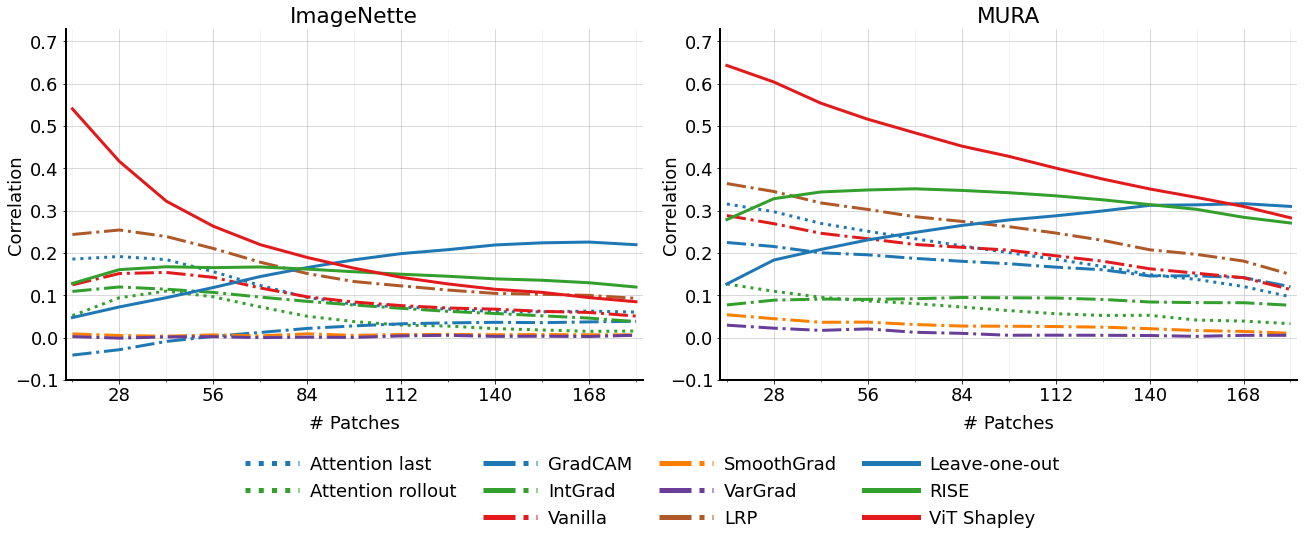

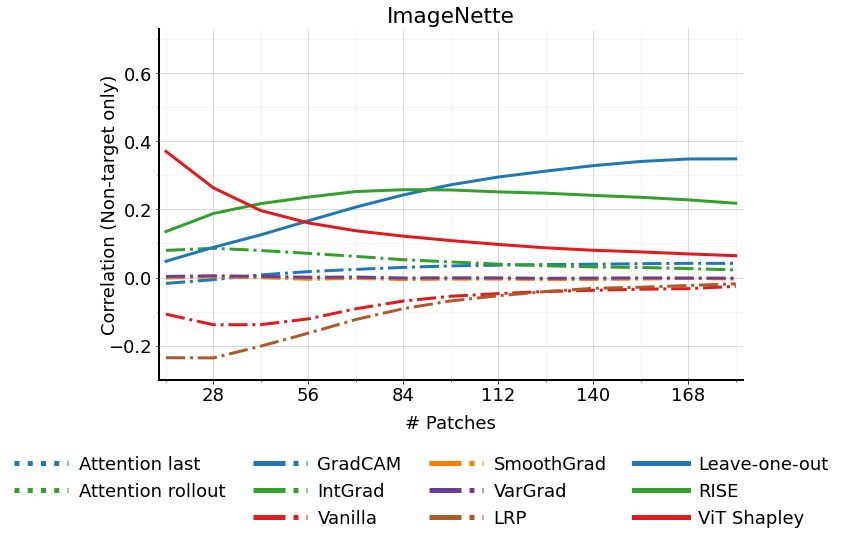

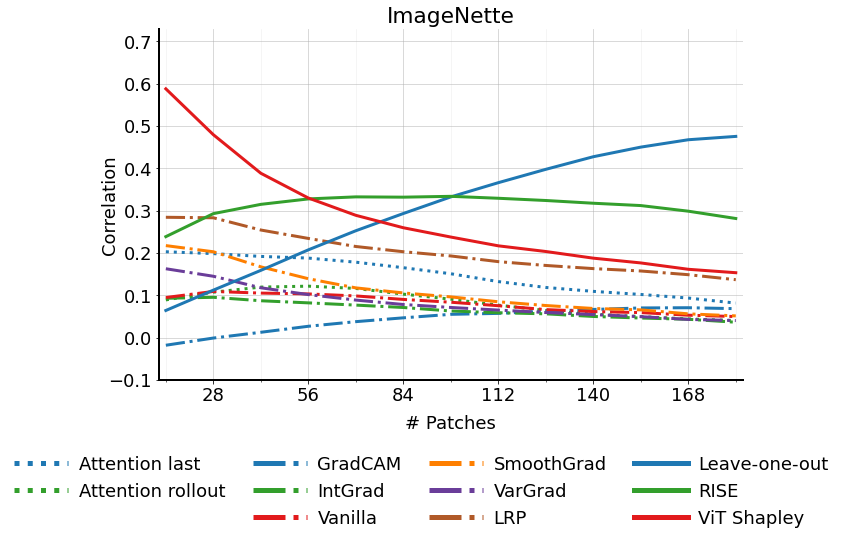

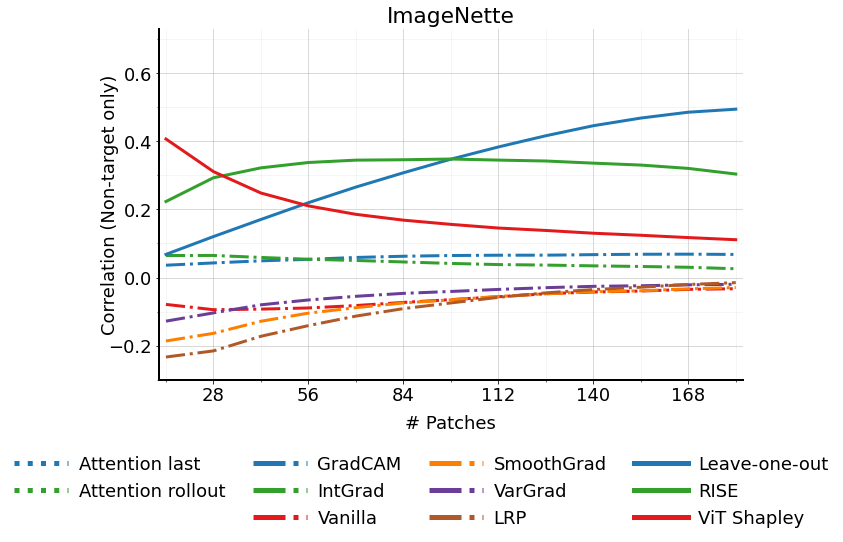

In [16]:
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):    
    #plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in Set1[6]])    
    for target_non_target in ["target", "non-target"]:
        plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                    Paired[12][3],
                                                                                    Paired[12][5],
                                                                                    Paired[12][7],
                                                                                    Paired[12][9],
                                                                                    Paired[12][11]
                                                                                    ]])     

        plt.rcParams['font.family'] = 'PT Sans'
        plt.rcParams["font.size"] = 18

        if target_non_target=="target" and backbone_type=="vit_base_patch16_224":

            fig = plt.figure(constrained_layout=True, figsize=(18, 6))
            subfigs = fig.subfigures(1, 2)

            ax_ImageNette = subfigs[0].subplots(1,1)
            #subfigs[0].supylabel("Correlation between sum of attributions and output", fontsize=18)

            ax_MURA = subfigs[1].subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                 f"MURA_{target_non_target}": ax_MURA,
                }
        elif backbone_type=="vit_small_patch16_224" or target_non_target=="non-target":
            fig = plt.figure(constrained_layout=True, figsize=(9, 6))
            subfigs = fig.subfigures(1, 1)

            ax_ImageNette = subfigs.subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                }

        else:
            raise

        cardinality_list=list(range(14, 196, 14))

        for dataset_name in ["ImageNette", "MURA"] if (target_non_target=="target" and backbone_type=="vit_base_patch16_224") else ["ImageNette"]:
            
            sensitivity_summarized_mean=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type]).groupby(["explanation_method", "num_included_players"])[target_non_target].mean()
            sensitivity_summarized_std=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type]).groupby(["explanation_method", "num_included_players"])[target_non_target].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
            
            plot_key=f'{dataset_name}_{target_non_target}'
            for idx1, explanation_methods_category in enumerate(explanation_method_main):
                for idx2, explanation_method in enumerate(explanation_methods_category):    
                    
                    axd[plot_key].plot(cardinality_list,
                                       sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values,
                                       linestyle=[':','-.','-'][idx1],
                                       linewidth=3,
                                       c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2])
                    
#                     axd[plot_key].fill_between(cardinality_list,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values - sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values + sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2], 
#                                                alpha=0.2)                    
            if target_non_target=="target":
                axd[plot_key].set_ylim(-0.1, 0.73)
            elif target_non_target=="non-target":
                axd[plot_key].set_ylim(-0.3, 0.73)
            else:
                raise
            axd[plot_key].set_xlim(14-2, 182+2)                          
                    
            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)
            #axd[plot_key].spines['bottom'].set_visible(False)


            axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   

#             if target_non_target=="target":
#                 axd[plot_key].tick_params(axis='x', which='both',
#                                 bottom=False)       

            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)                
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 
            if target_non_target=="target":
                axd[plot_key].set_ylabel("Correlation", labelpad=-10)
            elif target_non_target=="non-target":
                axd[plot_key].set_ylabel("Correlation (Non-target only)", labelpad=-10)                
            else:
                raise
            

            axd[plot_key].set_xlabel("# Patches", labelpad=10)
            
            axd[plot_key].set_title(dataset_name)
            
        legend_elements = [Line2D([0], [0],
                                  linestyle=[':','-.','-'][idx1],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2],
                                  linewidth=5,
                                  label=explanation_method_mapper(explanation_method))
                             for idx1, explanation_method_category in enumerate(explanation_method_main) for idx2, explanation_method in enumerate(explanation_method_category)]
        legend_elements.insert(2, Line2D([0], [0], linewidth=0))

        fig.legend(handles=legend_elements, 
                    ncol=4, 
                    handlelength=3,
                    handletextpad=0.6, 
                    columnspacing=1.5,
                    loc='lower center', bbox_to_anchor=(0.5, -0.25))              

        fig.savefig(f"results/plots/sensitivity_n_{backbone_type}_{target_non_target}.png", bbox_inches='tight')
        fig.savefig(f"results/plots/sensitivity_n_{backbone_type}_{target_non_target}.svg", bbox_inches='tight')
        fig.savefig(f"results/plots/sensitivity_n_{backbone_type}_{target_non_target}.jpg", bbox_inches='tight')
        fig.savefig(f"results/plots/sensitivity_n_{backbone_type}_{target_non_target}.pdf", bbox_inches='tight')        
            

RuntimeError: No active exception to reraise

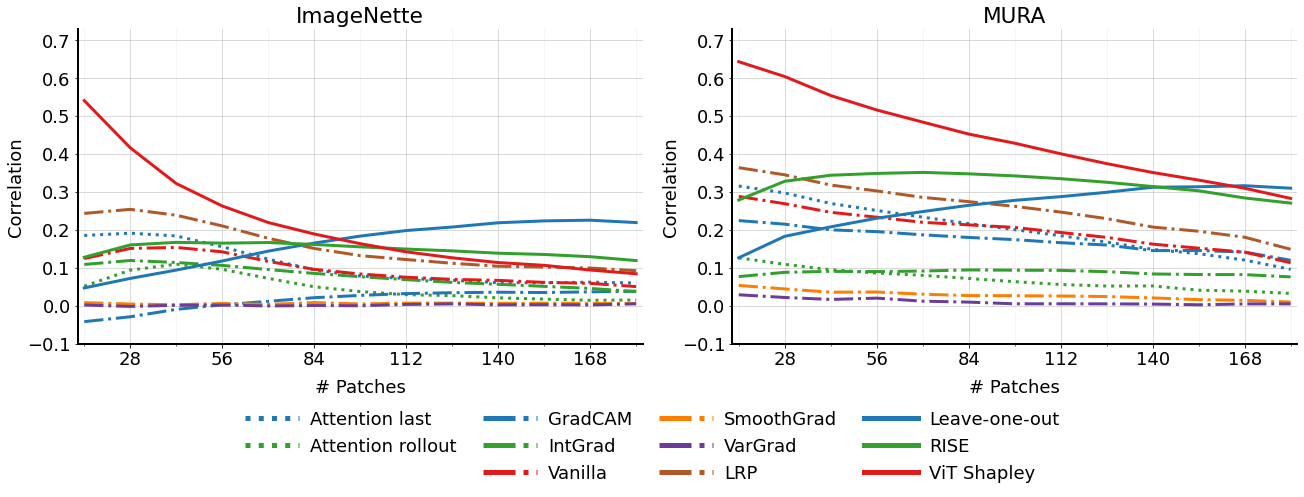

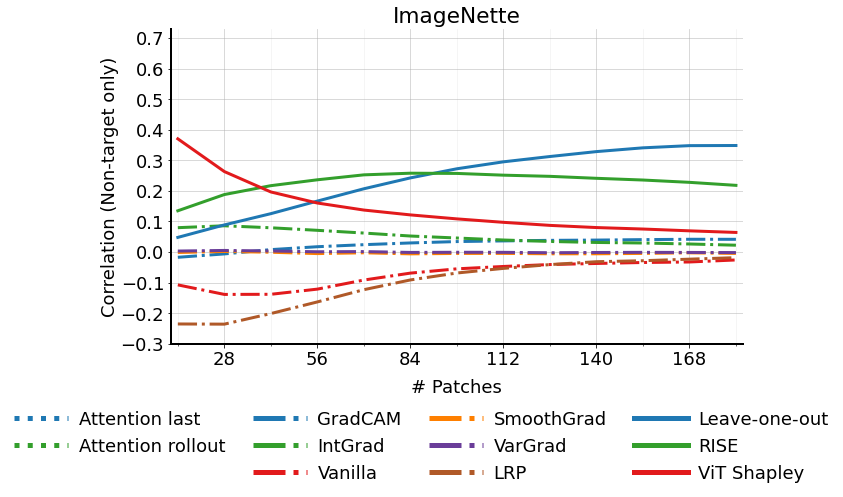

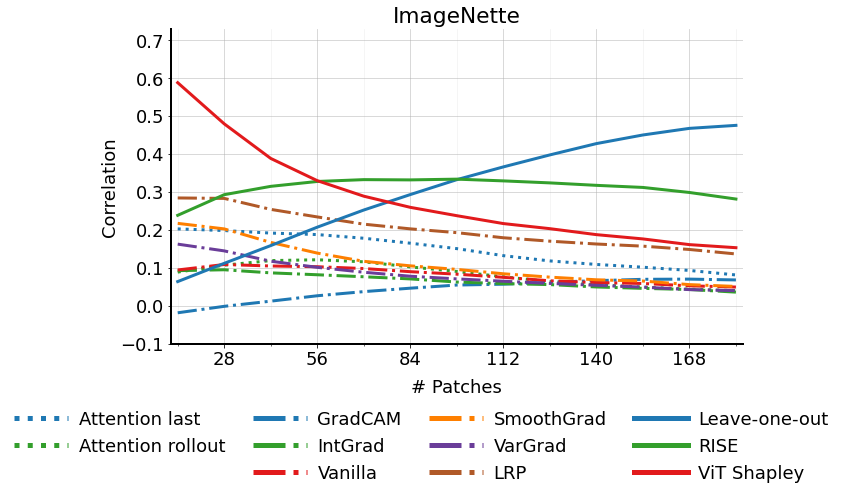

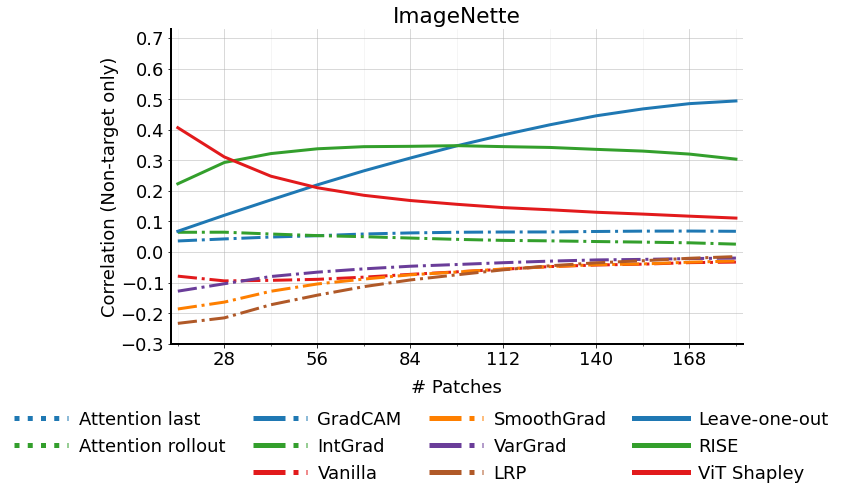

In [29]:
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):    
    #plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in Set1[6]])    
    for target_non_target in ["target", "non-target"]:
        plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                    Paired[12][3],
                                                                                    Paired[12][5],
                                                                                    Paired[12][7],
                                                                                    Paired[12][9],
                                                                                    Paired[12][11]
                                                                                    ]])     

        plt.rcParams['font.family'] = 'PT Sans'
        plt.rcParams["font.size"] = 18

        if target_non_target=="target" and backbone_type=="vit_base_patch16_224":

            fig = plt.figure(constrained_layout=True, figsize=(18, 5.5))
            subfigs = fig.subfigures(1, 2)

            ax_ImageNette = subfigs[0].subplots(1,1)
            #subfigs[0].supylabel("Correlation between sum of attributions and output", fontsize=18)

            ax_MURA = subfigs[1].subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                 f"MURA_{target_non_target}": ax_MURA,
                }
        elif backbone_type=="vit_small_patch16_224" or target_non_target=="non-target":
            fig = plt.figure(constrained_layout=True, figsize=(9, 5.5))
            subfigs = fig.subfigures(1, 1)

            ax_ImageNette = subfigs.subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                }

        else:
            raise

        cardinality_list=list(range(14, 196, 14))

        for dataset_name in ["ImageNette", "MURA"] if (target_non_target=="target" and backbone_type=="vit_base_patch16_224") else ["ImageNette"]:
            
            sensitivity_summarized_mean=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type]).groupby(["explanation_method", "num_included_players"])[target_non_target].mean()
            sensitivity_summarized_std=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type]).groupby(["explanation_method", "num_included_players"])[target_non_target].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
            
            plot_key=f'{dataset_name}_{target_non_target}'
            for idx1, explanation_methods_category in enumerate(explanation_method_main):
                for idx2, explanation_method in enumerate(explanation_methods_category):    
                    
                    axd[plot_key].plot(cardinality_list,
                                       sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values,
                                       linestyle=[':','-.','-'][idx1],
                                       linewidth=3,
                                       c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2])
                    
#                     axd[plot_key].fill_between(cardinality_list,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values - sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values + sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2], 
#                                                alpha=0.2)                    
            if target_non_target=="target":
                axd[plot_key].set_ylim(-0.1, 0.73)
            elif target_non_target=="non-target":
                axd[plot_key].set_ylim(-0.3, 0.73)
            else:
                raise
            axd[plot_key].set_xlim(14-2, 182+2)                          
                    
            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)
            #axd[plot_key].spines['bottom'].set_visible(False)


            axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   

#             if target_non_target=="target":
#                 axd[plot_key].tick_params(axis='x', which='both',
#                                 bottom=False)       

            axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)                
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 
            if target_non_target=="target":
                axd[plot_key].set_ylabel("Correlation", labelpad=2)
            elif target_non_target=="non-target":
                axd[plot_key].set_ylabel("Correlation (Non-target only)", labelpad=2)
            else:
                raise
            

            axd[plot_key].set_xlabel("# Patches", labelpad=10)
            
            axd[plot_key].set_title(dataset_name)
            
        legend_elements = [Line2D([0], [0],
                                  linestyle=[':','-.','-'][idx1],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2],
                                  linewidth=5,
                                  label=explanation_method_mapper(explanation_method))
                             for idx1, explanation_method_category in enumerate(explanation_method_main) for idx2, explanation_method in enumerate(explanation_method_category)]
        legend_elements.insert(2, Line2D([0], [0], linewidth=0))

        fig.legend(handles=legend_elements, 
                    ncol=4, 
                    handlelength=3,
                    handletextpad=0.6, 
                    columnspacing=1.5,
                    loc='lower center', bbox_to_anchor=(0.5, -0.25))              

        fig.savefig(f"results/plots/sensitivity_n_{backbone_type}_{target_non_target}.png", bbox_inches='tight')
        fig.savefig(f"results/plots/sensitivity_n_{backbone_type}_{target_non_target}.svg", bbox_inches='tight')
        fig.savefig(f"results/plots/sensitivity_n_{backbone_type}_{target_non_target}.jpg", bbox_inches='tight')
        fig.savefig(f"results/plots/sensitivity_n_{backbone_type}_{target_non_target}.pdf", bbox_inches='tight')        
            

# estimationerror

In [ ]:
def flatten_data(x_array):

    if len(x_array)==1:
        return x_array
    else:
        sample_len=len([x for x in x_array][0])
        if all([len(x)==1 for x in x_array]):
            x_array_new=np.array([x[0] for x in x_array])
            return x_array_new
        elif all([len(x)==sample_len for x in x_array]):
            x_array_new=np.array([x for x_list in x_array for x in x_list])
            return x_array_new
        else:
            raise

for _, (backbone_type, backbone_type_config) in enumerate({'vit_base_patch16_224': []}.items()):    
    #plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in Set1[6]])    
    for target_non_target in ["target", "non-target"]:
        plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                    Paired[12][3],
                                                                                    Paired[12][5],
                                                                                    Paired[12][7],
                                                                                    Paired[12][9],
                                                                                    Paired[12][11]
                                                                                    ]])     

        plt.rcParams['font.family'] = 'PT Sans'
        plt.rcParams["font.size"] = 18

        if backbone_type=="vit_base_patch16_224" or target_non_target=="target":

            fig = plt.figure(constrained_layout=True, figsize=(9,6))
            subfigs = fig.subfigures(1, 1)

            ax_ImageNette = subfigs.subplots(1,1)
            #subfigs[0].supylabel("Correlation between sum of attributions and output", fontsize=18)

            #ax_MURA = subfigs[1].subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                }
        elif backbone_type=="vit_base_patch16_224" or target_non_target=="non-target":
            fig = plt.figure(constrained_layout=True, figsize=(9,6))
            subfigs = fig.subfigures(1, 1)

            ax_ImageNette = subfigs.subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                }

        else:
            raise

        for dataset_name in ["ImageNette"]:
            estimationerror_summarized=pd.DataFrame(estimationerror_result_dict[dataset_name][backbone_type])
            
            plot_key=f'{dataset_name}_{target_non_target}'

            
            # ours
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target].apply(lambda x: (flatten_data(x)).mean())
            ours_mean=flatten_data(estimationerror_summarized[estimationerror_summarized["explanation_method"]=="ours"][target_non_target]).mean()
#             axd[plot_key].axhline(y=ours_mean, xmin=0, xmax=1, 
#                                linestyle=[':','-.','-'][2],
#                                linewidth=3,
#                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][2])             
            axd[plot_key].plot(error_mean.index.values,
                               [ours_mean]*len(error_mean.index.values),
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][2])             
            
            # kernelshap
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target].apply(lambda x: (flatten_data(x)).mean())
            error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target].apply(lambda x: 1.96*(flatten_data(x)).std()/np.sqrt(len(flatten_data(x))))
            axd[plot_key].plot(error_mean.index.values,
                               error_mean.values,
                               linestyle=[':','-.','-'][2],
                               linewidth=2,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])  
            
            axd[plot_key].fill_between(error_mean.index.values,
                               error_mean.values-error_std.values,
                               error_mean.values+error_std.values,                                       
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               alpha=0.3,
                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])            
            
#             sns.lineplot(data=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"],
#                         x="num_sample", y="target", ax=axd[plot_key])
            
            # kernelshapnopair
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target].apply(lambda x: (flatten_data(x)).mean())
            error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target].apply(lambda x: 1.96*(flatten_data(x)).std()/np.sqrt(len(flatten_data(x))))
            axd[plot_key].plot(error_mean.index.values,
                               error_mean.values,
                               linestyle=[':','-.','-'][2],
                               linewidth=1,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])  
            
            axd[plot_key].fill_between(error_mean.index.values,
                               error_mean.values-error_std.values,
                               error_mean.values+error_std.values,                                       
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               alpha=0.3,
                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])  
            
            for idx1, explanation_methods_category in enumerate(explanation_method_main):
                for idx2, explanation_method in enumerate(explanation_methods_category):    
                    pass

                    
#                     axd[plot_key].fill_between(cardinality_list,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values - sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values + sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2], 
#                                                alpha=0.2)                    
            if target_non_target=="target":
                #axd[plot_key].set_ylim(-0.1, 1)
                axd[plot_key].set_ylim(1e-2, 1e+0)
                pass
            elif target_non_target=="non-target":
                #axd[plot_key].set_ylim(-0.3, 1)
                axd[plot_key].set_ylim(1e-3, 1e+0)
                pass
            else:
                raise
            axd[plot_key].set_xlim(-1, None)
            #axd[plot_key].set_xlim(80000, 100000)
                    
            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)
            #axd[plot_key].spines['bottom'].set_visible(False)


            axd[plot_key].xaxis.set_major_locator(MultipleLocator(50000))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(10000))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   
            from matplotlib.ticker import FuncFormatter
            from matplotlib.ticker import StrMethodFormatter
            axd[plot_key].xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
            #axd[plot_key].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x/1000)}'))

#             if target_non_target=="target":
#                 axd[plot_key].tick_params(axis='x', which='both',
#                                 bottom=False)       
            
            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)                
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 
            if target_non_target=="target":
                axd[plot_key].set_ylabel("L2 distance (Target)", labelpad=0)
            elif target_non_target=="non-target":
                axd[plot_key].set_ylabel("L2 distance (Non-target)", labelpad=0)
            else:
                raise
            

            axd[plot_key].set_xlabel("# Evals", labelpad=10)
            
            axd[plot_key].set_title(dataset_name)
            
            axd[plot_key].set_yscale('log')
            
        legend_elements = [Line2D([0], [0],
                                  linestyle=[':','-.','-'][2],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][1],
                                  linewidth=5,
                                  label="KernelSHAP + Paired Sampling"),
                           Line2D([0], [0],
                                  linestyle=[':','-.','-'][2],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][0],
                                  linewidth=5,
                                  label="KernelSHAP"),
                          Line2D([0], [0],
                                  linestyle=[':','-.','-'][2],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][2],
                                  linewidth=5,
                                  label=explanation_method_mapper("ours"))
                          ]
        #legend_elements.insert(2, Line2D([0], [0], linewidth=0))

        fig.legend(handles=legend_elements, 
                    ncol=4, 
                    handlelength=3,
                    handletextpad=0.6, 
                    columnspacing=1.5,
                    loc='lower center', bbox_to_anchor=(0.5, -0.1))              

        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.png", bbox_inches='tight')
        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.svg", bbox_inches='tight')
        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.jpg", bbox_inches='tight')
        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.pdf", bbox_inches='tight')        
            

In [ ]:
for _, (backbone_type, backbone_type_config) in enumerate({'vit_base_patch16_224': []}.items()):    
    #plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in Set1[6]])    
    for target_non_target in ["target", "non-target"]:
        plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                    Paired[12][3],
                                                                                    Paired[12][5],
                                                                                    Paired[12][7],
                                                                                    Paired[12][9],
                                                                                    Paired[12][11]
                                                                                    ]])     

        plt.rcParams['font.family'] = 'PT Sans'
        plt.rcParams["font.size"] = 18

        if backbone_type=="vit_base_patch16_224" or target_non_target=="target":

            fig = plt.figure(constrained_layout=True, figsize=(9,6))
            subfigs = fig.subfigures(1, 1)

            ax_ImageNette = subfigs.subplots(1,1)
            #subfigs[0].supylabel("Correlation between sum of attributions and output", fontsize=18)

            #ax_MURA = subfigs[1].subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                }
        elif backbone_type=="vit_base_patch16_224" or target_non_target=="non-target":
            fig = plt.figure(constrained_layout=True, figsize=(9,6))
            subfigs = fig.subfigures(1, 1)

            ax_ImageNette = subfigs.subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                }

        else:
            raise

        for dataset_name in ["ImageNette"]:
            estimationerror_summarized=pd.DataFrame(estimationerror_result_dict[dataset_name][backbone_type])
            
            plot_key=f'{dataset_name}_{target_non_target}'

            
            
            
            # ours
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+"_pearson_r"].apply(lambda x: (flatten_data(x)).mean())
            ours_mean=flatten_data(estimationerror_summarized[estimationerror_summarized["explanation_method"]=="ours"][target_non_target+"_pearson_r"]).mean()
            axd[plot_key].plot(error_mean.index.values,
                               [ours_mean]*len(error_mean.index.values),
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][2])             
            
            # kernelshap
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+"_pearson_r"].apply(lambda x: (flatten_data(x)).mean())
            error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+"_pearson_r"].apply(lambda x: 1.96*(flatten_data(x)).std()/np.sqrt(len(flatten_data(x))))
            axd[plot_key].plot(error_mean.index.values,
                               error_mean.values,
                               linestyle=[':','-.','-'][2],
                               linewidth=2,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])  
            
            axd[plot_key].fill_between(error_mean.index.values,
                               error_mean.values-error_std.values,
                               error_mean.values+error_std.values,                                       
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               alpha=0.3,
                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])            
            
#             sns.lineplot(data=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"],
#                         x="num_sample", y="target", ax=axd[plot_key])
            
            # kernelshapnopair
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target+"_pearson_r"].apply(lambda x: (flatten_data(x)).mean())
            error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target+"_pearson_r"].apply(lambda x: 1.96*(flatten_data(x)).std()/np.sqrt(len(flatten_data(x))))
            axd[plot_key].plot(error_mean.index.values,
                               error_mean.values,
                               linestyle=[':','-.','-'][2],
                               linewidth=1,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])  
            
            axd[plot_key].fill_between(error_mean.index.values,
                               error_mean.values-error_std.values,
                               error_mean.values+error_std.values,                                       
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               alpha=0.3,
                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])             
            
            
            
            
            
            
            
            
#             # ours
#             estimationerror_summarized_select=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"]).mean()
#             ours_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="ours"][target_non_target+"_pearson_r"].mean()
#             axd[plot_key].plot(estimationerror_summarized_select.index.values,
#                                [ours_mean]*len(estimationerror_summarized_select.index.values),
#                                linestyle=[':','-.','-'][2],
#                                linewidth=3,
#                                c=plt.rcParams["axes.prop_cycle"].by_key()['color'][2])             
            
#             # kernelshap
#             error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+"_pearson_r"].apply(lambda x: x.mean())
#             error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+"_pearson_r"].apply(lambda x: 1.96*x.std()/np.sqrt(len(x)))
#             axd[plot_key].plot(error_mean.index.values,
#                                error_mean.values,
#                                linestyle=[':','-.','-'][2],
#                                linewidth=2,
#                                c=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])  
            
#             axd[plot_key].fill_between(error_mean.index.values,
#                                error_mean.values-error_std.values,
#                                error_mean.values+error_std.values,                                       
#                                linestyle=[':','-.','-'][2],
#                                linewidth=3,
#                                alpha=0.3,
#                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])            
            
# #             sns.lineplot(data=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"],
# #                         x="num_sample", y="target", ax=axd[plot_key])
            
#             # kernelshapnopair
#             error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target+"_pearson_r"].apply(lambda x: x.mean())
#             error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target+"_pearson_r"].apply(lambda x: 1.96*x.std()/np.sqrt(len(x)))
#             axd[plot_key].plot(error_mean.index.values,
#                                error_mean.values,
#                                linestyle=[':','-.','-'][2],
#                                linewidth=1,
#                                c=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])  
            
#             axd[plot_key].fill_between(error_mean.index.values,
#                                error_mean.values-error_std.values,
#                                error_mean.values+error_std.values,                                       
#                                linestyle=[':','-.','-'][2],
#                                linewidth=3,
#                                alpha=0.3,
#                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])  
            
            for idx1, explanation_methods_category in enumerate(explanation_method_main):
                for idx2, explanation_method in enumerate(explanation_methods_category):    
                    pass

                    
#                     axd[plot_key].fill_between(cardinality_list,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values - sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values + sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2], 
#                                                alpha=0.2)                    
            if target_non_target=="target":
                #axd[plot_key].set_ylim(-0.1, 1)
                axd[plot_key].set_ylim(0, 1e+0)
                pass
            elif target_non_target=="non-target":
                #axd[plot_key].set_ylim(-0.3, 1)
                axd[plot_key].set_ylim(0, 1e+0)
                pass
            else:
                raise
            axd[plot_key].set_xlim(-1, None)
            #axd[plot_key].set_xlim(80000, 100000)
                    
            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)
            #axd[plot_key].spines['bottom'].set_visible(False)


            axd[plot_key].xaxis.set_major_locator(MultipleLocator(50000))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(10000))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   
            from matplotlib.ticker import FuncFormatter
            from matplotlib.ticker import StrMethodFormatter
            axd[plot_key].xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
            #axd[plot_key].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x/1000)}'))

#             if target_non_target=="target":
#                 axd[plot_key].tick_params(axis='x', which='both',
#                                 bottom=False)       
            
            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)                
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 
            if target_non_target=="target":
                axd[plot_key].set_ylabel("Pearson correlation (Target)", labelpad=0)
            elif target_non_target=="non-target":
                axd[plot_key].set_ylabel("Pearson correlation (Non-target)", labelpad=0)
            else:
                raise
            

            axd[plot_key].set_xlabel("# Evals", labelpad=10)
            
            axd[plot_key].set_title(dataset_name)
            
            #axd[plot_key].set_yscale('log')
            
        legend_elements = [Line2D([0], [0],
                                  linestyle=[':','-.','-'][2],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][1],
                                  linewidth=5,
                                  label="KernelSHAP + Paired Sampling"),
                           Line2D([0], [0],
                                  linestyle=[':','-.','-'][2],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][0],
                                  linewidth=5,
                                  label="KernelSHAP"),
                          Line2D([0], [0],
                                  linestyle=[':','-.','-'][2],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][2],
                                  linewidth=5,
                                  label=explanation_method_mapper("ours"))
                          ]
        #legend_elements.insert(2, Line2D([0], [0], linewidth=0))

        fig.legend(handles=legend_elements, 
                    ncol=4, 
                    handlelength=3,
                    handletextpad=0.6, 
                    columnspacing=1.5,
                    loc='lower center', bbox_to_anchor=(0.5, -0.1))              

        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.png", bbox_inches='tight')
        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.svg", bbox_inches='tight')
        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.jpg", bbox_inches='tight')
        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.pdf", bbox_inches='tight')        
            

In [ ]:
for _, (backbone_type, backbone_type_config) in enumerate({'vit_base_patch16_224': []}.items()):    
    #plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in Set1[6]])    
    for target_non_target in ["target", "non-target"]:
        plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                    Paired[12][3],
                                                                                    Paired[12][5],
                                                                                    Paired[12][7],
                                                                                    Paired[12][9],
                                                                                    Paired[12][11]
                                                                                    ]])     

        plt.rcParams['font.family'] = 'PT Sans'
        plt.rcParams["font.size"] = 18

        if backbone_type=="vit_base_patch16_224" or target_non_target=="target":

            fig = plt.figure(constrained_layout=True, figsize=(9,6))
            subfigs = fig.subfigures(1, 1)

            ax_ImageNette = subfigs.subplots(1,1)
            #subfigs[0].supylabel("Correlation between sum of attributions and output", fontsize=18)

            #ax_MURA = subfigs[1].subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                }
        elif backbone_type=="vit_base_patch16_224" or target_non_target=="non-target":
            fig = plt.figure(constrained_layout=True, figsize=(9,6))
            subfigs = fig.subfigures(1, 1)

            ax_ImageNette = subfigs.subplots(1,1)

            axd={f"ImageNette_{target_non_target}": ax_ImageNette,
                }

        else:
            raise

        for dataset_name in ["ImageNette"]:
            estimationerror_summarized=pd.DataFrame(estimationerror_result_dict[dataset_name][backbone_type])
            
            plot_key=f'{dataset_name}_{target_non_target}'

            
            # ours
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+"_spearman_r"].apply(lambda x: (flatten_data(x)).mean())
            ours_mean=flatten_data(estimationerror_summarized[estimationerror_summarized["explanation_method"]=="ours"][target_non_target+"_spearman_r"]).mean()
            axd[plot_key].plot(error_mean.index.values,
                               [ours_mean]*len(error_mean.index.values),
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][2])             
            
            # kernelshap
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+"_spearman_r"].apply(lambda x: (flatten_data(x)).mean())
            error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+"_spearman_r"].apply(lambda x: 1.96*(flatten_data(x)).std()/np.sqrt(len(flatten_data(x))))
            axd[plot_key].plot(error_mean.index.values,
                               error_mean.values,
                               linestyle=[':','-.','-'][2],
                               linewidth=2,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])  
            
            axd[plot_key].fill_between(error_mean.index.values,
                               error_mean.values-error_std.values,
                               error_mean.values+error_std.values,                                       
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               alpha=0.3,
                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])            
            
#             sns.lineplot(data=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"],
#                         x="num_sample", y="target", ax=axd[plot_key])
            
            # kernelshapnopair
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target+"_spearman_r"].apply(lambda x: (flatten_data(x)).mean())
            error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target+"_spearman_r"].apply(lambda x: 1.96*(flatten_data(x)).std()/np.sqrt(len(flatten_data(x))))
            axd[plot_key].plot(error_mean.index.values,
                               error_mean.values,
                               linestyle=[':','-.','-'][2],
                               linewidth=1,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])  
            
            axd[plot_key].fill_between(error_mean.index.values,
                               error_mean.values-error_std.values,
                               error_mean.values+error_std.values,                                       
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               alpha=0.3,
                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])   
            
            for idx1, explanation_methods_category in enumerate(explanation_method_main):
                for idx2, explanation_method in enumerate(explanation_methods_category):    
                    pass

                    
#                     axd[plot_key].fill_between(cardinality_list,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values - sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                sensitivity_summarized_mean.loc[explanation_method].loc[cardinality_list].values + sensitivity_summarized_std.loc[explanation_method].loc[cardinality_list].values,
#                                                color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2], 
#                                                alpha=0.2)                    
            if target_non_target=="target":
                #axd[plot_key].set_ylim(-0.1, 1)
                axd[plot_key].set_ylim(0, 1e+0)
                pass
            elif target_non_target=="non-target":
                #axd[plot_key].set_ylim(-0.3, 1)
                axd[plot_key].set_ylim(0, 1e+0)
                pass
            else:
                raise
            axd[plot_key].set_xlim(-1, None)
            #axd[plot_key].set_xlim(80000, 100000)
                    
            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)
            #axd[plot_key].spines['bottom'].set_visible(False)


            axd[plot_key].xaxis.set_major_locator(MultipleLocator(50000))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(10000))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   
            from matplotlib.ticker import FuncFormatter
            from matplotlib.ticker import StrMethodFormatter
            axd[plot_key].xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
            #axd[plot_key].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x/1000)}'))

#             if target_non_target=="target":
#                 axd[plot_key].tick_params(axis='x', which='both',
#                                 bottom=False)       
            
            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)                
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 
            if target_non_target=="target":
                axd[plot_key].set_ylabel("Spearman correlation (Target)", labelpad=0)
            elif target_non_target=="non-target":
                axd[plot_key].set_ylabel("Spearman correlation (Non-target)", labelpad=0)
            else:
                raise
            

            axd[plot_key].set_xlabel("# Evals", labelpad=10)
            
            axd[plot_key].set_title(dataset_name)
            
            #axd[plot_key].set_yscale('log')
            
        legend_elements = [Line2D([0], [0],
                                  linestyle=[':','-.','-'][2],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][1],
                                  linewidth=5,
                                  label="KernelSHAP + Paired Sampling"),
                           Line2D([0], [0],
                                  linestyle=[':','-.','-'][2],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][0],
                                  linewidth=5,
                                  label="KernelSHAP"),
                          Line2D([0], [0],
                                  linestyle=[':','-.','-'][2],
                                  color=plt.rcParams["axes.prop_cycle"].by_key()['color'][2],
                                  linewidth=5,
                                  label=explanation_method_mapper("ours"))
                          ]
        #legend_elements.insert(2, Line2D([0], [0], linewidth=0))

        fig.legend(handles=legend_elements, 
                    ncol=4, 
                    handlelength=3,
                    handletextpad=0.6, 
                    columnspacing=1.5,
                    loc='lower center', bbox_to_anchor=(0.5, -0.1))              

        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.png", bbox_inches='tight')
        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.svg", bbox_inches='tight')
        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.jpg", bbox_inches='tight')
        #fig.savefig(f"results/plots/estimationerror_{backbone_type}_{target_non_target}.pdf", bbox_inches='tight')        
            

In [ ]:
dataset_name="ImageNette"

for _, (backbone_type, backbone_type_config) in enumerate({'vit_base_patch16_224': []}.items()):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                Paired[12][3],
                                                                                Paired[12][5],
                                                                                Paired[12][7],
                                                                                Paired[12][9],
                                                                                Paired[12][11]
                                                                                ]])   
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 15
    
    
    fig = plt.figure(figsize=(18, 5.5*3))
    box1 = gridspec.GridSpec(3, 1, wspace=0, hspace=0.3)
    
    axd={}
    for idx1, stage in enumerate(["l2distance", "pearson", "spearman"]):
        box2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=box1[idx1], wspace=0.15, hspace=0)
        for idx2, target_non_target in enumerate(["target", "non-target"]):
            box3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=box2[idx2], wspace=0, hspace=0)
            ax = plt.Subplot(fig, box3[0])
            fig.add_subplot(ax)
            
            plot_key=f"{stage}_{target_non_target}"
            axd[plot_key]=ax
    
    estimationerror_summarized=pd.DataFrame(estimationerror_result_dict[dataset_name][backbone_type])
    for idx1, stage in enumerate(["l2distance", "pearson", "spearman"]):
        for idx2, target_non_target in enumerate(["target", "non-target"]):
            print(stage)
            
            plot_key=f"{stage}_{target_non_target}"
            
            if stage=="l2distance":
                stage_key=""
            elif stage=="pearson":
                stage_key="_pearson_r"
            elif stage=="spearman":
                stage_key="_spearman_r"
            else:
                raise
                                
            # ours
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+stage_key].apply(lambda x: (flatten_data(x)).mean())
            ours_mean=flatten_data(estimationerror_summarized[estimationerror_summarized["explanation_method"]=="ours"][target_non_target+stage_key]).mean()
            axd[plot_key].plot(error_mean.index.values,
                               [ours_mean]*len(error_mean.index.values),
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][2])             
            
            # kernelshap
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+stage_key].apply(lambda x: (flatten_data(x)).mean())
            error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"].groupby(["num_sample"])[target_non_target+stage_key].apply(lambda x: 1.96*(flatten_data(x)).std()/np.sqrt(len(flatten_data(x))))
            axd[plot_key].plot(error_mean.index.values,
                               error_mean.values,
                               linestyle=[':','-.','-'][2],
                               linewidth=2,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])  
            
            axd[plot_key].fill_between(error_mean.index.values,
                               error_mean.values-error_std.values,
                               error_mean.values+error_std.values,                                       
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               alpha=0.3,
                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][1])            
            
#             sns.lineplot(data=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshap"],
#                         x="num_sample", y="target", ax=axd[plot_key])
            
            # kernelshapnopair
            error_mean=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target+stage_key].apply(lambda x: (flatten_data(x)).mean())
            error_std=estimationerror_summarized[estimationerror_summarized["explanation_method"]=="kernelshapnopair"].groupby(["num_sample"])[target_non_target+stage_key].apply(lambda x: 1.96*(flatten_data(x)).std()/np.sqrt(len(flatten_data(x))))
            axd[plot_key].plot(error_mean.index.values,
                               error_mean.values,
                               linestyle=[':','-.','-'][2],
                               linewidth=1,
                               c=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])  
            
            axd[plot_key].fill_between(error_mean.index.values,
                               error_mean.values-error_std.values,
                               error_mean.values+error_std.values,                                       
                               linestyle=[':','-.','-'][2],
                               linewidth=3,
                               alpha=0.3,
                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][0])
            

            if stage=="l2distance":
                axd[plot_key].set_title(target_non_target_mapper(target_non_target), pad=15)
    
            if stage=="l2distance":
                if target_non_target=="target":
                    #axd[plot_key].set_ylim(-0.1, 1)
                    axd[plot_key].set_ylim(1e-2, 1e+0)
                    pass
                elif target_non_target=="non-target":
                    #axd[plot_key].set_ylim(-0.3, 1)
                    axd[plot_key].set_ylim(1e-3, 1e+0)
                    pass
                else:
                    raise
                axd[plot_key].set_xlim(-1, None) 
            elif stage=="pearson":
                if target_non_target=="target":
                    #axd[plot_key].set_ylim(-0.1, 1)
                    axd[plot_key].set_ylim(0, 1e+0)
                    pass
                elif target_non_target=="non-target":
                    #axd[plot_key].set_ylim(-0.3, 1)
                    axd[plot_key].set_ylim(0, 1e+0)
                    pass
                else:
                    raise
                axd[plot_key].set_xlim(-1, None)
            elif stage=="spearman":
                if target_non_target=="target":
                    #axd[plot_key].set_ylim(-0.1, 1)
                    axd[plot_key].set_ylim(1e-2, 1e+0)
                    pass
                elif target_non_target=="non-target":
                    #axd[plot_key].set_ylim(-0.3, 1)
                    axd[plot_key].set_ylim(1e-3, 1e+0)
                    pass
                else:
                    raise
                axd[plot_key].set_xlim(-1, None)  
            else:
                raise        

            if stage=="l2distance":
                axd[plot_key].set_yscale('log')
            
            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)

            axd[plot_key].xaxis.set_major_locator(MultipleLocator(50000))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(10000))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   
            from matplotlib.ticker import FuncFormatter
            from matplotlib.ticker import StrMethodFormatter
            axd[plot_key].xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
            #axd[plot_key].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x/1000)}'))

#             if target_non_target=="target":
#                 axd[plot_key].tick_params(axis='x', which='both',
#                                 bottom=False)       
            
            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 
                
            if stage=="l2distance":
                if target_non_target=="target":
                    axd[plot_key].set_ylabel("L2 distance")#, labelpad=0)
                elif target_non_target=="non-target":
                    axd[plot_key].set_ylabel("L2 distance")#, labelpad=0)
                else:
                    raise
            elif stage=="pearson":
                if target_non_target=="target":
                    axd[plot_key].set_ylabel("Pearson correlation", labelpad=15)
                elif target_non_target=="non-target":
                    axd[plot_key].set_ylabel("Pearson correlation", labelpad=15)
                else:
                    raise
            elif stage=="spearman":
                if target_non_target=="target":
                    axd[plot_key].set_ylabel("Spearman correlation", labelpad=15)
                elif target_non_target=="non-target":
                    axd[plot_key].set_ylabel("Spearman correlation", labelpad=15)
                else:
                    raise
            else:
                raise                

            axd[plot_key].set_xlabel("# Evals", labelpad=5)

#     legend_elements = [Line2D([0], [0],
#                               linestyle=[':','-.','-','-'][idx1],
#                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8],
#                               linewidth=3,
#                               label=explanation_method_mapper(explanation_method))
#                          for idx1, explanation_method_category in enumerate(explanation_method_main_random) for idx2, explanation_method in enumerate(explanation_method_category)]
    
    
#     legend_elements.insert(2, Line2D([0], [0], linewidth=0))
#     legend_elements.insert(13, Line2D([0], [0], linewidth=0))
#     legend_elements.insert(13, Line2D([0], [0], linewidth=0))
    
#     fig.legend(handles=legend_elements, 
#                 ncol=5, 
#                 handlelength=3,
#                 handletextpad=0.6, 
#                 columnspacing=1.5,
#                 fontsize=15,
#                 loc='lower center', bbox_to_anchor=(0.5, 0.01))    
    
    legend_elements = [Line2D([0], [0],
                              linestyle=[':','-.','-'][2],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][1],
                              linewidth=5,
                              label="KernelSHAP + Paired Sampling"),
                       Line2D([0], [0],
                              linestyle=[':','-.','-'][2],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][0],
                              linewidth=5,
                              label="KernelSHAP"),
                      Line2D([0], [0],
                              linestyle=[':','-.','-'][2],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][2],
                              linewidth=5,
                              label=explanation_method_mapper("ours"))
                      ]
    #legend_elements.insert(2, Line2D([0], [0], linewidth=0))

    fig.legend(handles=legend_elements, 
                ncol=3, 
                handlelength=3,
                handletextpad=0.6, 
                columnspacing=1.5,
                loc='lower center', bbox_to_anchor=(0.5, 0.05))
    
    fig.show()
    
    fig.savefig(f"results/plots/estimationerror_{backbone_type}_{dataset_name}.png", bbox_inches='tight')
    fig.savefig(f"results/plots/estimationerror_{backbone_type}_{dataset_name}.svg", bbox_inches='tight')
    fig.savefig(f"results/plots/estimationerror_{backbone_type}_{dataset_name}.jpg", bbox_inches='tight')
    fig.savefig(f"results/plots/estimationerror_{backbone_type}_{dataset_name}.pdf", bbox_inches='tight')

# Table

# Only vit

In [31]:
auc_sensitivity_table_dict={}
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    auc_sensitivity_table_dict.setdefault(backbone_type, {})
    
    for dataset_name in ["Pet"] if backbone_type=="vit_base_patch16_224" else []:
        auc_sensitivity_table_dict[backbone_type].setdefault(dataset_name, {})
        # AUC mean, std
        roc_auc_table_mean=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].mean()
        roc_auc_table_mean=roc_auc_table_mean.add_suffix('_mean')
        
        roc_auc_table_std=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        roc_auc_table_std=roc_auc_table_std.add_suffix('_std')
        
        # Sensitivity mean, std
        sensitivity_table_mean=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].mean()
        sensitivity_table_mean=sensitivity_table_mean.add_suffix('_mean')
        
        sensitivity_table_std=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        sensitivity_table_std=sensitivity_table_std.add_suffix('_std')
        
        
        auc_sensitivity_table=pd.concat([roc_auc_table_mean.loc['insert'].add_prefix('insert_'), roc_auc_table_std.loc['insert'].add_prefix('insert_'),
                                         roc_auc_table_mean.loc['delete'].add_prefix('delete_'), roc_auc_table_std.loc['delete'].add_prefix('delete_'),
                                         sensitivity_table_mean.loc['all'].add_prefix('sensitivity_'), sensitivity_table_std.loc['all'].add_prefix('sensitivity_')
                                        ], axis=1)
        for subset_mode in ["main", "supple"]:
            auc_sensitivity_table_dict[backbone_type][dataset_name].setdefault(subset_mode, {})
            if subset_mode=="main":
                #auc_sensitivity_table_select=auc_sensitivity_table.loc[explanation_methods_main]
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_main_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "main"))
            elif subset_mode=="supple":
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_supple_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "supple"))
            else:
                raise
            #print(auc_sensitivity_table_select)
            for target_non_target in ["target", "non-target"]:
                #print('sdsdsd')
                #print(auc_sensitivity_table_select)
                auc_sensitivity_table_select_format=pd.concat([auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"insert_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if (x[f"insert_{target_non_target}_auc_mean"]-x[f"insert_{target_non_target}_auc_std"])<=((auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean']+auc_sensitivity_table_select[f'insert_{target_non_target}_auc_std'])["Random"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if x[f"insert_{target_non_target}_auc_mean"]>=(auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'][~auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]), axis=1),

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"delete_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if (x[f"delete_{target_non_target}_auc_mean"]+x[f"delete_{target_non_target}_auc_std"])>=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean']-auc_sensitivity_table_select[f'delete_{target_non_target}_auc_std'])["Random"]) else                                                                                                  
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if x[f"delete_{target_non_target}_auc_mean"]<=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'])[~auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'].isnull()]).min() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]), axis=1),                                        

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"sensitivity_{target_non_target}_mean"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]) if x[f"sensitivity_{target_non_target}_mean"]>=(auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'][~auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]), axis=1)  
                                                               ], axis=1)
                
                #whole_table_select.columns=['Insertion', 'Deletion', 'Sensitivity-n']        
                auc_sensitivity_table_select_format.columns=pd.MultiIndex.from_tuples([(dataset_name, metric) for metric in ["Ins. (↑)", "Del. (↓)", "Faith. (↑)"]])
                auc_sensitivity_table_dict[backbone_type][dataset_name][subset_mode][target_non_target]=\
                auc_sensitivity_table_select_format
                #print(auc_sensitivity_table_select_format.add_suffix(target_non_target),
                #     auc_sensitivity_table_select)
                #print('----------------------------------------------------------------')
        

In [32]:
table_df=pd.concat([auc_sensitivity_table_dict["vit_base_patch16_224"]["Pet"]["supple"]["target"],
           auc_sensitivity_table_dict["vit_base_patch16_224"]["Pet"]["supple"]["non-target"]], axis=1)

table_df.index.name = None

explanation_methods_category_list=[[explanation_method_mapper(j, "supple") for j in i] for i in explanation_method_supple_random_kernelshap]

print(df_to_latex(table_df, 
                  caption="main target",
                  explanation_methods_category_list = explanation_methods_category_list))

NameError: name 'df_to_latex' is not defined

In [33]:
table_df

Pet                           \
                                    Ins. (↑)                 Del. (↓)   
Attention last       grays0.886 (0.015)graye            0.504 (0.023)   
Attention rollout    grays0.848 (0.015)graye            0.670 (0.025)   
GradCAM (Attn)       grays0.844 (0.018)graye            0.749 (0.026)   
GradCAM (LN)         grays0.844 (0.015)graye            0.729 (0.028)   
IntGrad (Pixel)                0.904 (0.014)            0.809 (0.023)   
IntGrad (Embed.)               0.904 (0.014)            0.809 (0.023)   
Vanilla (Pixel)      grays0.871 (0.015)graye            0.602 (0.025)   
Vanilla (Embed.)               0.887 (0.015)            0.529 (0.026)   
SmoothGrad (Pixel)             0.898 (0.014)            0.491 (0.024)   
SmoothGrad (Embed.)  grays0.845 (0.017)graye  grays0.846 (0.018)graye   
VarGrad (Pixel)                0.901 (0.014)            0.517 (0.024)   
VarGrad (Embed.)     grays0.856 (0.016)graye  grays0.843 (0.018)graye   
LRP                            0.898 (0.014)            0.479 (0.023)   
Leave-one-out                  0.940 (0.007)            0.659 (0.033)   
RISE                           0.948 (0.006)            0.510 (0.032)   
ViT Shapley              bfs0.949 (0.008)bfe      bfs0.385 (0.024)bfe   
Random               grays0.856 (0.015)graye  grays0.851 (0.016)graye   

                                                                   \
                              Faith. (↑)                 Ins. (↑)   
Attention last             0.545 (0.017)                        -   
Attention rollout          0.559 (0.017)                        -   
GradCAM (Attn)             0.527 (0.016)  grays0.005 (0.000)graye   
GradCAM (LN)               0.553 (0.017)            0.011 (0.001)   
IntGrad (Pixel)            0.437 (0.017)            0.006 (0.001)   
IntGrad (Embed.)           0.437 (0.017)            0.006 (0.001)   
Vanilla (Pixel)            0.559 (0.017)  grays0.004 (0.000)graye   
Vanilla (Embed.)           0.561 (0.017)  grays0.003 (0.000)graye   
SmoothGrad (Pixel)         0.564 (0.017)  grays0.003 (0.000)graye   
SmoothGrad (Embed.)        0.558 (0.017)  grays0.004 (0.000)graye   
VarGrad (Pixel)            0.557 (0.017)  grays0.003 (0.000)graye   
VarGrad (Embed.)           0.555 (0.017)  grays0.004 (0.000)graye   
LRP                        0.567 (0.017)  grays0.004 (0.000)graye   
Leave-one-out              0.215 (0.036)            0.018 (0.002)   
RISE                       0.559 (0.017)            0.032 (0.003)   
ViT Shapley          bfs0.590 (0.016)bfe      bfs0.051 (0.003)bfe   
Random                                 -  grays0.004 (0.000)graye   

                                                                   
                                    Del. (↓)           Faith. (↑)  
Attention last                             -                    -  
Attention rollout                          -                    -  
GradCAM (Attn)       grays0.008 (0.001)graye       -0.499 (0.013)  
GradCAM (LN)         grays0.003 (0.000)graye       -0.511 (0.014)  
IntGrad (Pixel)                0.003 (0.000)        0.126 (0.008)  
IntGrad (Embed.)               0.003 (0.000)        0.126 (0.008)  
Vanilla (Pixel)      grays0.011 (0.001)graye       -0.526 (0.014)  
Vanilla (Embed.)     grays0.013 (0.001)graye       -0.529 (0.014)  
SmoothGrad (Pixel)   grays0.014 (0.001)graye       -0.532 (0.014)  
SmoothGrad (Embed.)  grays0.004 (0.000)graye       -0.526 (0.014)  
VarGrad (Pixel)      grays0.013 (0.001)graye       -0.522 (0.014)  
VarGrad (Embed.)     grays0.004 (0.001)graye       -0.523 (0.014)  
LRP                  grays0.013 (0.001)graye       -0.529 (0.014)  
Leave-one-out                  0.001 (0.000)        0.138 (0.023)  
RISE                           0.001 (0.000)       -0.523 (0.014)  
ViT Shapley              bfs0.001 (0.000)bfe  bfs0.529 (0.012)bfe  
Random               grays0.004 (0.000)graye                    -

In [35]:
x=table_df.applymap(lambda x: x.replace("grays", "").replace("graye", "").replace("bfs", "").replace("bfe", ""))

In [38]:
print(x.to_markdown())

|                     | ('Pet', 'Ins. (↑)')   | ('Pet', 'Del. (↓)')   | ('Pet', 'Faith. (↑)')   | ('Pet', 'Ins. (↑)')   | ('Pet', 'Del. (↓)')   | ('Pet', 'Faith. (↑)')   |
|:--------------------|:----------------------|:----------------------|:------------------------|:----------------------|:----------------------|:------------------------|
| Attention last      | 0.886 (0.015)         | 0.504 (0.023)         | 0.545 (0.017)           | -                     | -                     | -                       |
| Attention rollout   | 0.848 (0.015)         | 0.670 (0.025)         | 0.559 (0.017)           | -                     | -                     | -                       |
| GradCAM (Attn)      | 0.844 (0.018)         | 0.749 (0.026)         | 0.527 (0.016)           | 0.005 (0.000)         | 0.008 (0.001)         | -0.499 (0.013)          |
| GradCAM (LN)        | 0.844 (0.015)         | 0.729 (0.028)         | 0.553 (0.017)           | 0.011 (0.001)         | 0.003 (0.000)     

|                     | Target/Ins. (↑)   | Target/Del. (↓)   | Target/Faith. (↑)   | Non-target/Ins. (↑)   | Non-target/Del. (↓)  | Non-target/Faith. (↑)   |
|:--------------------|:----------------------|:----------------------|:------------------------|:----------------------|:----------------------|:------------------------|
| Attention last      | 0.886 (0.015)         | 0.504 (0.023)         | 0.545 (0.017)           | -                     | -                     | -                       |
| Attention rollout   | 0.848 (0.015)         | 0.670 (0.025)         | 0.559 (0.017)           | -                     | -                     | -                       |
| GradCAM (Attn)      | 0.844 (0.018)         | 0.749 (0.026)         | 0.527 (0.016)           | 0.005 (0.000)         | 0.008 (0.001)         | -0.499 (0.013)          |
| GradCAM (LN)        | 0.844 (0.015)         | 0.729 (0.028)         | 0.553 (0.017)           | 0.011 (0.001)         | 0.003 (0.000)         | -0.511 (0.014)          |
| IntGrad (Pixel)     | 0.904 (0.014)         | 0.809 (0.023)         | 0.437 (0.017)           | 0.006 (0.001)         | 0.003 (0.000)         | 0.126 (0.008)           |
| IntGrad (Embed.)    | 0.904 (0.014)         | 0.809 (0.023)         | 0.437 (0.017)           | 0.006 (0.001)         | 0.003 (0.000)         | 0.126 (0.008)           |
| Vanilla (Pixel)     | 0.871 (0.015)         | 0.602 (0.025)         | 0.559 (0.017)           | 0.004 (0.000)         | 0.011 (0.001)         | -0.526 (0.014)          |
| Vanilla (Embed.)    | 0.887 (0.015)         | 0.529 (0.026)         | 0.561 (0.017)           | 0.003 (0.000)         | 0.013 (0.001)         | -0.529 (0.014)          |
| SmoothGrad (Pixel)  | 0.898 (0.014)         | 0.491 (0.024)         | 0.564 (0.017)           | 0.003 (0.000)         | 0.014 (0.001)         | -0.532 (0.014)          |
| SmoothGrad (Embed.) | 0.845 (0.017)         | 0.846 (0.018)         | 0.558 (0.017)           | 0.004 (0.000)         | 0.004 (0.000)         | -0.526 (0.014)          |
| VarGrad (Pixel)     | 0.901 (0.014)         | 0.517 (0.024)         | 0.557 (0.017)           | 0.003 (0.000)         | 0.013 (0.001)         | -0.522 (0.014)          |
| VarGrad (Embed.)    | 0.856 (0.016)         | 0.843 (0.018)         | 0.555 (0.017)           | 0.004 (0.000)         | 0.004 (0.001)         | -0.523 (0.014)          |
| LRP                 | 0.898 (0.014)         | 0.479 (0.023)         | 0.567 (0.017)           | 0.004 (0.000)         | 0.013 (0.001)         | -0.529 (0.014)          |
| Leave-one-out       | 0.940 (0.007)         | 0.659 (0.033)         | 0.215 (0.036)           | 0.018 (0.002)         | 0.001 (0.000)         | 0.138 (0.023)           |
| RISE                | 0.948 (0.006)         | 0.510 (0.032)         | 0.559 (0.017)           | 0.032 (0.003)         | 0.001 (0.000)         | -0.523 (0.014)          |
| ViT Shapley         | 0.949 (0.008)         | 0.385 (0.024)         | 0.590 (0.016)           | 0.051 (0.003)         | 0.001 (0.000)         | 0.529 (0.012)           |
| Random              | 0.856 (0.015)         | 0.851 (0.016)         | -                       | 0.004 (0.000)         | 0.004 (0.000)         | -                       |

In [39]:
auc_sensitivity_table_dict={}
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    auc_sensitivity_table_dict.setdefault(backbone_type, {})
    
    for dataset_name in ["ImageNette"] if backbone_type=="vit_tiny_patch16_224" else []:
        auc_sensitivity_table_dict[backbone_type].setdefault(dataset_name, {})
        # AUC mean, std
        roc_auc_table_mean=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].mean()
        roc_auc_table_mean=roc_auc_table_mean.add_suffix('_mean')
        
        roc_auc_table_std=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        roc_auc_table_std=roc_auc_table_std.add_suffix('_std')
        
        # Sensitivity mean, std
        sensitivity_table_mean=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].mean()
        sensitivity_table_mean=sensitivity_table_mean.add_suffix('_mean')
        
        sensitivity_table_std=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        sensitivity_table_std=sensitivity_table_std.add_suffix('_std')
        
        
        auc_sensitivity_table=pd.concat([roc_auc_table_mean.loc['insert'].add_prefix('insert_'), roc_auc_table_std.loc['insert'].add_prefix('insert_'),
                                         roc_auc_table_mean.loc['delete'].add_prefix('delete_'), roc_auc_table_std.loc['delete'].add_prefix('delete_'),
                                         sensitivity_table_mean.loc['all'].add_prefix('sensitivity_'), sensitivity_table_std.loc['all'].add_prefix('sensitivity_')
                                        ], axis=1)
        for subset_mode in ["main", "supple"]:
            auc_sensitivity_table_dict[backbone_type][dataset_name].setdefault(subset_mode, {})
            if subset_mode=="main":
                #auc_sensitivity_table_select=auc_sensitivity_table.loc[explanation_methods_main]
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_main_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "main"))
            elif subset_mode=="supple":
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_supple_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "supple"))
            else:
                raise
            #print(auc_sensitivity_table_select)
            for target_non_target in ["target", "non-target"]:
                #print('sdsdsd')
                #print(auc_sensitivity_table_select)
                auc_sensitivity_table_select_format=pd.concat([auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"insert_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if (x[f"insert_{target_non_target}_auc_mean"]-x[f"insert_{target_non_target}_auc_std"])<=((auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean']+auc_sensitivity_table_select[f'insert_{target_non_target}_auc_std'])["Random"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if x[f"insert_{target_non_target}_auc_mean"]>=(auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'][~auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]), axis=1),

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"delete_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if (x[f"delete_{target_non_target}_auc_mean"]+x[f"delete_{target_non_target}_auc_std"])>=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean']-auc_sensitivity_table_select[f'delete_{target_non_target}_auc_std'])["Random"]) else                                                                                                  
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if x[f"delete_{target_non_target}_auc_mean"]<=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'])[~auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'].isnull()]).min() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]), axis=1),                                        

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"sensitivity_{target_non_target}_mean"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]) if x[f"sensitivity_{target_non_target}_mean"]>=(auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'][~auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]), axis=1)  
                                                               ], axis=1)
                
                #whole_table_select.columns=['Insertion', 'Deletion', 'Sensitivity-n']        
                auc_sensitivity_table_select_format.columns=pd.MultiIndex.from_tuples([(dataset_name, metric) for metric in ["Ins. (↑)", "Del. (↓)", "Faith. (↑)"]])
                auc_sensitivity_table_dict[backbone_type][dataset_name][subset_mode][target_non_target]=\
                auc_sensitivity_table_select_format
                #print(auc_sensitivity_table_select_format.add_suffix(target_non_target),
                #     auc_sensitivity_table_select)
                #print('----------------------------------------------------------------')
        

In [40]:
table_df=pd.concat([auc_sensitivity_table_dict["vit_tiny_patch16_224"]["ImageNette"]["supple"]["target"],
           auc_sensitivity_table_dict["vit_tiny_patch16_224"]["ImageNette"]["supple"]["non-target"]], axis=1)

table_df.index.name = None

explanation_methods_category_list=[[explanation_method_mapper(j, "supple") for j in i] for i in explanation_method_supple_random_kernelshap]

print(df_to_latex(table_df, 
                  caption="main target",
                  explanation_methods_category_list = explanation_methods_category_list))

NameError: name 'df_to_latex' is not defined

In [41]:
x=table_df.applymap(lambda x: x.replace("grays", "").replace("graye", "").replace("bfs", "").replace("bfe", ""))

In [42]:
print(x.to_markdown())

|                     | ('ImageNette', 'Ins. (↑)')   | ('ImageNette', 'Del. (↓)')   | ('ImageNette', 'Faith. (↑)')   | ('ImageNette', 'Ins. (↑)')   | ('ImageNette', 'Del. (↓)')   | ('ImageNette', 'Faith. (↑)')   |
|:--------------------|:-----------------------------|:-----------------------------|:-------------------------------|:-----------------------------|:-----------------------------|:-------------------------------|
| Attention last      | 0.917 (0.008)                | 0.702 (0.015)                | 0.649 (0.014)                  | -                            | -                            | -                              |
| Attention rollout   | 0.901 (0.009)                | 0.698 (0.015)                | 0.658 (0.015)                  | -                            | -                            | -                              |
| GradCAM (Attn)      | 0.898 (0.009)                | 0.814 (0.013)                | 0.636 (0.014)                  | 0.011 (0.001)            

|                     | Target/Ins. (↑)   | Target/Del. (↓)   | Target/Faith. (↑)   | Non-target/Ins. (↑)   | Non-target/Del. (↓)   | Non-target/Faith. (↑)   |
|:--------------------|:-----------------------------|:-----------------------------|:-------------------------------|:-----------------------------|:-----------------------------|:-------------------------------|
| Attention last      | 0.917 (0.008)                | 0.702 (0.015)                | 0.649 (0.014)                  | -                            | -                            | -                              |
| Attention rollout   | 0.901 (0.009)                | 0.698 (0.015)                | 0.658 (0.015)                  | -                            | -                            | -                              |
| GradCAM (Attn)      | 0.898 (0.009)                | 0.814 (0.013)                | 0.636 (0.014)                  | 0.011 (0.001)                | 0.020 (0.001)                | -0.607 (0.012)                 |
| GradCAM (LN)        | 0.918 (0.007)                | 0.809 (0.014)                | 0.659 (0.014)                  | 0.034 (0.002)                | 0.006 (0.000)                | -0.616 (0.013)                 |
| IntGrad (Pixel)     | 0.928 (0.006)                | 0.852 (0.013)                | 0.293 (0.025)                  | 0.018 (0.002)                | 0.008 (0.001)                | 0.094 (0.014)                  |
| IntGrad (Embed.)    | 0.928 (0.006)                | 0.852 (0.013)                | 0.293 (0.025)                  | 0.018 (0.002)                | 0.008 (0.001)                | 0.094 (0.014)                  |
| Vanilla (Pixel)     | 0.884 (0.009)                | 0.801 (0.013)                | 0.656 (0.015)                  | 0.015 (0.001)                | 0.020 (0.001)                | -0.629 (0.013)                 |
| Vanilla (Embed.)    | 0.902 (0.008)                | 0.752 (0.015)                | 0.659 (0.015)                  | 0.012 (0.001)                | 0.025 (0.001)                | -0.632 (0.013)                 |
| SmoothGrad (Pixel)  | 0.908 (0.009)                | 0.733 (0.015)                | 0.659 (0.015)                  | 0.011 (0.001)                | 0.029 (0.002)                | -0.632 (0.013)                 |
| SmoothGrad (Embed.) | 0.917 (0.008)                | 0.756 (0.014)                | 0.659 (0.015)                  | 0.010 (0.001)                | 0.025 (0.002)                | -0.632 (0.013)                 |
| VarGrad (Pixel)     | 0.914 (0.008)                | 0.754 (0.014)                | 0.648 (0.014)                  | 0.011 (0.001)                | 0.027 (0.002)                | -0.620 (0.012)                 |
| VarGrad (Embed.)    | 0.921 (0.008)                | 0.777 (0.014)                | 0.648 (0.014)                  | 0.010 (0.001)                | 0.023 (0.001)                | -0.618 (0.012)                 |
| LRP                 | 0.938 (0.007)                | 0.648 (0.016)                | 0.673 (0.014)                  | 0.014 (0.001)                | 0.024 (0.001)                | -0.623 (0.013)                 |
| Leave-one-out       | 0.956 (0.004)                | 0.737 (0.019)                | 0.221 (0.039)                  | 0.052 (0.004)                | 0.003 (0.000)                | 0.145 (0.025)                  |
| RISE                | 0.970 (0.003)                | 0.602 (0.019)                | 0.658 (0.015)                  | 0.092 (0.005)                | 0.002 (0.000)                | -0.628 (0.013)                 |
| ViT Shapley         | 0.981 (0.002)                | 0.457 (0.015)                | 0.694 (0.014)                  | 0.198 (0.006)                | 0.001 (0.000)                | 0.641 (0.011)                  |
| Random              | 0.908 (0.008)                | 0.907 (0.008)                | -                              | 0.010 (0.001)                | 0.010 (0.001)                | -                              |

In [17]:
print(1)

1


In [24]:
auc_sensitivity_table_dict={}
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    auc_sensitivity_table_dict.setdefault(backbone_type, {})
    
    for dataset_name in ["ImageNette"] if backbone_type=="vit_large_patch16_224" else []:
        auc_sensitivity_table_dict[backbone_type].setdefault(dataset_name, {})
        # AUC mean, std
        roc_auc_table_mean=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].mean()
        roc_auc_table_mean=roc_auc_table_mean.add_suffix('_mean')
        
        roc_auc_table_std=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        roc_auc_table_std=roc_auc_table_std.add_suffix('_std')
        
        # Sensitivity mean, std
        sensitivity_table_mean=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].mean()
        sensitivity_table_mean=sensitivity_table_mean.add_suffix('_mean')
        
        sensitivity_table_std=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        sensitivity_table_std=sensitivity_table_std.add_suffix('_std')
        
        
        auc_sensitivity_table=pd.concat([roc_auc_table_mean.loc['insert'].add_prefix('insert_'), roc_auc_table_std.loc['insert'].add_prefix('insert_'),
                                         roc_auc_table_mean.loc['delete'].add_prefix('delete_'), roc_auc_table_std.loc['delete'].add_prefix('delete_'),
                                         sensitivity_table_mean.loc['all'].add_prefix('sensitivity_'), sensitivity_table_std.loc['all'].add_prefix('sensitivity_')
                                        ], axis=1)
        for subset_mode in ["main", "supple"]:
            auc_sensitivity_table_dict[backbone_type][dataset_name].setdefault(subset_mode, {})
            if subset_mode=="main":
                #auc_sensitivity_table_select=auc_sensitivity_table.loc[explanation_methods_main]
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_main_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "main"))
            elif subset_mode=="supple":
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_supple_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "supple"))
            else:
                raise
            #print(auc_sensitivity_table_select)
            for target_non_target in ["target", "non-target"]:
                #print('sdsdsd')
                #print(auc_sensitivity_table_select)
                auc_sensitivity_table_select_format=pd.concat([auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"insert_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if (x[f"insert_{target_non_target}_auc_mean"]-x[f"insert_{target_non_target}_auc_std"])<=((auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean']+auc_sensitivity_table_select[f'insert_{target_non_target}_auc_std'])["Random"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if x[f"insert_{target_non_target}_auc_mean"]>=(auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'][~auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]), axis=1),

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"delete_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if (x[f"delete_{target_non_target}_auc_mean"]+x[f"delete_{target_non_target}_auc_std"])>=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean']-auc_sensitivity_table_select[f'delete_{target_non_target}_auc_std'])["Random"]) else                                                                                                  
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if x[f"delete_{target_non_target}_auc_mean"]<=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'])[~auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'].isnull()]).min() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]), axis=1),                                        

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"sensitivity_{target_non_target}_mean"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]) if x[f"sensitivity_{target_non_target}_mean"]>=(auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'][~auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]), axis=1)  
                                                               ], axis=1)
                
                #whole_table_select.columns=['Insertion', 'Deletion', 'Sensitivity-n']        
                auc_sensitivity_table_select_format.columns=pd.MultiIndex.from_tuples([(dataset_name, metric) for metric in ["Ins. (↑)", "Del. (↓)", "Faith. (↑)"]])
                auc_sensitivity_table_dict[backbone_type][dataset_name][subset_mode][target_non_target]=\
                auc_sensitivity_table_select_format
                #print(auc_sensitivity_table_select_format.add_suffix(target_non_target),
                #     auc_sensitivity_table_select)
                #print('----------------------------------------------------------------')
        

In [25]:
table_df=pd.concat([auc_sensitivity_table_dict["vit_large_patch16_224"]["ImageNette"]["supple"]["target"],
           auc_sensitivity_table_dict["vit_large_patch16_224"]["ImageNette"]["supple"]["non-target"]], axis=1)

table_df.index.name = None

explanation_methods_category_list=[[explanation_method_mapper(j, "supple") for j in i] for i in explanation_method_supple_random_kernelshap]

print(df_to_latex(table_df, 
                  caption="main target",
                  explanation_methods_category_list = explanation_methods_category_list))

NameError: name 'df_to_latex' is not defined

In [26]:
x=table_df.applymap(lambda x: x.replace("grays", "").replace("graye", "").replace("bfs", "").replace("bfe", ""))

In [27]:
x

ImageNette                                \
                          Ins. (↑)       Del. (↓)     Faith. (↑)   
Attention last       0.920 (0.009)  0.884 (0.016)  0.401 (0.022)   
Attention rollout    0.922 (0.009)  0.932 (0.011)  0.423 (0.023)   
GradCAM (Attn)       0.938 (0.007)  0.922 (0.014)  0.395 (0.022)   
GradCAM (LN)         0.956 (0.007)  0.918 (0.016)  0.424 (0.023)   
IntGrad (Pixel)      0.966 (0.007)  0.947 (0.010)  0.195 (0.020)   
IntGrad (Embed.)     0.965 (0.007)  0.948 (0.010)  0.198 (0.020)   
Vanilla (Pixel)      0.898 (0.012)  0.918 (0.013)  0.411 (0.022)   
Vanilla (Embed.)     0.911 (0.011)  0.903 (0.015)  0.415 (0.023)   
SmoothGrad (Pixel)   0.946 (0.008)  0.862 (0.018)  0.424 (0.023)   
SmoothGrad (Embed.)  0.958 (0.007)  0.856 (0.019)  0.423 (0.023)   
VarGrad (Pixel)      0.940 (0.009)  0.877 (0.017)  0.387 (0.021)   
VarGrad (Embed.)     0.942 (0.008)  0.875 (0.018)  0.383 (0.020)   
LRP                  0.951 (0.007)  0.859 (0.018)  0.424 (0.023)   
Leave-one-out        0.970 (0.006)  0.938 (0.013)  0.123 (0.031)   
RISE                 0.978 (0.005)  0.879 (0.022)  0.425 (0.023)   
ViT Shapley          0.987 (0.004)  0.731 (0.021)  0.439 (0.023)   
Random               0.956 (0.007)  0.956 (0.007)              -   

                                                                   
                          Ins. (↑)       Del. (↓)      Faith. (↑)  
Attention last                   -              -               -  
Attention rollout                -              -               -  
GradCAM (Attn)       0.007 (0.001)  0.007 (0.001)  -0.351 (0.018)  
GradCAM (LN)         0.012 (0.002)  0.005 (0.001)  -0.372 (0.020)  
IntGrad (Pixel)      0.006 (0.001)  0.004 (0.001)   0.114 (0.013)  
IntGrad (Embed.)     0.006 (0.001)  0.004 (0.001)   0.117 (0.013)  
Vanilla (Pixel)      0.011 (0.001)  0.009 (0.001)  -0.370 (0.020)  
Vanilla (Embed.)     0.010 (0.001)  0.010 (0.002)  -0.373 (0.020)  
SmoothGrad (Pixel)   0.006 (0.001)  0.014 (0.002)  -0.382 (0.020)  
SmoothGrad (Embed.)  0.005 (0.001)  0.016 (0.002)  -0.380 (0.020)  
VarGrad (Pixel)      0.007 (0.001)  0.012 (0.002)  -0.350 (0.018)  
VarGrad (Embed.)     0.007 (0.001)  0.013 (0.002)  -0.343 (0.017)  
LRP                  0.006 (0.001)  0.014 (0.002)  -0.381 (0.020)  
Leave-one-out        0.009 (0.002)  0.003 (0.000)   0.118 (0.020)  
RISE                 0.020 (0.004)  0.002 (0.000)  -0.381 (0.020)  
ViT Shapley          0.079 (0.005)  0.001 (0.000)   0.391 (0.019)  
Random               0.005 (0.001)  0.005 (0.001)               -

|                     | Target/Ins. (↑)   | Target/Del. (↓)   | Target/Faith. (↑)   | Non-target/Ins. (↑)   | Non-target/Del. (↓)   | Non-target/Faith. (↑)   |
|:--------------------|:-----------------------------|:-----------------------------|:-------------------------------|:-----------------------------|:-----------------------------|:-------------------------------|
| Attention last      | 0.920 (0.009)                | 0.884 (0.016)                | 0.401 (0.022)                  | -                            | -                            | -                              |
| Attention rollout   | 0.922 (0.009)                | 0.932 (0.011)                | 0.423 (0.023)                  | -                            | -                            | -                              |
| GradCAM (Attn)      | 0.938 (0.007)                | 0.922 (0.014)                | 0.395 (0.022)                  | 0.007 (0.001)                | 0.007 (0.001)                | -0.351 (0.018)                 |
| GradCAM (LN)        | 0.956 (0.007)                | 0.918 (0.016)                | 0.424 (0.023)                  | 0.012 (0.002)                | 0.005 (0.001)                | -0.372 (0.020)                 |
| IntGrad (Pixel)     | 0.966 (0.007)                | 0.947 (0.010)                | 0.195 (0.020)                  | 0.006 (0.001)                | 0.004 (0.001)                | 0.114 (0.013)                  |
| IntGrad (Embed.)    | 0.965 (0.007)                | 0.948 (0.010)                | 0.198 (0.020)                  | 0.006 (0.001)                | 0.004 (0.001)                | 0.117 (0.013)                  |
| Vanilla (Pixel)     | 0.898 (0.012)                | 0.918 (0.013)                | 0.411 (0.022)                  | 0.011 (0.001)                | 0.009 (0.001)                | -0.370 (0.020)                 |
| Vanilla (Embed.)    | 0.911 (0.011)                | 0.903 (0.015)                | 0.415 (0.023)                  | 0.010 (0.001)                | 0.010 (0.002)                | -0.373 (0.020)                 |
| SmoothGrad (Pixel)  | 0.946 (0.008)                | 0.862 (0.018)                | 0.424 (0.023)                  | 0.006 (0.001)                | 0.014 (0.002)                | -0.382 (0.020)                 |
| SmoothGrad (Embed.) | 0.958 (0.007)                | 0.856 (0.019)                | 0.423 (0.023)                  | 0.005 (0.001)                | 0.016 (0.002)                | -0.380 (0.020)                 |
| VarGrad (Pixel)     | 0.940 (0.009)                | 0.877 (0.017)                | 0.387 (0.021)                  | 0.007 (0.001)                | 0.012 (0.002)                | -0.350 (0.018)                 |
| VarGrad (Embed.)    | 0.942 (0.008)                | 0.875 (0.018)                | 0.383 (0.020)                  | 0.007 (0.001)                | 0.013 (0.002)                | -0.343 (0.017)                 |
| LRP                 | 0.951 (0.007)                | 0.859 (0.018)                | 0.424 (0.023)                  | 0.006 (0.001)                | 0.014 (0.002)                | -0.381 (0.020)                 |
| Leave-one-out       | 0.970 (0.006)                | 0.938 (0.013)                | 0.123 (0.031)                  | 0.009 (0.002)                | 0.003 (0.000)                | 0.118 (0.020)                  |
| RISE                | 0.978 (0.005)                | 0.879 (0.022)                | 0.425 (0.023)                  | 0.020 (0.004)                | 0.002 (0.000)                | -0.381 (0.020)                 |
| ViT Shapley         | 0.987 (0.004)                | 0.731 (0.021)                | 0.439 (0.023)                  | 0.079 (0.005)                | 0.001 (0.000)                | 0.391 (0.019)                  |
| Random              | 0.956 (0.007)                | 0.956 (0.007)                | -                              | 0.005 (0.001)                | 0.005 (0.001)                | -                              |

In [23]:
table_df

ImageNette                           \
                                    Ins. (↑)                 Del. (↓)   
Attention last       grays0.920 (0.009)graye            0.884 (0.016)   
Attention rollout    grays0.922 (0.009)graye            0.932 (0.011)   
GradCAM (Attn)       grays0.938 (0.007)graye            0.922 (0.014)   
GradCAM (LN)         grays0.956 (0.007)graye            0.918 (0.016)   
IntGrad (Pixel)      grays0.966 (0.007)graye  grays0.947 (0.010)graye   
IntGrad (Embed.)     grays0.965 (0.007)graye  grays0.948 (0.010)graye   
Vanilla (Pixel)      grays0.898 (0.012)graye            0.918 (0.013)   
Vanilla (Embed.)     grays0.911 (0.011)graye            0.903 (0.015)   
SmoothGrad (Pixel)   grays0.946 (0.008)graye            0.862 (0.018)   
SmoothGrad (Embed.)  grays0.958 (0.007)graye            0.856 (0.019)   
VarGrad (Pixel)      grays0.940 (0.009)graye            0.877 (0.017)   
VarGrad (Embed.)     grays0.942 (0.008)graye            0.875 (0.018)   
LRP                  grays0.951 (0.007)graye            0.859 (0.018)   
Leave-one-out                  0.970 (0.006)  grays0.938 (0.013)graye   
RISE                           0.978 (0.005)            0.879 (0.022)   
ViT Shapley              bfs0.987 (0.004)bfe      bfs0.731 (0.021)bfe   
Random               grays0.956 (0.007)graye  grays0.956 (0.007)graye   

                                                                   \
                              Faith. (↑)                 Ins. (↑)   
Attention last             0.401 (0.022)                        -   
Attention rollout          0.423 (0.023)                        -   
GradCAM (Attn)             0.395 (0.022)            0.007 (0.001)   
GradCAM (LN)               0.424 (0.023)            0.012 (0.002)   
IntGrad (Pixel)            0.195 (0.020)  grays0.006 (0.001)graye   
IntGrad (Embed.)           0.198 (0.020)  grays0.006 (0.001)graye   
Vanilla (Pixel)            0.411 (0.022)            0.011 (0.001)   
Vanilla (Embed.)           0.415 (0.023)            0.010 (0.001)   
SmoothGrad (Pixel)         0.424 (0.023)  grays0.006 (0.001)graye   
SmoothGrad (Embed.)        0.423 (0.023)  grays0.005 (0.001)graye   
VarGrad (Pixel)            0.387 (0.021)            0.007 (0.001)   
VarGrad (Embed.)           0.383 (0.020)            0.007 (0.001)   
LRP                        0.424 (0.023)  grays0.006 (0.001)graye   
Leave-one-out              0.123 (0.031)            0.009 (0.002)   
RISE                       0.425 (0.023)            0.020 (0.004)   
ViT Shapley          bfs0.439 (0.023)bfe      bfs0.079 (0.005)bfe   
Random                                 -  grays0.005 (0.001)graye   

                                                                   
                                    Del. (↓)           Faith. (↑)  
Attention last                             -                    -  
Attention rollout                          -                    -  
GradCAM (Attn)       grays0.007 (0.001)graye       -0.351 (0.018)  
GradCAM (LN)         grays0.005 (0.001)graye       -0.372 (0.020)  
IntGrad (Pixel)      grays0.004 (0.001)graye        0.114 (0.013)  
IntGrad (Embed.)     grays0.004 (0.001)graye        0.117 (0.013)  
Vanilla (Pixel)      grays0.009 (0.001)graye       -0.370 (0.020)  
Vanilla (Embed.)     grays0.010 (0.002)graye       -0.373 (0.020)  
SmoothGrad (Pixel)   grays0.014 (0.002)graye       -0.382 (0.020)  
SmoothGrad (Embed.)  grays0.016 (0.002)graye       -0.380 (0.020)  
VarGrad (Pixel)      grays0.012 (0.002)graye       -0.350 (0.018)  
VarGrad (Embed.)     grays0.013 (0.002)graye       -0.343 (0.017)  
LRP                  grays0.014 (0.002)graye       -0.381 (0.020)  
Leave-one-out                  0.003 (0.000)        0.118 (0.020)  
RISE                           0.002 (0.000)       -0.381 (0.020)  
ViT Shapley              bfs0.001 (0.000)bfe  bfs0.391 (0.019)bfe  
Random               grays0.005 (0.001)graye                    -

In [24]:
table_df.applymap(lambda x: x.replace("grays", "").replace("graye", "").replace("bfs", "").replace("bfe", ""))

ImageNette                                \
                          Ins. (↑)       Del. (↓)     Faith. (↑)   
Attention last       0.917 (0.008)  0.702 (0.015)  0.649 (0.014)   
Attention rollout    0.901 (0.009)  0.698 (0.015)  0.658 (0.015)   
GradCAM (Attn)       0.898 (0.009)  0.814 (0.013)  0.636 (0.014)   
GradCAM (LN)         0.918 (0.007)  0.809 (0.014)  0.659 (0.014)   
IntGrad (Pixel)      0.928 (0.006)  0.852 (0.013)  0.293 (0.025)   
IntGrad (Embed.)     0.928 (0.006)  0.852 (0.013)  0.293 (0.025)   
Vanilla (Pixel)      0.884 (0.009)  0.801 (0.013)  0.656 (0.015)   
Vanilla (Embed.)     0.902 (0.008)  0.752 (0.015)  0.659 (0.015)   
SmoothGrad (Pixel)   0.908 (0.009)  0.733 (0.015)  0.659 (0.015)   
SmoothGrad (Embed.)  0.917 (0.008)  0.756 (0.014)  0.659 (0.015)   
VarGrad (Pixel)      0.914 (0.008)  0.754 (0.014)  0.648 (0.014)   
VarGrad (Embed.)     0.921 (0.008)  0.777 (0.014)  0.648 (0.014)   
LRP                  0.938 (0.007)  0.648 (0.016)  0.673 (0.014)   
Leave-one-out        0.956 (0.004)  0.737 (0.019)  0.221 (0.039)   
RISE                 0.970 (0.003)  0.602 (0.019)  0.658 (0.015)   
ViT Shapley          0.981 (0.002)  0.457 (0.015)  0.694 (0.014)   
Random               0.908 (0.008)  0.907 (0.008)              -   

                                                                   
                          Ins. (↑)       Del. (↓)      Faith. (↑)  
Attention last                   -              -               -  
Attention rollout                -              -               -  
GradCAM (Attn)       0.011 (0.001)  0.020 (0.001)  -0.607 (0.012)  
GradCAM (LN)         0.034 (0.002)  0.006 (0.000)  -0.616 (0.013)  
IntGrad (Pixel)      0.018 (0.002)  0.008 (0.001)   0.094 (0.014)  
IntGrad (Embed.)     0.018 (0.002)  0.008 (0.001)   0.094 (0.014)  
Vanilla (Pixel)      0.015 (0.001)  0.020 (0.001)  -0.629 (0.013)  
Vanilla (Embed.)     0.012 (0.001)  0.025 (0.001)  -0.632 (0.013)  
SmoothGrad (Pixel)   0.011 (0.001)  0.029 (0.002)  -0.632 (0.013)  
SmoothGrad (Embed.)  0.010 (0.001)  0.025 (0.002)  -0.632 (0.013)  
VarGrad (Pixel)      0.011 (0.001)  0.027 (0.002)  -0.620 (0.012)  
VarGrad (Embed.)     0.010 (0.001)  0.023 (0.001)  -0.618 (0.012)  
LRP                  0.014 (0.001)  0.024 (0.001)  -0.623 (0.013)  
Leave-one-out        0.052 (0.004)  0.003 (0.000)   0.145 (0.025)  
RISE                 0.092 (0.005)  0.002 (0.000)  -0.628 (0.013)  
ViT Shapley          0.198 (0.006)  0.001 (0.000)   0.641 (0.011)  
Random               0.010 (0.001)  0.010 (0.001)               -

In [23]:
table_df

ImageNette                           \
                                    Ins. (↑)                 Del. (↓)   
Attention last       grays0.917 (0.008)graye            0.702 (0.015)   
Attention rollout    grays0.901 (0.009)graye            0.698 (0.015)   
GradCAM (Attn)       grays0.898 (0.009)graye            0.814 (0.013)   
GradCAM (LN)         grays0.918 (0.007)graye            0.809 (0.014)   
IntGrad (Pixel)                0.928 (0.006)            0.852 (0.013)   
IntGrad (Embed.)               0.928 (0.006)            0.852 (0.013)   
Vanilla (Pixel)      grays0.884 (0.009)graye            0.801 (0.013)   
Vanilla (Embed.)     grays0.902 (0.008)graye            0.752 (0.015)   
SmoothGrad (Pixel)   grays0.908 (0.009)graye            0.733 (0.015)   
SmoothGrad (Embed.)  grays0.917 (0.008)graye            0.756 (0.014)   
VarGrad (Pixel)      grays0.914 (0.008)graye            0.754 (0.014)   
VarGrad (Embed.)     grays0.921 (0.008)graye            0.777 (0.014)   
LRP                            0.938 (0.007)            0.648 (0.016)   
Leave-one-out                  0.956 (0.004)            0.737 (0.019)   
RISE                           0.970 (0.003)            0.602 (0.019)   
ViT Shapley              bfs0.981 (0.002)bfe      bfs0.457 (0.015)bfe   
Random               grays0.908 (0.008)graye  grays0.907 (0.008)graye   

                                                                   \
                              Faith. (↑)                 Ins. (↑)   
Attention last             0.649 (0.014)                        -   
Attention rollout          0.658 (0.015)                        -   
GradCAM (Attn)             0.636 (0.014)  grays0.011 (0.001)graye   
GradCAM (LN)               0.659 (0.014)            0.034 (0.002)   
IntGrad (Pixel)            0.293 (0.025)            0.018 (0.002)   
IntGrad (Embed.)           0.293 (0.025)            0.018 (0.002)   
Vanilla (Pixel)            0.656 (0.015)            0.015 (0.001)   
Vanilla (Embed.)           0.659 (0.015)            0.012 (0.001)   
SmoothGrad (Pixel)         0.659 (0.015)  grays0.011 (0.001)graye   
SmoothGrad (Embed.)        0.659 (0.015)  grays0.010 (0.001)graye   
VarGrad (Pixel)            0.648 (0.014)  grays0.011 (0.001)graye   
VarGrad (Embed.)           0.648 (0.014)  grays0.010 (0.001)graye   
LRP                        0.673 (0.014)            0.014 (0.001)   
Leave-one-out              0.221 (0.039)            0.052 (0.004)   
RISE                       0.658 (0.015)            0.092 (0.005)   
ViT Shapley          bfs0.694 (0.014)bfe      bfs0.198 (0.006)bfe   
Random                                 -  grays0.010 (0.001)graye   

                                                                   
                                    Del. (↓)           Faith. (↑)  
Attention last                             -                    -  
Attention rollout                          -                    -  
GradCAM (Attn)       grays0.020 (0.001)graye       -0.607 (0.012)  
GradCAM (LN)                   0.006 (0.000)       -0.616 (0.013)  
IntGrad (Pixel)                0.008 (0.001)        0.094 (0.014)  
IntGrad (Embed.)               0.008 (0.001)        0.094 (0.014)  
Vanilla (Pixel)      grays0.020 (0.001)graye       -0.629 (0.013)  
Vanilla (Embed.)     grays0.025 (0.001)graye       -0.632 (0.013)  
SmoothGrad (Pixel)   grays0.029 (0.002)graye       -0.632 (0.013)  
SmoothGrad (Embed.)  grays0.025 (0.002)graye       -0.632 (0.013)  
VarGrad (Pixel)      grays0.027 (0.002)graye       -0.620 (0.012)  
VarGrad (Embed.)     grays0.023 (0.001)graye       -0.618 (0.012)  
LRP                  grays0.024 (0.001)graye       -0.623 (0.013)  
Leave-one-out                  0.003 (0.000)        0.145 (0.025)  
RISE                           0.002 (0.000)       -0.628 (0.013)  
ViT Shapley              bfs0.001 (0.000)bfe  bfs0.641 (0.011)bfe  
Random               grays0.010 (0.001)graye                    -

## only kernelshap

In [ ]:
auc_df=pd.DataFrame(roc_auc_result_dict["ImageNette"]["vit_base_patch16_224"])
auc_df_100=auc_df[auc_df["path"].isin(auc_df[auc_df["explanation_method"]=="kernelshap"]['path'].unique())]
len(auc_df), len(auc_df_100)

In [ ]:
auc_df_100\
.groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].mean().loc[["delete"]]

In [ ]:
auc_sensitivity_table_dict={}
for _, (backbone_type, backbone_type_config) in enumerate({"vit_base_patch16_224":[]}.items()):
    auc_sensitivity_table_dict.setdefault(backbone_type, {})
    
    for dataset_name in ["ImageNette",] if backbone_type=="vit_base_patch16_224" else ["ImageNette"]:
        auc_sensitivity_table_dict[backbone_type].setdefault(dataset_name, {})
                
        # AUC mean, std
        auc_df=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])
        auc_df_100=auc_df[auc_df["path"].isin(auc_df[auc_df["explanation_method"]=="kernelshap"]['path'].unique())]
        
        roc_auc_table_mean=auc_df\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].mean()
        roc_auc_table_mean=roc_auc_table_mean.add_suffix('_mean')
        
        roc_auc_table_std=auc_df\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        roc_auc_table_std=roc_auc_table_std.add_suffix('_std')
        
        auc_sensitivity_table=pd.concat([roc_auc_table_mean.loc['insert'].add_prefix('insert_'), roc_auc_table_std.loc['insert'].add_prefix('insert_'),
                                         roc_auc_table_mean.loc['delete'].add_prefix('delete_'), roc_auc_table_std.loc['delete'].add_prefix('delete_'),
                                        ], axis=1)
        for subset_mode in ["main", "supple"]:
            auc_sensitivity_table_dict[backbone_type][dataset_name].setdefault(subset_mode, {})
            if subset_mode=="main":
                #auc_sensitivity_table_select=auc_sensitivity_table.loc[explanation_methods_main]
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_main_random_kernelshap for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "main"))
            elif subset_mode=="supple":
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_supple_random_kernelshap for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "supple"))
            else:
                raise
            #print(auc_sensitivity_table_select)
            for target_non_target in ["target", "non-target"]:
                #print('sdsdsd')
                #print(auc_sensitivity_table_select)
                auc_sensitivity_table_select_format=pd.concat([auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"insert_{target_non_target}_auc_mean"]) else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]), axis=1),

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"delete_{target_non_target}_auc_mean"]) else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]), axis=1),

                                                               ], axis=1)
                
                #whole_table_select.columns=['Insertion', 'Deletion', 'Sensitivity-n']        
                auc_sensitivity_table_select_format.columns=pd.MultiIndex.from_tuples([(dataset_name, metric) for metric in ["Ins. (↑)", "Del. (↓)"]])
                auc_sensitivity_table_dict[backbone_type][dataset_name][subset_mode][target_non_target]=\
                auc_sensitivity_table_select_format
                #print(auc_sensitivity_table_select_format.add_suffix(target_non_target),
                #     auc_sensitivity_table_select)
                #print('----------------------------------------------------------------')
        

In [ ]:
def df_to_latex(table_df, caption, explanation_methods_category_list):
    latex_output=table_df.style.to_latex(hrules=True, 
                                         multicol_align='c')
    for explanation_methods_category in explanation_methods_category_list[1:]:
        latex_output=latex_output.replace('\n'+explanation_methods_category[0], 
                                          '\\midrule\n'+explanation_methods_category[0], 1)
    latex_output_split=latex_output.split('\n')
    if latex_output_split[2].count("multicolumn")==1:
        latex_output_split.insert(3, '\\cmidrule(lr){2-4}')
    elif latex_output_split[2].count("multicolumn")==2:
        latex_output_split.insert(3, '\\cmidrule(lr){2-4} \cmidrule(lr){5-7}')
    else:
        raise
    latex_output='\n'.join(latex_output_split)
    latex_output=latex_output.replace("ViT Shapley", "\\textbf{ViT Shapley}")
    latex_output=latex_output.replace("explanation\_method","")
    latex_output=latex_output.replace("{l}","{c}")
    latex_output=latex_output.replace("bfs","\\textbf{")
    latex_output=latex_output.replace("bfe","}")    
    latex_output=latex_output.replace("grays","\\textcolor{gray}{")
    latex_output=latex_output.replace("graye","}")        
    latex_output='% \\begin{scriptsize}\n' + latex_output + '% \\end{scriptsize}\n'
    latex_output='\\begin{small}\n' + latex_output + '\\end{small}\n'
    latex_output='\\begin{center}\n' + latex_output + '\\end{center}\n'
    latex_output='\\vskip 0.01in\n' + latex_output
    latex_output='\\caption{{{}}}\n'.format(caption) + latex_output
    latex_output='\\begin{table}\n' + latex_output + '\\end{table}\n'
    latex_output=latex_output.replace('{lllllll}','{lcccccc}')
    return latex_output

In [ ]:
table_df=pd.concat([auc_sensitivity_table_dict["vit_base_patch16_224"]["ImageNette"]["supple"]["target"],
           auc_sensitivity_table_dict["vit_base_patch16_224"]["ImageNette"]["supple"]["non-target"]], axis=1)

table_df.index.name = None

explanation_methods_category_list=[[explanation_method_mapper(j, "supple") for j in i] for i in explanation_method_supple_random_kernelshap]

print(df_to_latex(table_df, 
                  caption="main target",
                  explanation_methods_category_list = explanation_methods_category_list))

In [ ]:
table_df

In [ ]:
table_df

## classifiermask

In [ ]:
auc_sensitivity_table_dict={}
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    auc_sensitivity_table_dict.setdefault(backbone_type, {})
    
    for dataset_name in ["ImageNette"]:
        auc_sensitivity_table_dict[backbone_type].setdefault(dataset_name, {})
        
        auc_df=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])
        auc_df_100=auc_df[auc_df["path"].isin(auc_df[auc_df["explanation_method"]=="kernelshap"]['path'].unique())]
        # AUC mean, std
        roc_auc_table_mean=auc_df_100\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].mean()
        roc_auc_table_mean=roc_auc_table_mean.add_suffix('_mean')
        
        roc_auc_table_std=auc_df_100\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        roc_auc_table_std=roc_auc_table_std.add_suffix('_std')
        
        # Sensitivity mean, std
        sensitivity_table_mean=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].mean()
        sensitivity_table_mean=sensitivity_table_mean.add_suffix('_mean')
        
        sensitivity_table_std=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        sensitivity_table_std=sensitivity_table_std.add_suffix('_std')
        
        
        auc_sensitivity_table=pd.concat([roc_auc_table_mean.loc['insert'].add_prefix('insert_'), roc_auc_table_std.loc['insert'].add_prefix('insert_'),
                                         roc_auc_table_mean.loc['delete'].add_prefix('delete_'), roc_auc_table_std.loc['delete'].add_prefix('delete_'),
                                         sensitivity_table_mean.loc['all'].add_prefix('sensitivity_'), sensitivity_table_std.loc['all'].add_prefix('sensitivity_')
                                        ], axis=1)
        for subset_mode in ["main", "supple"]:
            auc_sensitivity_table_dict[backbone_type][dataset_name].setdefault(subset_mode, {})
            if subset_mode=="main":
                #auc_sensitivity_table_select=auc_sensitivity_table.loc[explanation_methods_main]
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_main_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "main"))
            elif subset_mode=="supple":
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_supple_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "supple"))
            else:
                raise
            #print(auc_sensitivity_table_select)
            for target_non_target in ["target", "non-target"]:
                #print('sdsdsd')
                #print(auc_sensitivity_table_select)
                auc_sensitivity_table_select_format=pd.concat([auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"insert_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if (x[f"insert_{target_non_target}_auc_mean"]-x[f"insert_{target_non_target}_auc_std"])<=((auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean']+auc_sensitivity_table_select[f'insert_{target_non_target}_auc_std'])["Random"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if x[f"insert_{target_non_target}_auc_mean"]>=(auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'][~auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]), axis=1),

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"delete_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if (x[f"delete_{target_non_target}_auc_mean"]+x[f"delete_{target_non_target}_auc_std"])>=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean']-auc_sensitivity_table_select[f'delete_{target_non_target}_auc_std'])["Random"]) else                                                                                                  
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if x[f"delete_{target_non_target}_auc_mean"]<=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'])[~auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'].isnull()]).min() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]), axis=1),                                        

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"sensitivity_{target_non_target}_mean"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]) if x[f"sensitivity_{target_non_target}_mean"]>=(auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'][~auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]), axis=1)  
                                                               ], axis=1)
                
                #whole_table_select.columns=['Insertion', 'Deletion', 'Sensitivity-n']        
                auc_sensitivity_table_select_format.columns=pd.MultiIndex.from_tuples([(dataset_name, metric) for metric in ["Ins. (↑)", "Del. (↓)", "Faith. (↑)"]])
                auc_sensitivity_table_dict[backbone_type][dataset_name][subset_mode][target_non_target]=\
                auc_sensitivity_table_select_format
                #print(auc_sensitivity_table_select_format.add_suffix(target_non_target),
                #     auc_sensitivity_table_select)
                #print('----------------------------------------------------------------')
        

## all

In [17]:
auc_sensitivity_table_dict={}
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    auc_sensitivity_table_dict.setdefault(backbone_type, {})
    
    for dataset_name in ["ImageNette", "MURA"] if backbone_type=="vit_base_patch16_224" else ["ImageNette"]:
        auc_sensitivity_table_dict[backbone_type].setdefault(dataset_name, {})
        # AUC mean, std
        roc_auc_table_mean=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].mean()
        roc_auc_table_mean=roc_auc_table_mean.add_suffix('_mean')
        
        roc_auc_table_std=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        roc_auc_table_std=roc_auc_table_std.add_suffix('_std')
        
        # Sensitivity mean, std
        sensitivity_table_mean=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].mean()
        sensitivity_table_mean=sensitivity_table_mean.add_suffix('_mean')
        
        sensitivity_table_std=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        sensitivity_table_std=sensitivity_table_std.add_suffix('_std')
        
        
        auc_sensitivity_table=pd.concat([roc_auc_table_mean.loc['insert'].add_prefix('insert_'), roc_auc_table_std.loc['insert'].add_prefix('insert_'),
                                         roc_auc_table_mean.loc['delete'].add_prefix('delete_'), roc_auc_table_std.loc['delete'].add_prefix('delete_'),
                                         sensitivity_table_mean.loc['all'].add_prefix('sensitivity_'), sensitivity_table_std.loc['all'].add_prefix('sensitivity_')
                                        ], axis=1)
        for subset_mode in ["main", "supple"]:
            auc_sensitivity_table_dict[backbone_type][dataset_name].setdefault(subset_mode, {})
            if subset_mode=="main":
                #auc_sensitivity_table_select=auc_sensitivity_table.loc[explanation_methods_main]
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_main_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "main"))
            elif subset_mode=="supple":
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_method_supple_random for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "supple"))
            else:
                raise
            #print(auc_sensitivity_table_select)
            for target_non_target in ["target", "non-target"]:
                #print('sdsdsd')
                #print(auc_sensitivity_table_select)
                auc_sensitivity_table_select_format=pd.concat([auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"insert_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if (x[f"insert_{target_non_target}_auc_mean"]-x[f"insert_{target_non_target}_auc_std"])<=((auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean']+auc_sensitivity_table_select[f'insert_{target_non_target}_auc_std'])["Random"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if x[f"insert_{target_non_target}_auc_mean"]>=(auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'][~auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]), axis=1),

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"delete_{target_non_target}_auc_mean"]) else
                                                                                                            'grays{:.3f} ({:.3f})graye'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if (x[f"delete_{target_non_target}_auc_mean"]+x[f"delete_{target_non_target}_auc_std"])>=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean']-auc_sensitivity_table_select[f'delete_{target_non_target}_auc_std'])["Random"]) else                                                                                                  
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if x[f"delete_{target_non_target}_auc_mean"]<=((auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'])[~auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'].isnull()]).min() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]), axis=1),                                        

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"sensitivity_{target_non_target}_mean"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]) if x[f"sensitivity_{target_non_target}_mean"]>=(auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'][~auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]), axis=1)  
                                                               ], axis=1)
                
                #whole_table_select.columns=['Insertion', 'Deletion', 'Sensitivity-n']        
                auc_sensitivity_table_select_format.columns=pd.MultiIndex.from_tuples([(dataset_name, metric) for metric in ["Ins. (↑)", "Del. (↓)", "Faith. (↑)"]])
                auc_sensitivity_table_dict[backbone_type][dataset_name][subset_mode][target_non_target]=\
                auc_sensitivity_table_select_format
                #print(auc_sensitivity_table_select_format.add_suffix(target_non_target),
                #     auc_sensitivity_table_select)
                #print('----------------------------------------------------------------')
        

In [19]:
auc_sensitivity_table_dict.keys()

dict_keys(['vit_base_patch16_224', 'vit_small_patch16_224', 'vit_tiny_patch16_224'])

In [26]:
auc_sensitivity_table_dict["vit_base_patch16_224"]["Pet"]["supple"]

KeyError: 'Pet'

In [27]:
auc_sensitivity_table_dict["vit_base_patch16_224"]

{'ImageNette': {'main': {'target':                                  ImageNette                           \
                                      Ins. (↑)                 Del. (↓)   
   explanation_method                                                     
   Attention last                0.962 (0.004)            0.793 (0.013)   
   Attention rollout   grays0.938 (0.005)graye            0.880 (0.010)   
   GradCAM             grays0.914 (0.006)graye            0.937 (0.008)   
   IntGrad                       0.967 (0.004)            0.930 (0.008)   
   Vanilla             grays0.950 (0.004)graye            0.808 (0.013)   
   SmoothGrad          grays0.947 (0.005)graye  grays0.942 (0.006)graye   
   VarGrad             grays0.949 (0.005)graye  grays0.946 (0.005)graye   
   LRP                           0.967 (0.004)            0.779 (0.014)   
   Leave-one-out                 0.969 (0.002)            0.917 (0.010)   
   RISE                          0.977 (0.001)            0.860 (0.0

In [23]:
auc_sensitivity_table_dict["vit_tiny_patch16_224"]["ImageNette"]["supple"]

{'target':                                   ImageNette                           \
                                     Ins. (↑)                 Del. (↓)   
 explanation_method                                                      
 Attention last       grays0.917 (0.008)graye            0.702 (0.015)   
 Attention rollout    grays0.901 (0.009)graye            0.698 (0.015)   
 GradCAM (Attn)       grays0.898 (0.009)graye            0.814 (0.013)   
 GradCAM (LN)         grays0.918 (0.007)graye            0.809 (0.014)   
 IntGrad (Pixel)                0.928 (0.006)            0.852 (0.013)   
 IntGrad (Embed.)               0.928 (0.006)            0.852 (0.013)   
 Vanilla (Pixel)      grays0.884 (0.009)graye            0.801 (0.013)   
 Vanilla (Embed.)     grays0.902 (0.008)graye            0.752 (0.015)   
 SmoothGrad (Pixel)   grays0.908 (0.009)graye            0.733 (0.015)   
 SmoothGrad (Embed.)  grays0.917 (0.008)graye            0.756 (0.014)   
 VarGrad (Pixel)      grays0

In [ ]:
def df_to_latex(table_df, caption, explanation_methods_category_list):
    latex_output=table_df.style.to_latex(hrules=True, 
                                         multicol_align='c')
    for explanation_methods_category in explanation_methods_category_list[1:]:
        latex_output=latex_output.replace('\n'+explanation_methods_category[0], 
                                          '\\midrule\n'+explanation_methods_category[0], 1)
    latex_output_split=latex_output.split('\n')
    if latex_output_split[2].count("multicolumn")==1:
        latex_output_split.insert(3, '\\cmidrule(lr){2-4}')
    elif latex_output_split[2].count("multicolumn")==2:
        latex_output_split.insert(3, '\\cmidrule(lr){2-4} \cmidrule(lr){5-7}')
    else:
        raise
    latex_output='\n'.join(latex_output_split)
    latex_output=latex_output.replace("ViT Shapley", "\\textbf{ViT Shapley}")
    latex_output=latex_output.replace("explanation\_method","")
    latex_output=latex_output.replace("{l}","{c}")
    latex_output=latex_output.replace("bfs","\\textbf{")
    latex_output=latex_output.replace("bfe","}")    
    latex_output=latex_output.replace("grays","\\textcolor{gray}{")
    latex_output=latex_output.replace("graye","}")        
    latex_output='% \\begin{scriptsize}\n' + latex_output + '% \\end{scriptsize}\n'
    latex_output='\\begin{small}\n' + latex_output + '\\end{small}\n'
    latex_output='\\begin{center}\n' + latex_output + '\\end{center}\n'
    latex_output='\\vskip 0.01in\n' + latex_output
    latex_output='\\caption{{{}}}\n'.format(caption) + latex_output
    latex_output='\\begin{table}\n' + latex_output + '\\end{table}\n'
    latex_output=latex_output.replace('{lllllll}','{lcccccc}')
    return latex_output

In [ ]:
table_df=pd.concat([auc_sensitivity_table_dict["vit_base_patch16_224"]["ImageNette"]["main"]["target"],
           auc_sensitivity_table_dict["vit_base_patch16_224"]["MURA"]["main"]["target"]], axis=1)

table_df.index.name = None

explanation_methods_category_list=[[explanation_method_mapper(j, "main") for j in i] for i in explanation_method_main_random]

print(df_to_latex(table_df, 
                  caption="main target",
                  explanation_methods_category_list = explanation_methods_category_list))

In [ ]:
table_df=pd.concat([auc_sensitivity_table_dict["vit_base_patch16_224"]["ImageNette"]["main"]["non-target"]], axis=1)

table_df.index.name = None

explanation_methods_category_list=[[explanation_method_mapper(j, "main") for j in i] for i in explanation_method_main_random]

print(df_to_latex(table_df, 
                  caption="main non-target",
                  explanation_methods_category_list = explanation_methods_category_list))

In [ ]:
table_df=pd.concat([auc_sensitivity_table_dict["vit_base_patch16_224"]["MURA"]["main"]["non-target"]], axis=1)

table_df.index.name = None

explanation_methods_category_list=[[explanation_method_mapper(j, "main") for j in i] for i in explanation_method_main_random]

print(df_to_latex(table_df, 
                  caption="supple non-target",
                  explanation_methods_category_list = explanation_methods_category_list))

In [ ]:
table_df=pd.concat([auc_sensitivity_table_dict["vit_small_patch16_224"]["ImageNette"]["supple"]["target"]], axis=1)

table_df.index.name = None

explanation_methods_category_list=[[explanation_method_mapper(j, "main") for j in i] for i in explanation_method_main_random]

print(df_to_latex(table_df, 
                  caption="main target",
                  explanation_methods_category_list = explanation_methods_category_list))

In [ ]:
table_df=pd.concat([auc_sensitivity_table_dict["vit_small_patch16_224"]["ImageNette"]["supple"]["non-target"]], axis=1)

table_df.index.name = None

explanation_methods_category_list=[[explanation_method_mapper(j, "main") for j in i] for i in explanation_method_main_random]

print(df_to_latex(table_df, 
                  caption="main target",
                  explanation_methods_category_list = explanation_methods_category_list))

# Processs ROAR-noretraining

In [ ]:
noretraining_result_dict={}
for dataset_name in ["ImageNette", "MURA"]:
    noretraining_result_dict.setdefault(dataset_name, {})
    for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
        noretraining_result_dict[dataset_name].setdefault(backbone_type, {})
        print(f'{dataset_name}   {backbone_type}')
        noretraining_dict_list=[]
        for explanation_method, noretraining_save_dict in data_loaded_all["6_noretraining"][dataset_name][backbone_type].items():
            for path, noretraining_dict in noretraining_save_dict.items():
                
                classifier_prob_data=data_loaded_all['1_classifier_evaluate'][dataset_name][backbone_type]
                classifier_prob=classifier_prob_data[adapt_path(path, list(classifier_prob_data.keys()))]['prob']
                label=classifier_prob_data[adapt_path(path, list(classifier_prob_data.keys()))]['label']                
                
                if len(classifier_prob)==1: # MURA
                    if label==1:
                        for metric_mode in ['insert', 'delete']:
                            roc=noretraining_dict[metric_mode]
                            if explanation_method=="random":
                                assert roc.shape==(10, 1, 196+1)
                                noretraining_dict_list.append({'explanation_method': explanation_method,
                                                               'metric_mode': metric_mode,
                                                               'path': path,
                                                               'accuracy': ((roc[:, 0]>0.5).astype(int)==label).astype(float).mean(axis=0)
                                                             })
                            elif explanation_method in ["attention_rollout", "attention_last"]:
                                assert roc.shape==(1, 196+1)
                                noretraining_dict_list.append({'explanation_method': explanation_method,
                                                               'metric_mode': metric_mode,
                                                               'path': path,
                                                               'accuracy': ((roc[0]>0.5).astype(int)==label).astype(float)
                                                             })
                            else:
                                assert roc.shape==(1, 196+1)
                                noretraining_dict_list.append({'explanation_method': explanation_method,
                                                               'metric_mode': metric_mode,
                                                               'path': path,
                                                               'accuracy': ((roc[0]>0.5).astype(int)==label).astype(float)
                                                             })
                            
                else:
                    for metric_mode in ['insert', 'delete']:
                        roc=noretraining_dict[metric_mode]   
                        if explanation_method=="random":
                            assert roc.shape==(10, len(classifier_prob), 196+1)
                            noretraining_dict_list.append({'explanation_method': explanation_method,
                                                           'metric_mode': metric_mode,
                                                           'path': path,
                                                           'accuracy': (roc.argmax(axis=1)==label).astype(float).mean(axis=0)
                                                         })                            
                        elif explanation_method in ["attention_rollout", "attention_last"]:
                            assert roc.shape==(len(classifier_prob), 196+1)
                            noretraining_dict_list.append({'explanation_method': explanation_method,
                                                           'metric_mode': metric_mode,                                      
                                                           'path': path,
                                                           'accuracy': (roc.argmax(axis=0)==label).astype(float)
                                                         })
                        else:
                            assert roc.shape==(len(classifier_prob), 196+1)
                            noretraining_dict_list.append({'explanation_method': explanation_method,
                                                           'metric_mode': metric_mode,                                      
                                                           'path': path,
                                                           'accuracy': (roc.argmax(axis=0)==label).astype(float)
                                                         })
                            
        noretraining_result_dict[dataset_name][backbone_type]=noretraining_dict_list

# Process ROAR-classifiermasked

In [ ]:
classifiermasked_result_dict={}
for dataset_name in ["ImageNette", "MURA"]:
    classifiermasked_result_dict.setdefault(dataset_name, {})
    for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
        classifiermasked_result_dict[dataset_name].setdefault(backbone_type, {})
        print(f'{dataset_name}   {backbone_type}')
        classifiermasked_dict_list=[]
        for explanation_method, classifiermasked_save_dict in data_loaded_all["7_classifiermasked"][dataset_name][backbone_type].items():
            for path, classifiermasked_dict in classifiermasked_save_dict.items():
                
                classifier_prob_data=data_loaded_all['1_classifier_evaluate'][dataset_name][backbone_type]
                classifier_prob=classifier_prob_data[adapt_path(path, list(classifier_prob_data.keys()))]['prob']
                label=classifier_prob_data[adapt_path(path, list(classifier_prob_data.keys()))]['label']                
                
                if len(classifier_prob)==1: # MURA
                    if label==1:
                        for metric_mode in ['insert', 'delete']:
                            roc=classifiermasked_dict[metric_mode]
                            if explanation_method=="random":
                                assert roc.shape==(10, 1, 196+1)
                                classifiermasked_dict_list.append({'explanation_method': explanation_method,
                                                               'metric_mode': metric_mode,
                                                               'path': path,
                                                               'accuracy': ((roc[:, 0]>0.5).astype(int)==label).astype(float).mean(axis=0)
                                                             })
                            elif explanation_method in ["attention_rollout", "attention_last"]:
                                assert roc.shape==(1, 196+1)
                                classifiermasked_dict_list.append({'explanation_method': explanation_method,
                                                               'metric_mode': metric_mode,
                                                               'path': path,
                                                               'accuracy': ((roc[0]>0.5).astype(int)==label).astype(float)
                                                             })
                            else:
                                assert roc.shape==(1, 196+1)
                                classifiermasked_dict_list.append({'explanation_method': explanation_method,
                                                               'metric_mode': metric_mode,
                                                               'path': path,
                                                               'accuracy': ((roc[0]>0.5).astype(int)==label).astype(float)
                                                             })
                            
                else:
                    for metric_mode in ['insert', 'delete']:
                        roc=classifiermasked_dict[metric_mode]   
                        if explanation_method=="random":
                            assert roc.shape==(10, len(classifier_prob), 196+1)
                            classifiermasked_dict_list.append({'explanation_method': explanation_method,
                                                           'metric_mode': metric_mode,
                                                           'path': path,
                                                           'accuracy': (roc.argmax(axis=1)==label).astype(float).mean(axis=0)
                                                         })                            
                        elif explanation_method in ["attention_rollout", "attention_last"]:
                            assert roc.shape==(len(classifier_prob), 196+1)
                            classifiermasked_dict_list.append({'explanation_method': explanation_method,
                                                           'metric_mode': metric_mode,                                      
                                                           'path': path,
                                                           'accuracy': (roc.argmax(axis=0)==label).astype(float)
                                                         })
                        else:
                            assert roc.shape==(len(classifier_prob), 196+1)
                            classifiermasked_dict_list.append({'explanation_method': explanation_method,
                                                           'metric_mode': metric_mode,                                      
                                                           'path': path,
                                                           'accuracy': (roc.argmax(axis=0)==label).astype(float)
                                                         })
                            
        classifiermasked_result_dict[dataset_name][backbone_type]=classifiermasked_dict_list

# ROAR Plotting-three metrics-insertion/deletion

In [ ]:
dataset_name="ImageNette"

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                Paired[12][3],
                                                                                Paired[12][5],
                                                                                Paired[12][7],
                                                                                Paired[12][9],
                                                                                Paired[12][11]
                                                                                ]])   
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 15
    
    
    fig = plt.figure(figsize=(18, 5*3))
    box1 = gridspec.GridSpec(3, 1, wspace=0, hspace=0.3)
    
    axd={}
    for idx1, stage in enumerate(["noretraining", "classifiermask", "retraining"]):
        box2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=box1[idx1], wspace=0.15, hspace=0)
        for idx2, insert_delete in enumerate(["insert", "delete"]):
            box3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=box2[idx2], wspace=0, hspace=0)
            ax = plt.Subplot(fig, box3[0])
            fig.add_subplot(ax)
            
            plot_key=f"{stage}_{insert_delete}"
            axd[plot_key]=ax
            
    for idx1, stage in enumerate(["noretraining", "classifiermask", "retraining"]):
        for idx2, insert_delete in enumerate(["insert", "delete"]):    
            
            plot_key=f"{stage}_{insert_delete}"
            
            if stage=="noretraining":
                accuracy_summarized=pd.DataFrame(noretraining_result_dict[dataset_name][backbone_type])\
                .groupby(["metric_mode", "explanation_method"])["accuracy"].apply(lambda x: np.mean(x, axis=0))                        
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        axd[plot_key].plot(np.arange(0,196+1),
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
                
            elif stage=="classifiermask":
                accuracy_summarized=pd.DataFrame(classifiermasked_result_dict[dataset_name][backbone_type])\
                .groupby(["metric_mode", "explanation_method"])["accuracy"].apply(lambda x: np.mean(x, axis=0))
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        axd[plot_key].plot(np.arange(0,196+1),
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])                
                
            elif stage=="retraining":
                retraining_backbone=data_loaded_all["9_retraining"][dataset_name][backbone_type]
                retraining_backbone["explanation_method"]=retraining_backbone["explanation_location_train"].map(lambda x: '_'.join(x.split('/')[8].replace('_train.pickle', '').split('_')[4:]) if x is not None else None)
                retraining_backbone["metric_mode"]=retraining_backbone["explanation_mask_ascending_train"].map(lambda x: "insert" if x==True else "delete")
                retraining_backbone["num_stage"]=retraining_backbone.apply(lambda row: 196-row["explanation_mask_amount_train"] if row["metric_mode"]=="insert" else row["explanation_mask_amount_train"], axis=1)
                accuracy_summarized=retraining_backbone.groupby(["metric_mode", "explanation_method", "num_stage"]).mean()["accuracy"]
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        if 0 not in accuracy_data.index.values:
                            if dataset_name=="ImageNette":
                                if insert_delete=="insert":
                                    accuracy_data[0]=1/10
                                elif insert_delete=="delete":
                                    accuracy_data[0]=0.99439632892608
#                             elif dataset_name=="MURA":
#                                 if insert_delete=="insert":
#                                     accuracy_data[0]=1/2
#                                 elif insert_delete=="delete":
#                                     pass
                            else:
                                raise
                                
                        if 196 not in accuracy_data.index.values:
                            if dataset_name=="ImageNette":
                                if insert_delete=="insert":
                                    accuracy_data[196]=0.99439632892608
                                elif insert_delete=="delete":
                                    accuracy_data[196]=1/10
#                             elif dataset_name=="MURA":
#                                 if insert_delete=="insert":
#                                     pass
#                                 elif insert_delete=="delete":
#                                     pass
                            else:
                                raise   
                        #print(accuracy_data)
                        accuracy_data=accuracy_data.sort_index()                           
                        
                        axd[plot_key].plot(accuracy_data.index,
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
            else:
                raise
            

            if stage=="noretraining":
                axd[plot_key].set_title(f"Fine-tuned Classifier ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
            elif stage=="classifiermask":
                axd[plot_key].set_title(f"Separate Evaluator ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
                #axd[plot_key].set_title(f"{'Insertion' if insert_delete=='insert' else 'Deletion'} (Random-mask classifier)")
            elif stage=="retraining":
                axd[plot_key].set_title(f"Masked Retraining ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
                #axd[plot_key].set_title(f"{'Insertion' if insert_delete=='insert' else 'Deletion'} (Retraining)")
            else:
                raise
#             elif stage=="classifiermask":
#                 if insert_delete=="insert":
                    
#                 elif insert_delete=="delete":
#                     axd[plot_key].set_title("Deletion")
#                 else:
#                     raise                            
#             elif stage=="retraining":
#                 if insert_delete=="insert":
#                     axd[plot_key].set_title("Insertion")
#                 elif insert_delete=="delete":
#                     axd[plot_key].set_title("Deletion")
#                 else:
#                     raise            
            
            axd[plot_key].set_ylim(0, 1.05)
            axd[plot_key].set_xlim(-2, 200)            

            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)

            axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   
            
            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)  
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 

            #if insert_delete=="insert":
            axd[plot_key].set_ylabel("Accuracy")#, labelpad=-10)

            if insert_delete=="insert":
                axd[plot_key].set_xlabel("# of Inserted Patches", labelpad=5)
            elif insert_delete=="delete":
                axd[plot_key].set_xlabel("# of Deleted Patches", labelpad=5)
            else: 
                raise
                
    legend_elements = [Line2D([0], [0],
                              linestyle=[':','-.','-','-'][idx1],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8],
                              linewidth=3,
                              label=explanation_method_mapper(explanation_method))
                         for idx1, explanation_method_category in enumerate(explanation_method_main_random) for idx2, explanation_method in enumerate(explanation_method_category)]
    legend_elements.insert(2, Line2D([0], [0], linewidth=0))
    legend_elements.insert(13, Line2D([0], [0], linewidth=0))
    legend_elements.insert(13, Line2D([0], [0], linewidth=0))
    
    fig.legend(handles=legend_elements, 
                ncol=5, 
                handlelength=3,
                handletextpad=0.6, 
                columnspacing=1.5,
                fontsize=15,
                loc='lower center', bbox_to_anchor=(0.5, -0.0))    
    
    
    fig.show()
    
    fig.savefig(f"results/plots/ROAR_{backbone_type}_{dataset_name}.png", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_{backbone_type}_{dataset_name}.svg", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_{backbone_type}_{dataset_name}.jpg", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_{backbone_type}_{dataset_name}.pdf", bbox_inches='tight')          
    

# ROAR Plotting-four metrics-insertion/deletion

In [ ]:
dataset_name="ImageNette"

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                Paired[12][3],
                                                                                Paired[12][5],
                                                                                Paired[12][7],
                                                                                Paired[12][9],
                                                                                Paired[12][11]
                                                                                ]])   
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 15
    
    
    fig = plt.figure(figsize=(18, 5*4))
    box1 = gridspec.GridSpec(4, 1, wspace=0, hspace=0.3)
    
    axd={}
    for idx1, stage in enumerate(["noretraining", "classifiermask", "retraining", "retrainingnopos"]):
        box2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=box1[idx1], wspace=0.15, hspace=0)
        for idx2, insert_delete in enumerate(["insert", "delete"]):
            box3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=box2[idx2], wspace=0, hspace=0)
            ax = plt.Subplot(fig, box3[0])
            fig.add_subplot(ax)
            
            plot_key=f"{stage}_{insert_delete}"
            axd[plot_key]=ax
            
    for idx1, stage in enumerate(["noretraining", "classifiermask", "retraining", "retrainingnopos"]):
        for idx2, insert_delete in enumerate(["insert", "delete"]):    
            
            plot_key=f"{stage}_{insert_delete}"
            
            if stage=="noretraining":
                accuracy_summarized=pd.DataFrame(noretraining_result_dict[dataset_name][backbone_type])\
                .groupby(["metric_mode", "explanation_method"])["accuracy"].apply(lambda x: np.mean(x, axis=0))                        
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        axd[plot_key].plot(np.arange(0,196+1),
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
                
            elif stage=="classifiermask":
                accuracy_summarized=pd.DataFrame(classifiermasked_result_dict[dataset_name][backbone_type])\
                .groupby(["metric_mode", "explanation_method"])["accuracy"].apply(lambda x: np.mean(x, axis=0))
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        axd[plot_key].plot(np.arange(0,196+1),
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])                
                
            elif stage=="retraining":
                retraining_backbone=data_loaded_all["9_retraining"][dataset_name][backbone_type]
                retraining_backbone["explanation_method"]=retraining_backbone["explanation_location_train"].map(lambda x: '_'.join(x.split('/')[8].replace('_train.pickle', '').split('_')[4:]) if x is not None else None)
                retraining_backbone["metric_mode"]=retraining_backbone["explanation_mask_ascending_train"].map(lambda x: "insert" if x==True else "delete")
                retraining_backbone["num_stage"]=retraining_backbone.apply(lambda row: 196-row["explanation_mask_amount_train"] if row["metric_mode"]=="insert" else row["explanation_mask_amount_train"], axis=1)
                accuracy_summarized=retraining_backbone.groupby(["metric_mode", "explanation_method", "num_stage"]).mean()["accuracy"]
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        if backbone_type=="vit_base_patch16_224":
                            if 0 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[0]=1/10
                                    elif insert_delete=="delete":
                                        accuracy_data[0]=0.99439632892608
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     accuracy_data[0]=1/2
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise

                            if 196 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[196]=0.99439632892608
                                    elif insert_delete=="delete":
                                        accuracy_data[196]=1/10
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     pass
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise  
                        elif backbone_type=="vit_small_patch16_224":
                            if 0 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[0]=1/10
                                    elif insert_delete=="delete":
                                        accuracy_data[0]=0.9934
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     accuracy_data[0]=1/2
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise

                            if 196 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[196]=0.9934
                                    elif insert_delete=="delete":
                                        accuracy_data[196]=1/10
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     pass
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise                          
                        else:
                            raise
                        #print(accuracy_data)
                        accuracy_data=accuracy_data.sort_index()                           
                        
                        axd[plot_key].plot(accuracy_data.index,
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
            elif stage=="retrainingnopos":
                retraining_backbone=data_loaded_all["10_retrainingnopos"][dataset_name][backbone_type]
                retraining_backbone["explanation_method"]=retraining_backbone["explanation_location_train"].map(lambda x: '_'.join(x.split('/')[8].replace('_train.pickle', '').split('_')[4:]) if x is not None else None)
                retraining_backbone["metric_mode"]=retraining_backbone["explanation_mask_ascending_train"].map(lambda x: "insert" if x==True else "delete")
                retraining_backbone["num_stage"]=retraining_backbone.apply(lambda row: 196-row["explanation_mask_amount_train"] if row["metric_mode"]=="insert" else row["explanation_mask_amount_train"], axis=1)
                accuracy_summarized=retraining_backbone.groupby(["metric_mode", "explanation_method", "num_stage"]).mean()["accuracy"]
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        
                        
                        if backbone_type=="vit_base_patch16_224":
                            if 0 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[0]=1/10
                                    elif insert_delete=="delete":
                                        accuracy_data[0]=0.9363
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     accuracy_data[0]=1/2
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise

                            if 196 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[196]=0.9363
                                    elif insert_delete=="delete":
                                        accuracy_data[196]=1/10
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     pass
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise   
                        elif backbone_type=="vit_small_patch16_224":
                            if 0 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[0]=1/10
                                    elif insert_delete=="delete":
                                        accuracy_data[0]=0.907
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     accuracy_data[0]=1/2
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise

                            if 196 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[196]=0.907
                                    elif insert_delete=="delete":
                                        accuracy_data[196]=1/10
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     pass
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise 
                        else:
                            raise
                            
                            
                            
                            
                        #print(accuracy_data)
                        accuracy_data=accuracy_data.sort_index()                           
                        
                        axd[plot_key].plot(accuracy_data.index,
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
            else:
                raise
            

            if stage=="noretraining":
                axd[plot_key].set_title(f"Fine-tuned Classifier ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
            elif stage=="classifiermask":
                axd[plot_key].set_title(f"Separate Evaluator ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
                #axd[plot_key].set_title(f"{'Insertion' if insert_delete=='insert' else 'Deletion'} (Random-mask classifier)")
            elif stage=="retraining":
                axd[plot_key].set_title(f"Masked Retraining w/ Positional Embed. ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
                #axd[plot_key].set_title(f"{'Insertion' if insert_delete=='insert' else 'Deletion'} (Retraining)")
            elif stage=="retrainingnopos":
                axd[plot_key].set_title(f"Masked Retraining w/o Positional Embed. ({'Insertion' if insert_delete=='insert' else 'Deletion'})")                
            else:
                raise
#             elif stage=="classifiermask":
#                 if insert_delete=="insert":
                    
#                 elif insert_delete=="delete":
#                     axd[plot_key].set_title("Deletion")
#                 else:
#                     raise                            
#             elif stage=="retraining":
#                 if insert_delete=="insert":
#                     axd[plot_key].set_title("Insertion")
#                 elif insert_delete=="delete":
#                     axd[plot_key].set_title("Deletion")
#                 else:
#                     raise            
            
            axd[plot_key].set_ylim(0, 1.05)
            axd[plot_key].set_xlim(-2, 200)            

            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)

            axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   
            
            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)  
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 

            #if insert_delete=="insert":
            axd[plot_key].set_ylabel("Accuracy")#, labelpad=-10)

            if insert_delete=="insert":
                axd[plot_key].set_xlabel("# of Inserted Patches", labelpad=5)
            elif insert_delete=="delete":
                axd[plot_key].set_xlabel("# of Deleted Patches", labelpad=5)
            else: 
                raise
                
    legend_elements = [Line2D([0], [0],
                              linestyle=[':','-.','-','-'][idx1],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8],
                              linewidth=3,
                              label=explanation_method_mapper(explanation_method))
                         for idx1, explanation_method_category in enumerate(explanation_method_main_random) for idx2, explanation_method in enumerate(explanation_method_category)]
    legend_elements.insert(2, Line2D([0], [0], linewidth=0))
    legend_elements.insert(13, Line2D([0], [0], linewidth=0))
    legend_elements.insert(13, Line2D([0], [0], linewidth=0))
    
    fig.legend(handles=legend_elements, 
                ncol=5, 
                handlelength=3,
                handletextpad=0.6, 
                columnspacing=1.5,
                fontsize=15,
                loc='lower center', bbox_to_anchor=(0.5, 0.035))    
    
    
    fig.show()
    
    fig.savefig(f"results/plots/ROAR_all_{backbone_type}_{dataset_name}.png", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_all_{backbone_type}_{dataset_name}.svg", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_all_{backbone_type}_{dataset_name}.jpg", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_all_{backbone_type}_{dataset_name}.pdf", bbox_inches='tight')          
    

# ROAR Plotting-four metrics-deletion

In [ ]:
dataset_name="ImageNette"

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                Paired[12][3],
                                                                                Paired[12][5],
                                                                                Paired[12][7],
                                                                                Paired[12][9],
                                                                                Paired[12][11]
                                                                                ]])   
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 15
    
    
    fig = plt.figure(figsize=(18, 5*2))
    box1 = gridspec.GridSpec(2, 1, wspace=0, hspace=0.3)
    
    axd={}
    insert_delete="delete"
    for idx1, stage_row in enumerate([["noretraining", "classifiermask"], ["retraining", "retrainingnopos"]]):
        box2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=box1[idx1], wspace=0.15, hspace=0)
        for idx2, stage in enumerate(stage_row):
            box3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=box2[idx2], wspace=0, hspace=0)
            ax = plt.Subplot(fig, box3[0])
            fig.add_subplot(ax)
            
            plot_key=f"{stage}_{insert_delete}"
            axd[plot_key]=ax
            
    for idx1, stage in enumerate(["noretraining", "classifiermask", "retraining", "retrainingnopos"]):
        for idx2, insert_delete in enumerate(["delete"]):    
            
            plot_key=f"{stage}_{insert_delete}"
            
            if stage=="noretraining":
                accuracy_summarized=pd.DataFrame(noretraining_result_dict[dataset_name][backbone_type])\
                .groupby(["metric_mode", "explanation_method"])["accuracy"].apply(lambda x: np.mean(x, axis=0))                        
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        axd[plot_key].plot(np.arange(0,196+1),
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
                
            elif stage=="classifiermask":
                accuracy_summarized=pd.DataFrame(classifiermasked_result_dict[dataset_name][backbone_type])\
                .groupby(["metric_mode", "explanation_method"])["accuracy"].apply(lambda x: np.mean(x, axis=0))
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        axd[plot_key].plot(np.arange(0,196+1),
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])                
                
            elif stage=="retraining":
                retraining_backbone=data_loaded_all["9_retraining"][dataset_name][backbone_type]
                retraining_backbone["explanation_method"]=retraining_backbone["explanation_location_train"].map(lambda x: '_'.join(x.split('/')[8].replace('_train.pickle', '').split('_')[4:]) if x is not None else None)
                retraining_backbone["metric_mode"]=retraining_backbone["explanation_mask_ascending_train"].map(lambda x: "insert" if x==True else "delete")
                retraining_backbone["num_stage"]=retraining_backbone.apply(lambda row: 196-row["explanation_mask_amount_train"] if row["metric_mode"]=="insert" else row["explanation_mask_amount_train"], axis=1)
                accuracy_summarized=retraining_backbone.groupby(["metric_mode", "explanation_method", "num_stage"]).mean()["accuracy"]
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        if backbone_type=="vit_base_patch16_224":
                            if 0 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[0]=1/10
                                    elif insert_delete=="delete":
                                        accuracy_data[0]=0.99439632892608
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     accuracy_data[0]=1/2
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise

                            if 196 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[196]=0.99439632892608
                                    elif insert_delete=="delete":
                                        accuracy_data[196]=1/10
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     pass
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise  
                        elif backbone_type=="vit_small_patch16_224":
                            if 0 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[0]=1/10
                                    elif insert_delete=="delete":
                                        accuracy_data[0]=0.9934
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     accuracy_data[0]=1/2
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise

                            if 196 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[196]=0.9934
                                    elif insert_delete=="delete":
                                        accuracy_data[196]=1/10
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     pass
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise                          
                        else:
                            raise
                        #print(accuracy_data)
                        accuracy_data=accuracy_data.sort_index()                           
                        
                        axd[plot_key].plot(accuracy_data.index,
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
            elif stage=="retrainingnopos":
                retraining_backbone=data_loaded_all["10_retrainingnopos"][dataset_name][backbone_type]
                retraining_backbone["explanation_method"]=retraining_backbone["explanation_location_train"].map(lambda x: '_'.join(x.split('/')[8].replace('_train.pickle', '').split('_')[4:]) if x is not None else None)
                retraining_backbone["metric_mode"]=retraining_backbone["explanation_mask_ascending_train"].map(lambda x: "insert" if x==True else "delete")
                retraining_backbone["num_stage"]=retraining_backbone.apply(lambda row: 196-row["explanation_mask_amount_train"] if row["metric_mode"]=="insert" else row["explanation_mask_amount_train"], axis=1)
                accuracy_summarized=retraining_backbone.groupby(["metric_mode", "explanation_method", "num_stage"]).mean()["accuracy"]
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        
                        
                        if backbone_type=="vit_base_patch16_224":
                            if 0 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[0]=1/10
                                    elif insert_delete=="delete":
                                        accuracy_data[0]=0.9363
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     accuracy_data[0]=1/2
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise

                            if 196 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[196]=0.9363
                                    elif insert_delete=="delete":
                                        accuracy_data[196]=1/10
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     pass
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise   
                        elif backbone_type=="vit_small_patch16_224":
                            if 0 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[0]=1/10
                                    elif insert_delete=="delete":
                                        accuracy_data[0]=0.907
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     accuracy_data[0]=1/2
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise

                            if 196 not in accuracy_data.index.values:
                                if dataset_name=="ImageNette":
                                    if insert_delete=="insert":
                                        accuracy_data[196]=0.907
                                    elif insert_delete=="delete":
                                        accuracy_data[196]=1/10
    #                             elif dataset_name=="MURA":
    #                                 if insert_delete=="insert":
    #                                     pass
    #                                 elif insert_delete=="delete":
    #                                     pass
                                else:
                                    raise 
                        else:
                            raise
                            
                            
                            
                            
                        #print(accuracy_data)
                        accuracy_data=accuracy_data.sort_index()                           
                        
                        axd[plot_key].plot(accuracy_data.index,
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
            else:
                raise
            

            if stage=="noretraining":
                axd[plot_key].set_title(f"Fine-tuned Classifier")# ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
            elif stage=="classifiermask":
                axd[plot_key].set_title(f"Separate Evaluator")# ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
                #axd[plot_key].set_title(f"{'Insertion' if insert_delete=='insert' else 'Deletion'} (Random-mask classifier)")
            elif stage=="retraining":
                axd[plot_key].set_title(f"Masked Retraining w/ Positional Embed.")# ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
                #axd[plot_key].set_title(f"{'Insertion' if insert_delete=='insert' else 'Deletion'} (Retraining)")
            elif stage=="retrainingnopos":
                axd[plot_key].set_title(f"Masked Retraining w/o Positional Embed.")# ({'Insertion' if insert_delete=='insert' else 'Deletion'})")                
            else:
                raise
#             elif stage=="classifiermask":
#                 if insert_delete=="insert":
                    
#                 elif insert_delete=="delete":
#                     axd[plot_key].set_title("Deletion")
#                 else:
#                     raise                            
#             elif stage=="retraining":
#                 if insert_delete=="insert":
#                     axd[plot_key].set_title("Insertion")
#                 elif insert_delete=="delete":
#                     axd[plot_key].set_title("Deletion")
#                 else:
#                     raise            
            
            axd[plot_key].set_ylim(0, 1.05)
            axd[plot_key].set_xlim(-2, 200)            

            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)

            axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   
            
            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)  
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 

            #if insert_delete=="insert":
            axd[plot_key].set_ylabel("Accuracy")#, labelpad=-10)

            if insert_delete=="insert":
                axd[plot_key].set_xlabel("# of Inserted Patches", labelpad=5)
            elif insert_delete=="delete":
                axd[plot_key].set_xlabel("# of Deleted Patches", labelpad=5)
            else: 
                raise
                
    legend_elements = [Line2D([0], [0],
                              linestyle=[':','-.','-','-'][idx1],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8],
                              linewidth=3,
                              label=explanation_method_mapper(explanation_method))
                         for idx1, explanation_method_category in enumerate(explanation_method_main_random) for idx2, explanation_method in enumerate(explanation_method_category)]
    legend_elements.insert(2, Line2D([0], [0], linewidth=0))
    legend_elements.insert(13, Line2D([0], [0], linewidth=0))
    legend_elements.insert(13, Line2D([0], [0], linewidth=0))
    
    fig.legend(handles=legend_elements, 
                ncol=5, 
                handlelength=3,
                handletextpad=0.6, 
                columnspacing=1.5,
                fontsize=15,
                loc='lower center', bbox_to_anchor=(0.5, -0.06))    
    
    
    fig.show()
    
    fig.savefig(f"results/plots/ROAR_all_deletion_{backbone_type}_{dataset_name}.png", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_all_deletion_{backbone_type}_{dataset_name}.svg", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_all_deletion_{backbone_type}_{dataset_name}.jpg", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_all_deletion_{backbone_type}_{dataset_name}.pdf", bbox_inches='tight')          
    

In [ ]:
data_loaded_all.keys()

# Plot ROAR-retraining nopos

In [ ]:
dataset_name="ImageNette"

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                Paired[12][3],
                                                                                Paired[12][5],
                                                                                Paired[12][7],
                                                                                Paired[12][9],
                                                                                Paired[12][11]
                                                                                ]])   
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 15
    
    
    fig = plt.figure(figsize=(18, 5*2))
    box1 = gridspec.GridSpec(2, 1, wspace=0, hspace=0.3)
    
    axd={}
    for idx1, stage in enumerate(["retraining", "retrainingnopos"]):
        box2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=box1[idx1], wspace=0.15, hspace=0)
        for idx2, insert_delete in enumerate(["insert", "delete"]):
            box3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=box2[idx2], wspace=0, hspace=0)
            ax = plt.Subplot(fig, box3[0])
            fig.add_subplot(ax)
            
            plot_key=f"{stage}_{insert_delete}"
            axd[plot_key]=ax
            
    for idx1, stage in enumerate(["retraining", "retrainingnopos"]):
        for idx2, insert_delete in enumerate(["insert", "delete"]):    
            
            plot_key=f"{stage}_{insert_delete}"
            if stage=="retraining":
                retraining_backbone=data_loaded_all["9_retraining"][dataset_name][backbone_type]
                retraining_backbone["explanation_method"]=retraining_backbone["explanation_location_train"].map(lambda x: '_'.join(x.split('/')[8].replace('_train.pickle', '').split('_')[4:]) if x is not None else None)
                retraining_backbone["metric_mode"]=retraining_backbone["explanation_mask_ascending_train"].map(lambda x: "insert" if x==True else "delete")
                retraining_backbone["num_stage"]=retraining_backbone.apply(lambda row: 196-row["explanation_mask_amount_train"] if row["metric_mode"]=="insert" else row["explanation_mask_amount_train"], axis=1)
                accuracy_summarized=retraining_backbone.groupby(["metric_mode", "explanation_method", "num_stage"]).mean()["accuracy"]
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        if 0 not in accuracy_data.index.values:
                            if dataset_name=="ImageNette":
                                if insert_delete=="insert":
                                    accuracy_data[0]=1/10
                                elif insert_delete=="delete":
                                    accuracy_data[0]=0.99439632892608
#                             elif dataset_name=="MURA":
#                                 if insert_delete=="insert":
#                                     accuracy_data[0]=1/2
#                                 elif insert_delete=="delete":
#                                     pass
                            else:
                                raise
                                
                        if 196 not in accuracy_data.index.values:
                            if dataset_name=="ImageNette":
                                if insert_delete=="insert":
                                    accuracy_data[196]=0.99439632892608
                                elif insert_delete=="delete":
                                    accuracy_data[196]=1/10
#                             elif dataset_name=="MURA":
#                                 if insert_delete=="insert":
#                                     pass
#                                 elif insert_delete=="delete":
#                                     pass
                            else:
                                raise   
                        #print(accuracy_data)
                        accuracy_data=accuracy_data.sort_index()                           
                        
                        axd[plot_key].plot(accuracy_data.index,
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
                        
                        
            elif stage=="retrainingnopos":
                retraining_backbone=data_loaded_all["10_retrainingnopos"][dataset_name][backbone_type]
                retraining_backbone["explanation_method"]=retraining_backbone["explanation_location_train"].map(lambda x: '_'.join(x.split('/')[8].replace('_train.pickle', '').split('_')[4:]) if x is not None else None)
                retraining_backbone["metric_mode"]=retraining_backbone["explanation_mask_ascending_train"].map(lambda x: "insert" if x==True else "delete")
                retraining_backbone["num_stage"]=retraining_backbone.apply(lambda row: 196-row["explanation_mask_amount_train"] if row["metric_mode"]=="insert" else row["explanation_mask_amount_train"], axis=1)
                accuracy_summarized=retraining_backbone.groupby(["metric_mode", "explanation_method", "num_stage"]).mean()["accuracy"]
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):
                        accuracy_data=accuracy_summarized.loc[insert_delete].loc[explanation_method]
                        if 0 not in accuracy_data.index.values:
                            if dataset_name=="ImageNette":
                                if insert_delete=="insert":
                                    accuracy_data[0]=1/10
                                elif insert_delete=="delete":
                                    accuracy_data[0]=0.9363
#                             elif dataset_name=="MURA":
#                                 if insert_delete=="insert":
#                                     accuracy_data[0]=1/2
#                                 elif insert_delete=="delete":
#                                     pass
                            else:
                                raise
                                
                        if 196 not in accuracy_data.index.values:
                            if dataset_name=="ImageNette":
                                if insert_delete=="insert":
                                    accuracy_data[196]=0.9363
                                elif insert_delete=="delete":
                                    accuracy_data[196]=1/10
#                             elif dataset_name=="MURA":
#                                 if insert_delete=="insert":
#                                     pass
#                                 elif insert_delete=="delete":
#                                     pass
                            else:
                                raise   
                        #print(accuracy_data)
                        accuracy_data=accuracy_data.sort_index()                           
                        
                        axd[plot_key].plot(accuracy_data.index,
                                           accuracy_data,
                                           linewidth=2,
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8])
            else:
                raise
            
            if stage=="retraining":
                axd[plot_key].set_title(f"Masked Retraining w/ Positional Embed. ({'Insertion' if insert_delete=='insert' else 'Deletion'})")

            elif stage=="retrainingnopos":
                axd[plot_key].set_title(f"Masked Retraining w/o Positional Embed. ({'Insertion' if insert_delete=='insert' else 'Deletion'})")
            else:
                raise        
            
            axd[plot_key].set_ylim(0, 1.05)
            axd[plot_key].set_xlim(-2, 200)            

            axd[plot_key].spines['right'].set_visible(False)
            axd[plot_key].spines['top'].set_visible(False)

            axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
            axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
            axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)   
            
            axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
            axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.6)
            axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.2)  
            
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2) 

            #if insert_delete=="insert":
            axd[plot_key].set_ylabel("Accuracy")#, labelpad=-10)

            if insert_delete=="insert":
                axd[plot_key].set_xlabel("# of Inserted Patches", labelpad=5)
            elif insert_delete=="delete":
                axd[plot_key].set_xlabel("# of Deleted Patches", labelpad=5)
            else: 
                raise
                
    legend_elements = [Line2D([0], [0],
                              linestyle=[':','-.','-','-'][idx1],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8],
                              linewidth=3,
                              label=explanation_method_mapper(explanation_method))
                         for idx1, explanation_method_category in enumerate(explanation_method_main_random) for idx2, explanation_method in enumerate(explanation_method_category)]
    legend_elements.insert(2, Line2D([0], [0], linewidth=0))
    legend_elements.insert(13, Line2D([0], [0], linewidth=0))
    legend_elements.insert(13, Line2D([0], [0], linewidth=0))
    
    fig.legend(handles=legend_elements, 
                ncol=5, 
                handlelength=3,
                handletextpad=0.6, 
                columnspacing=1.5,
                fontsize=15,
                loc='lower center', bbox_to_anchor=(0.5, -0.06))    
    
    fig.show()
    
    fig.savefig(f"results/plots/ROAR_nopos_{backbone_type}_{dataset_name}.png", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_nopos_{backbone_type}_{dataset_name}.svg", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_nopos_{backbone_type}_{dataset_name}.jpg", bbox_inches='tight')
    fig.savefig(f"results/plots/ROAR_nopos_{backbone_type}_{dataset_name}.pdf", bbox_inches='tight')          
    

# Running time

In [ ]:
elaspedtime_table_dict={}
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    elaspedtime_table_dict.setdefault(backbone_type, {})
    for dataset_name in ["ImageNette", "MURA"]:
        elaspedtime_table_dict[backbone_type].setdefault(dataset_name, {})
        print(f'{dataset_name}   {backbone_type}')    
    
        elaspedtime_save_dict_backbone=data_loaded_all["8_elapsedtime"][dataset_name][backbone_type]
        
        elaspedtime_dict_list=[]
        for explanation_method, elapsedtime_save_dict_backbone_method in elaspedtime_save_dict_backbone.items():
            if len(elapsedtime_save_dict_backbone_method)==0:
                print(explanation_method, 'not exist')
                continue
            for path, data in elapsedtime_save_dict_backbone_method.items():
                elaspedtime_dict_list.append({"method": explanation_method,
                                            "time": 1000*data["time"]})
            
        elaspedtime_table_mean=pd.DataFrame(elaspedtime_dict_list).groupby("method")[["time"]].mean()
        elaspedtime_table_mean=elaspedtime_table_mean.add_suffix('_mean')
        
        elaspedtime_table_std=pd.DataFrame(elaspedtime_dict_list).groupby("method")[["time"]].apply(lambda x: 1.96*x.std()/((len(x))**(0.5)))
        elaspedtime_table_std=elaspedtime_table_std.add_suffix("_std")
        
        elaspedtime_table=pd.concat([elaspedtime_table_mean, elaspedtime_table_std], axis=1)            
        
        elapsedtime_table_select=elaspedtime_table.loc[[j for i in explanation_method_main for j in i]]
        elapsedtime_table_select.index=elapsedtime_table_select.index.map(lambda x: explanation_method_mapper(x, "main"))
        
        elapsedtime_table_select_format=elapsedtime_table_select.apply(lambda x: '{:.1f}'.format(x[f"time_mean"]), axis=1).to_frame()
        elapsedtime_table_select_format.columns=["Time (msec)"]
        elapsedtime_table_select_format.index.name=None
        print(elapsedtime_table_select_format)
        
        elaspedtime_table_dict[backbone_type][dataset_name]=elapsedtime_table_select_format

In [ ]:
def df_to_latex(table_df, caption, explanation_methods_category_list):
    latex_output=table_df.style.to_latex(hrules=True, 
                                         multicol_align='c')
    for explanation_methods_category in explanation_methods_category_list[1:]:
        latex_output=latex_output.replace('\n'+explanation_methods_category[0], 
                                          '\\midrule\n'+explanation_methods_category[0], 1)
    latex_output_split=latex_output.split('\n')

    latex_output='\n'.join(latex_output_split)
    latex_output=latex_output.replace("ViT Shapley", "\\textbf{ViT Shapley}")
    latex_output=latex_output.replace("explanation\_method","")
    latex_output=latex_output.replace("{l}","{c}")
    latex_output=latex_output.replace("bfs","\\textbf{")
    latex_output=latex_output.replace("bfe","}")    
    latex_output=latex_output.replace("grays","\\textcolor{gray}{")
    latex_output=latex_output.replace("graye","}")        
    latex_output='% \\begin{scriptsize}\n' + latex_output + '% \\end{scriptsize}\n'
    latex_output='% \\begin{small}\n' + latex_output + '% \\end{small}\n'
    latex_output='\\begin{center}\n' + latex_output + '\\end{center}\n'
    latex_output='\\vskip 0.01in\n' + latex_output
    latex_output='\\caption{{{}}}\n'.format(caption) + latex_output
    latex_output='\\begin{table}\n' + latex_output + '\\end{table}\n'
    latex_output=latex_output.replace('{lll}','{lrr}')
    return latex_output

In [ ]:
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    elapsedtime_table_select_format=pd.concat([elaspedtime_table_dict[backbone_type]["ImageNette"], elaspedtime_table_dict[backbone_type]["MURA"]], axis=1)

    explanation_methods_category_list=[[explanation_method_mapper(j, "main") for j in i] for i in explanation_method_main_random]

    caption=f'Running time comparison'

    print(df_to_latex(elapsedtime_table_select_format, 
                caption=caption,
                explanation_methods_category_list=explanation_methods_category_list))

In [ ]:
def df_to_latex(table_df, last_col, caption):
    latex_output=table_df.style.to_latex(hrules=True, 
                                         multicol_align='c')

    #latex_output=latex_output.replace('\n'+last_col,'\\midrule\n'+last_col)
    
    latex_output_split=latex_output.split('\n')
    
    latex_output='\n'.join(latex_output_split)
    latex_output=latex_output.replace("ViT Shapley", "\\textbf{ViT Shapley}")
    latex_output=latex_output.replace("explanation\_method","")
    latex_output=latex_output.replace("{l}","{c}")
    latex_output=latex_output.replace("bfs","\\textbf{")
    latex_output=latex_output.replace("bfe","}")    
    latex_output=latex_output.replace("grays","\\textcolor{gray}{")
    latex_output=latex_output.replace("graye","}")        
    latex_output='% \\begin{scriptsize}\n' + latex_output + '% \\end{scriptsize}\n'
    latex_output='% \\begin{small}\n' + latex_output + '% \\end{small}\n'
    latex_output='\\begin{center}\n' + latex_output + '\\end{center}\n'
    latex_output='\\vskip 0.01in\n' + latex_output
    latex_output='\\caption{{{}}}\n'.format(caption) + latex_output
    latex_output='\\begin{table}\n' + latex_output + '\\end{table}\n'
    latex_output=latex_output.replace('{lllll}','{ccccc}')
    return latex_output

In [ ]:
running_time_table = pd.DataFrame([
                                  {"Freeze backbone": False,
                                   "# of Attn. blocks": 0,
                                   "Removal method": "Masking (fine-tuned)",
                                   "Loss": 4.351},     
                                  {"Freeze backbone": True,
                                   "# of Attn. blocks": 0,
                                   "Removal method": "Masking (fine-tuned)",
                                   "Loss": 4.351},     
    
    
                                  {"Freeze backbone": False,
                                   "# of Attn. blocks": 1,
                                   "Removal method": "Masking (fine-tuned)",
                                   "Loss": 4.318},
                                  {"Freeze backbone": True,
                                   "# of Attn. blocks": 1,
                                   "Removal method": "Masking (fine-tuned)",
                                   "Loss": 4.339},
                                  {"Freeze backbone": False,
                                   "# of Attn. blocks": 1,
                                   "Removal method": "Mask token (fine-tuned)",
                                   "Loss": 4.388},             
                                 ])

running_time_table=running_time_table[['# of Attn. blocks', 'Freeze backbone', 'Removal method', 'Loss']]
running_time_table.index=running_time_table.index.map(lambda x: "\#"+str(x+1))
running_time_table=running_time_table.T
running_time_table.index=running_time_table.index.str.replace("# of Attn. blocks", "Extra attention block")
running_time_table.index=running_time_table.index.str.replace("#", "\#")
running_time_table.loc["Extra attention block"]=running_time_table.loc["Extra attention block"].astype(bool).astype(str)

running_time_table.loc["Freeze backbone"]=running_time_table.loc["Freeze backbone"].astype(str)

running_time_table.loc["Loss"]=running_time_table.loc["Loss"].apply(lambda x: "bfs{:.3f}bfe".format(x) if x<=running_time_table.loc["Loss"].min() else  "{:.3f}".format(x))
running_time_table.index=running_time_table.index.str.replace("Loss", "Test loss")

running_time_table=running_time_table.T

# Qualitative result

In [ ]:
from vit_shapley.config import config, dataset_ImageNette, dataset_MURA

from vit_shapley.datamodules.ImageNette_datamodule import ImageNetteDataModule
from vit_shapley.datamodules.MURA_datamodule import MURADataModule

def set_datamodule(datasets,
                   dataset_location,
                   explanation_location_train,
                   explanation_mask_amount_train,
                   explanation_mask_ascending_train,
                   
                   explanation_location_val,
                   explanation_mask_amount_val,
                   explanation_mask_ascending_val,                   
                   
                   explanation_location_test,
                   explanation_mask_amount_test,
                   explanation_mask_ascending_test,                   
                   
                   transforms_train,
                   transforms_val,
                   transforms_test,
                   num_workers,
                   per_gpu_batch_size,
                   test_data_split):
    dataset_parameters = {
        "dataset_location": dataset_location,
        "explanation_location_train": explanation_location_train,
        "explanation_mask_amount_train": explanation_mask_amount_train,
        "explanation_mask_ascending_train": explanation_mask_ascending_train,
        
        "explanation_location_val": explanation_location_val,
        "explanation_mask_amount_val": explanation_mask_amount_val,
        "explanation_mask_ascending_val": explanation_mask_ascending_val,
        
        "explanation_location_test": explanation_location_test,
        "explanation_mask_amount_test": explanation_mask_amount_test,
        "explanation_mask_ascending_test": explanation_mask_ascending_test,        
        
        "transforms_train": transforms_train,
        "transforms_val": transforms_val,
        "transforms_test": transforms_test,
        "num_workers": num_workers,
        "per_gpu_batch_size": per_gpu_batch_size,
        "test_data_split": test_data_split
    }

    if datasets == "MURA":
        datamodule = MURADataModule(**dataset_parameters)
    elif datasets == "ImageNette":
        datamodule = ImageNetteDataModule(**dataset_parameters)
    else:
        ValueError("Invalid 'datasets' configuration")
    return datamodule


dataset_dict={}
for dataset_name in ["ImageNette", "MURA"]:
    
    _config=config()
    if dataset_name=="ImageNette":
        _config.update(dataset_ImageNette())
    elif dataset_name=="MURA":
        _config.update(dataset_MURA())

    datamodule = set_datamodule(datasets=_config["datasets"],
                                dataset_location=_config["dataset_location"],

                                explanation_location_train=_config["explanation_location_train"],
                                explanation_mask_amount_train=_config["explanation_mask_amount_train"],
                                explanation_mask_ascending_train=_config["explanation_mask_ascending_train"],

                                explanation_location_val=_config["explanation_location_val"],
                                explanation_mask_amount_val=_config["explanation_mask_amount_val"],
                                explanation_mask_ascending_val=_config["explanation_mask_ascending_val"],

                                explanation_location_test=_config["explanation_location_test"],
                                explanation_mask_amount_test=_config["explanation_mask_amount_test"],
                                explanation_mask_ascending_test=_config["explanation_mask_ascending_test"],                            

                                transforms_train=_config["transforms_train"],
                                transforms_val=_config["transforms_val"],
                                transforms_test=_config["transforms_test"],
                                num_workers=_config["num_workers"],
                                per_gpu_batch_size=_config["per_gpu_batch_size"],
                                test_data_split=_config["test_data_split"])
    
    datamodule.set_train_dataset()
    datamodule.set_val_dataset()
    datamodule.set_test_dataset()
    dataset_dict[dataset_name]=datamodule.test_dataset
    
    
label_dict={}

label_dict["ImageNette"]=['Cassette player', 
                          'Garbage truck', 
                          'Tench', 
                          'English springer', 
                          'Church', 
                          'Parachute', 
                          'French horn', 
                          'Chain saw', 
                          'Golf ball', 
                          'Gas pump']
label_dict["MURA"]=["Normal", "Abnormal"]

# Main

In [ ]:
def get_max_tick(x):
    print('finding',x)
    if x>0.2 and x<0.25:
        return 0.2, 0.1
    elif x>0.01 and x<0.015:
        return 0.015, 0.005
    elif x>0.004 and x<0.005:
        return 0.004
    else:
        print('Not defined', x)
        raise
        
def custom_format(x, pos=None):
    if x==0:
        return 0
    else:
        return "{:.1e}".format(x)
        #return 1        

In [ ]:
dataset_dict["MURA"][219]#["images"].shape

# Figure 1-4 rows

In [ ]:
# dataset_idx_dict={"ImageNette": {"target": 43,
#                             "non-target":43},
#              "MURA": {"target": 8,
#                       "non-target": 9},
#             }
img_mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
img_std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis] 
"""
ImageNette
97 golfball
7 gaspump
11 gaspump
147 gas pump

MURA
target 15
nontarget 17
"""

dataset_idx_dict={"ImageNette": {"target": 7, #gas pump
                            "non-target": 7},
                  "MURA": {"target": 15,
                           "non-target": 219},
                 }

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                               Paired[12][3],
                                                                               Paired[12][5],
                                                                               ]])
    
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 12

    fig = plt.figure(figsize=(3*(1+1+0.1+0.01+1.7+0.01+1.7), 3*4))
    box1 = gridspec.GridSpec(1, 7, wspace=0.3, hspace=0, width_ratios=[1, 1, 0.1, 0.01, 1.7, 0.01, 1.7])

    axd={}
    for idx1, plot_type in enumerate(["image", "map", "colorbar", "empty1", "insert", "empty2", "delete"]):
        box2 = gridspec.GridSpecFromSubplotSpec(2, 1,
                        subplot_spec=box1[idx1], wspace=0, hspace=0.15)
        for idx2, dataset_name in enumerate(["ImageNette", "MURA"]):
            if plot_type=="image" and dataset_name=="ImageNette":
                box3 = gridspec.GridSpecFromSubplotSpec(1, 1,
                                    subplot_spec=box2[idx2], wspace=0.1, hspace=0.1)
                ax = plt.Subplot(fig, box3[0])
                fig.add_subplot(ax)

                plot_key=f"{dataset_name}_target_{plot_type}"
                axd[plot_key]=ax            
                plot_key=f"{dataset_name}_non-target_{plot_type}"
                axd[plot_key]=ax                            
            else:
                box3 = gridspec.GridSpecFromSubplotSpec(2, 1,
                                    subplot_spec=box2[idx2], wspace=0.1, hspace=0.3)
                for idx3, target_non_target in enumerate(["target", "non-target"]):
                    ax = plt.Subplot(fig, box3[idx3])
                    fig.add_subplot(ax)

                    plot_key=f"{dataset_name}_{target_non_target}_{plot_type}"
                    axd[plot_key]=ax
    
    for plot_key in axd.keys():
        #continue
        if 'empty' in plot_key:
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0) 

    for idx1, dataset_name in enumerate(["ImageNette", "MURA"]):
        classifier_result_list = data_loaded_all["1_classifier_evaluate"][dataset_name][backbone_type]
        explanation_save_dict_backbone = data_loaded_all["3_explanation_generate"][dataset_name][backbone_type]        
        insertdelete_save_dict_backbone = data_loaded_all["4_insert_delete"][dataset_name][backbone_type]        
        
        for idx2, target_non_target in enumerate(["target", "non-target"]):    
            dataset_item=dataset_dict[dataset_name][dataset_idx_dict[dataset_name][target_non_target]]

            image = dataset_item["images"]
            label = dataset_item["labels"]
            path = dataset_item["path"]
            image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
            assert image_unnormlized.min()>0 and image_unnormlized.max()<1
            #image_unnormlized=cv2.applyColorMap(np.uint8(256 * image_unnormlized), cv2.COLOR_RGB2GRAY)/256
            #image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
            classifier_prob=classifier_result_list[adapt_path(path, list(classifier_result_list.keys()))]["prob"]
            
            if len(classifier_prob)==1:
                class_idx=0
            else:
                #target_idx=label
                if target_non_target=="target":
                    class_idx=label
                elif target_non_target=="non-target":
                    insert_data=insertdelete_save_dict_backbone["ours"][adapt_path(path, list(insertdelete_save_dict_backbone["ours"].keys()))]['insert']
                    class_idx=pd.Series(insert_data[:,:10].mean(axis=1)).sort_values(ascending=False).index.tolist()#[1]
                    class_idx.remove(label)
                    class_idx=class_idx[0]
                else:
                    raise
            #print(class_idx)

            # Image
            plot_key=f"{dataset_name}_{target_non_target}_image"

            axd[plot_key].imshow(image_unnormlized)

            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0)
                
            if dataset_name=="ImageNette":
                #axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}\nPred: {label_dict[dataset_name][np.argmax(classifier_prob)]}", pad=7)
                axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}", pad=7)
            elif dataset_name=="MURA":
                #axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}\nPred: {label_dict[dataset_name][int(classifier_prob>0.5)]}", pad=7)
                axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}", pad=7)
            else:
                raise            
                
            # Map
            explanation=explanation_save_dict_backbone["ours"][adapt_path(path, list(explanation_save_dict_backbone["ours"].keys()))]['explanation']
            explanation_class=explanation[class_idx]

            explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
            explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                       scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)
    
            #colormap_max, colormap_tick = get_max_tick(np.max(np.abs(explanation_class_expanded)))
            #colormap_max=float("{:.1e}".format(np.max(np.abs(explanation_class_expanded))))
            colormap_max=np.max(np.abs(explanation_class_expanded))
            colormap_max_base=int(np.round(-np.log10(colormap_max)+0.5))
            #colormap_max_base=int(np.round(-np.log10(colormap_max)-np.log10(0.5)+0.5))
            print(colormap_max_base)
        
            explanation_class_expanded_normalized=(0.5+(explanation_class_expanded)/colormap_max*0.5)
            cmap=sns.color_palette("icefire", as_cmap=True)#cmap=cmr.redshift#cmap=cm.get_cmap('seismic', 1000)
            explanation_class_expanded_heatmap=cmap(explanation_class_expanded_normalized)#[:,:,:-1]
            explanation_class_expanded_heatmap[:,:,3]=0.6
            print(f'max {explanation_class_expanded.max():.3f} min {explanation_class_expanded.min():.3f}')
            
            image_unnormlized_normalized=(image_unnormlized.sum(axis=2))/3
            cmap=cm.get_cmap('Greys', 1000)#cm.get_cmap('Greys', 1000)
            image_unnormlized_normalized=cmap(1-image_unnormlized_normalized)#[:,:,:-1]
            image_unnormlized_normalized[:,:,3]=0.5
            
            plot_key=f"{dataset_name}_{target_non_target}_map"
            
            axd[plot_key].imshow(image_unnormlized_normalized, alpha=0.85)
            #axd[plot_key].imshow(image_unnormlized, alpha=0.5)
            axd[plot_key].imshow(explanation_class_expanded_heatmap, alpha=0.9)
            
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0)
            if dataset_name=="ImageNette":
                axd[plot_key].set_title(label_dict[dataset_name][class_idx], pad=10)
            elif dataset_name=="MURA":
                axd[plot_key].set_title("Abnormal", pad=10)
                pass
            else:
                raise
                
            # Colorbar
            plot_key=f"{dataset_name}_{target_non_target}_colorbar"

            axd[plot_key+"_inner"] = inset_axes(axd[plot_key],
                                                width="80%",  # width = 5% of parent_bbox width
                                                height="90%",
                                                loc='lower center',
                                                bbox_to_anchor=(-0.4,0,1,1),
                                                bbox_transform=axd[plot_key].transAxes)
            
            cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-colormap_max*10**(colormap_max_base), vmax=colormap_max*10**(colormap_max_base)), 
                                                    cmap=sns.color_palette("icefire", as_cmap=True)),
                              cax=axd[plot_key+"_inner"],
                              format=ticker.FuncFormatter(lambda x, pos: f'{int(x):2d}'),
                         orientation='vertical')
            cbar.outline.set_linewidth(0.3)
            if colormap_max*10**(colormap_max_base)>5:
                cbar.set_ticks([-5,0,5])
            elif colormap_max*10**(colormap_max_base)>4:
                cbar.set_ticks([-4, -2, 0, 2, 4])
                cbar.set_ticklabels([-4, -2, 0, 2, 4])
            elif colormap_max*10**(colormap_max_base)>2:
                cbar.set_ticks([-2, -1, 0, 1, 2])
            else:
                pass
            #cbar.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
            
            axd[plot_key+"_inner"].set_title(f" x$\mathregular{{10^{{{-colormap_max_base}}}}}$",
                                    loc="left",
                                    size=13,
                                   )
            #axd[plot_key].tick_params(axis="both", labelsize=10, width=0.4)
            
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0)         
            
#             
#             formatter.set_scientific(True)
#             formatter.set_powerlimits((-2, 2))

#             x = np.exp(np.random.uniform(size=(10, 10)) * 10)
#             sns.heatmap(x, cbar_kws={"format": formatter})            
            
            # insert delete
            
            for insert_delete in ["insert", "delete"]:
                plot_key = f"{dataset_name}_{target_non_target}_{insert_delete}"
                
                for idx4, explanation_method in enumerate([j for i in explanation_method_qualitative_main for j in i]):
                    insertdelete_value=insertdelete_save_dict_backbone[explanation_method][adapt_path(path, list(insertdelete_save_dict_backbone[explanation_method].keys()))]
                    axd[plot_key].plot(insertdelete_value[insert_delete][class_idx],
                                       linestyle='-',
                                       c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.4])
                
                axd[plot_key].set_xlim(-2, 200)                                   

                axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
                axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
                axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)  


                if axd[plot_key].get_ylim()[1]>0.5:
                    axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.2))
                    axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
                    axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                        
                else:
                    axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.1))
                    axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.05))
                    axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                
                
                
                axd[plot_key].spines['right'].set_visible(False)
                axd[plot_key].spines['top'].set_visible(False)   

                for axis in ['top','bottom','left','right']:
                    axd[plot_key].spines[axis].set_linewidth(2)  

                axd[plot_key].tick_params(axis = 'y', which = 'major', labelsize = 10, pad=0)
                axd[plot_key].tick_params(axis = 'x', which = 'major', labelsize = 12)
                
                if dataset_name=="MURA" and target_non_target=="non-target" and insert_delete=="insert":
                    axd[plot_key].set_xlabel('# of Inserted Patches')
                if dataset_name=="MURA" and target_non_target=="non-target" and insert_delete=="delete":
                    axd[plot_key].set_xlabel('# of Deleted Patches')                    
                
                axd[plot_key].set_ylabel(f"Probability", labelpad=3)
                axd[plot_key].set_title(f"{insert_delete_mapper(insert_delete, verbose=True)}", pad=0)
                
    legend_elements = [Line2D([0], [0],
                              linestyle='-',
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8],
                              linewidth=3,
                              label=explanation_method_mapper(explanation_method, subset_mode="qualitative"))
                         for idx4, explanation_method in enumerate([j for i in explanation_method_qualitative_main for j in i])]    
    
    fig.legend(handles=legend_elements, 
                ncol=3, 
                handlelength=3,
                handletextpad=0.6, 
                columnspacing=3,
                fontsize=14,
                loc='lower center', bbox_to_anchor=(0.67, 0.035))
    fig.savefig(f"results/plots/qualitative.jpg", bbox_inches='tight')
    fig.savefig(f"results/plots/qualitative.png", bbox_inches='tight')
    fig.savefig(f"results/plots/qualitative.pdf", bbox_inches='tight')
    fig.savefig(f"results/plots/qualitative.svg", bbox_inches='tight')    
    
    with plt.rc_context({'image.composite_image': False}):
        fig.savefig(f"results/plots/qualitative.pdf", bbox_inches='tight')        
    #fig.tight_layout()                

# Figure 1-3 rows

In [ ]:
# dataset_idx_dict={"ImageNette": {"target": 43,
#                             "non-target":43},
#              "MURA": {"target": 8,
#                       "non-target": 9},
#             }
img_mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
img_std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis] 
"""
ImageNette
97 golfball
7 gaspump
11 gaspump
147 gas pump

MURA
target 15
nontarget 17
"""

dataset_idx_dict={"ImageNette": {"target": 7, #gas pump
                            "non-target": 7},
                  "MURA": {"target": 15,
                           "non-target": 219},
                 }

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                               Paired[12][3],
                                                                               Paired[12][5],
                                                                               ]])
    
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 12

    fig = plt.figure(figsize=(3*(1+1+0.1+0.01+1.7+0.01+1.7), 3*4))
    box1 = gridspec.GridSpec(1, 7, wspace=0.3, hspace=0, width_ratios=[1, 1, 0.1, 0.01, 1.7, 0.01, 1.7])

    axd={}
    for idx1, plot_type in enumerate(["image", "map", "colorbar", "empty1", "insert", "empty2", "delete"]):
        box2 = gridspec.GridSpecFromSubplotSpec(2, 1,
                        subplot_spec=box1[idx1], wspace=0, hspace=0.15)
        for idx2, dataset_name in enumerate(["ImageNette", "MURA"]):
            if plot_type=="image" and dataset_name=="ImageNette":
                box3 = gridspec.GridSpecFromSubplotSpec(1, 1,
                                    subplot_spec=box2[idx2], wspace=0.1, hspace=0.1)
                ax = plt.Subplot(fig, box3[0])
                fig.add_subplot(ax)

                plot_key=f"{dataset_name}_target_{plot_type}"
                axd[plot_key]=ax            
                plot_key=f"{dataset_name}_non-target_{plot_type}"
                axd[plot_key]=ax                            
            else:
                box3 = gridspec.GridSpecFromSubplotSpec(2, 1,
                                    subplot_spec=box2[idx2], wspace=0.1, hspace=0.3)
                for idx3, target_non_target in enumerate(["target", "non-target"]):
                    if dataset_name=="MURA" and target_non_target=="non-target":
                        continue                     
                    
                    ax = plt.Subplot(fig, box3[idx3])
                    fig.add_subplot(ax)

                    plot_key=f"{dataset_name}_{target_non_target}_{plot_type}"
                    axd[plot_key]=ax
    
    for plot_key in axd.keys():
        #continue
        if 'empty' in plot_key:
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0) 

    for idx1, dataset_name in enumerate(["ImageNette", "MURA"]):
        classifier_result_list = data_loaded_all["1_classifier_evaluate"][dataset_name][backbone_type]
        explanation_save_dict_backbone = data_loaded_all["3_explanation_generate"][dataset_name][backbone_type]        
        insertdelete_save_dict_backbone = data_loaded_all["4_insert_delete"][dataset_name][backbone_type]        
        
        for idx2, target_non_target in enumerate(["target", "non-target"]):    
            
            if dataset_name=="MURA" and target_non_target=="non-target":
                continue            
            
            dataset_item=dataset_dict[dataset_name][dataset_idx_dict[dataset_name][target_non_target]]

            image = dataset_item["images"]
            label = dataset_item["labels"]
            path = dataset_item["path"]
            image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
            assert image_unnormlized.min()>0 and image_unnormlized.max()<1
            #image_unnormlized=cv2.applyColorMap(np.uint8(256 * image_unnormlized), cv2.COLOR_RGB2GRAY)/256
            #image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
            classifier_prob=classifier_result_list[adapt_path(path, list(classifier_result_list.keys()))]["prob"]
            
            if len(classifier_prob)==1:
                class_idx=0
            else:
                #target_idx=label
                if target_non_target=="target":
                    class_idx=label
                elif target_non_target=="non-target":
                    insert_data=insertdelete_save_dict_backbone["ours"][adapt_path(path, list(insertdelete_save_dict_backbone["ours"].keys()))]['insert']
                    class_idx=pd.Series(insert_data[:,:10].mean(axis=1)).sort_values(ascending=False).index.tolist()#[1]
                    class_idx.remove(label)
                    class_idx=class_idx[0]
                else:
                    raise
            #print(class_idx)

            # Image
            plot_key=f"{dataset_name}_{target_non_target}_image"

            axd[plot_key].imshow(image_unnormlized)

            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0)
                
            if dataset_name=="ImageNette":
                #axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}\nPred: {label_dict[dataset_name][np.argmax(classifier_prob)]}", pad=7)
                axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}", pad=7)
            elif dataset_name=="MURA":
                #axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}\nPred: {label_dict[dataset_name][int(classifier_prob>0.5)]}", pad=7)
                axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}", pad=7)
            else:
                raise            
                
            # Map
            explanation=explanation_save_dict_backbone["ours"][adapt_path(path, list(explanation_save_dict_backbone["ours"].keys()))]['explanation']
            explanation_class=explanation[class_idx]

            explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
            explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                       scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)
    
            #colormap_max, colormap_tick = get_max_tick(np.max(np.abs(explanation_class_expanded)))
            #colormap_max=float("{:.1e}".format(np.max(np.abs(explanation_class_expanded))))
            colormap_max=np.max(np.abs(explanation_class_expanded))
            colormap_max_base=int(np.round(-np.log10(colormap_max)+0.5))
            #colormap_max_base=int(np.round(-np.log10(colormap_max)-np.log10(0.5)+0.5))
            print(colormap_max_base)
        
            explanation_class_expanded_normalized=(0.5+(explanation_class_expanded)/colormap_max*0.5)
            cmap=sns.color_palette("icefire", as_cmap=True)#cmap=cmr.redshift#cmap=cm.get_cmap('seismic', 1000)
            explanation_class_expanded_heatmap=cmap(explanation_class_expanded_normalized)#[:,:,:-1]
            explanation_class_expanded_heatmap[:,:,3]=0.6
            print(f'max {explanation_class_expanded.max():.3f} min {explanation_class_expanded.min():.3f}')
            
            image_unnormlized_normalized=(image_unnormlized.sum(axis=2))/3
            cmap=cm.get_cmap('Greys', 1000)#cm.get_cmap('Greys', 1000)
            image_unnormlized_normalized=cmap(1-image_unnormlized_normalized)#[:,:,:-1]
            image_unnormlized_normalized[:,:,3]=0.5
            

            
            plot_key=f"{dataset_name}_{target_non_target}_map"
            
            axd[plot_key].imshow(image_unnormlized_normalized, alpha=0.85)
            #axd[plot_key].imshow(image_unnormlized, alpha=0.5)
            axd[plot_key].imshow(explanation_class_expanded_heatmap, alpha=0.9)
            
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0)
            if dataset_name=="ImageNette":
                axd[plot_key].set_title(label_dict[dataset_name][class_idx], pad=10)
            elif dataset_name=="MURA":
                axd[plot_key].set_title("Abnormal", pad=10)
                pass
            else:
                raise
                
            # Colorbar
            plot_key=f"{dataset_name}_{target_non_target}_colorbar"

            axd[plot_key+"_inner"] = inset_axes(axd[plot_key],
                                                width="80%",  # width = 5% of parent_bbox width
                                                height="90%",
                                                loc='lower center',
                                                bbox_to_anchor=(-0.4,0,1,1),
                                                bbox_transform=axd[plot_key].transAxes)
            
            cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-colormap_max*10**(colormap_max_base), vmax=colormap_max*10**(colormap_max_base)), 
                                                    cmap=sns.color_palette("icefire", as_cmap=True)),
                              cax=axd[plot_key+"_inner"],
                              format=ticker.FuncFormatter(lambda x, pos: f'{int(x):2d}'),
                         orientation='vertical')
            cbar.outline.set_linewidth(0.3)
            if colormap_max*10**(colormap_max_base)>5:
                cbar.set_ticks([-5,0,5])
            elif colormap_max*10**(colormap_max_base)>4:
                cbar.set_ticks([-4, -2, 0, 2, 4])
                cbar.set_ticklabels([-4, -2, 0, 2, 4])
            elif colormap_max*10**(colormap_max_base)>2:
                cbar.set_ticks([-2, -1, 0, 1, 2])
            else:
                pass
            #cbar.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
            
            axd[plot_key+"_inner"].set_title(f" x$\mathregular{{10^{{{-colormap_max_base}}}}}$",
                                    loc="left",
                                    size=13,
                                   )
            #axd[plot_key].tick_params(axis="both", labelsize=10, width=0.4)
            
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0)         
            
#             
#             formatter.set_scientific(True)
#             formatter.set_powerlimits((-2, 2))

#             x = np.exp(np.random.uniform(size=(10, 10)) * 10)
#             sns.heatmap(x, cbar_kws={"format": formatter})            
            
            # insert delete
            
            for insert_delete in ["insert", "delete"]:
                plot_key = f"{dataset_name}_{target_non_target}_{insert_delete}"
                
                for idx4, explanation_method in enumerate([j for i in explanation_method_qualitative_main for j in i]):
                    insertdelete_value=insertdelete_save_dict_backbone[explanation_method][adapt_path(path, list(insertdelete_save_dict_backbone[explanation_method].keys()))]
                    axd[plot_key].plot(insertdelete_value[insert_delete][class_idx],
                                       linestyle='-',
                                       c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.4])
                
                axd[plot_key].set_xlim(-2, 200)                                   

                axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
                axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
                axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)  


                if axd[plot_key].get_ylim()[1]>0.5:
                    axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.2))
                    axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
                    axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                        
                else:
                    axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.1))
                    axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.05))
                    axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                
                
                
                axd[plot_key].spines['right'].set_visible(False)
                axd[plot_key].spines['top'].set_visible(False)   

                for axis in ['top','bottom','left','right']:
                    axd[plot_key].spines[axis].set_linewidth(2)  

                axd[plot_key].tick_params(axis = 'y', which = 'major', labelsize = 10, pad=0)
                axd[plot_key].tick_params(axis = 'x', which = 'major', labelsize = 12)
                
                if dataset_name=="MURA" and target_non_target=="target" and insert_delete=="insert":
                    axd[plot_key].set_xlabel('# of Inserted Patches')
                if dataset_name=="MURA" and target_non_target=="target" and insert_delete=="delete":
                    axd[plot_key].set_xlabel('# of Deleted Patches')                    
                
                axd[plot_key].set_ylabel(f"Probability", labelpad=3)
                axd[plot_key].set_title(f"{insert_delete_mapper(insert_delete, verbose=True)}", pad=0)
                
    legend_elements = [Line2D([0], [0],
                              linestyle='-',
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.8],
                              linewidth=3,
                              label=explanation_method_mapper(explanation_method, subset_mode="qualitative"))
                         for idx4, explanation_method in enumerate([j for i in explanation_method_qualitative_main for j in i])]    
    
    fig.legend(handles=legend_elements, 
                ncol=3, 
                handlelength=3,
                handletextpad=0.6, 
                columnspacing=3,
                fontsize=14,
                loc='lower center', bbox_to_anchor=(0.67, 0.23))
    
    fig.savefig(f"results/plots/qualitative.jpg", bbox_inches='tight')
    fig.savefig(f"results/plots/qualitative.png", bbox_inches='tight')
    fig.savefig(f"results/plots/qualitative.pdf", bbox_inches='tight')
    fig.savefig(f"results/plots/qualitative.svg", bbox_inches='tight')    
    
    with plt.rc_context({'image.composite_image': False}):
        fig.savefig(f"results/plots/qualitative.pdf", bbox_inches='tight')        
    #fig.tight_layout()                

# Plot1 (ImageNette)

In [ ]:
img_mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
img_std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis] 

dataset_name="ImageNette"

label_to_use=['Garbage truck', 
              'Tench', 
              'English springer',  
              'Golf ball', 
              'Gas pump']

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    
    classifier_result_list = data_loaded_all["1_classifier_evaluate"][dataset_name][backbone_type]
    explanation_save_dict_backbone = data_loaded_all["3_explanation_generate"][dataset_name][backbone_type]            
    
    for random_seed in [2, 3, 4, 5]:
        
        label_data_list=np.array([i['label'] for i in dataset_dict[dataset_name].data])
        sample_idx_list=[np.random.RandomState(random_seed).choice(np.arange(len(label_data_list))[(label_data_list==label_idx)]) for label_idx in [label_dict[dataset_name].index(label) for label in label_to_use]]
        #sample_idx_list=[0]
    
        plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                   Paired[12][3],
                                                                                   Paired[12][5],
                                                                                   ]])
        
        plt.rcParams['font.family'] = 'PT Sans'
        plt.rcParams["font.size"] = 17

        fig = plt.figure(figsize=(2.7*(len(["image"]+label_dict[dataset_name])+0.3*len(["empty"])), 3*2*len(sample_idx_list)))
        box1 = gridspec.GridSpec(1, len(["image"]+["empty"]+label_dict[dataset_name]), 
                                 wspace=0.1, 
                                 hspace=0,
                                 width_ratios=[1]+[0.3]+[1]*len(label_dict[dataset_name]))

        axd={}
        for idx1, plot_type in enumerate(["image"]+["empty"]+label_dict[dataset_name]):
            box2 = gridspec.GridSpecFromSubplotSpec(len(sample_idx_list),1, 
                                                    subplot_spec=box1[idx1], wspace=0, hspace=0.15)
            for idx2, sample_idx in enumerate(sample_idx_list):
                if plot_type=="image":
                    box3 = gridspec.GridSpecFromSubplotSpec(1, 1,
                                                        subplot_spec=box2[idx2], wspace=0, hspace=0)
                    ax=plt.Subplot(fig, box3[0])
                    fig.add_subplot(ax)
                    axd[f"{sample_idx}_{plot_type}"]=ax
                else:
                    box3 = gridspec.GridSpecFromSubplotSpec(2, 1,
                                                        subplot_spec=box2[idx2], wspace=0, hspace=0.05)                
                    for idx3, explanation_method in enumerate(["kernelshap", "ours"]):
                        ax=plt.Subplot(fig, box3[idx3])
                        fig.add_subplot(ax)
                        axd[f"{sample_idx}_{plot_type}_{explanation_method}"]=ax
#                         ax=plt.Subplot(fig, box3[1])
#                         fig.add_subplot(ax)                      
#                         axd[f"{sample_idx}_{plot_type}_{target_non_target}"]=ax

        for plot_key in axd.keys():
            #continue
            if 'empty' in plot_key:
                axd[plot_key].set_xticks([])
                axd[plot_key].set_yticks([])
                for axis in ['top','bottom','left','right']:
                    axd[plot_key].spines[axis].set_linewidth(0) 

        for idx1, sample_idx in enumerate(sample_idx_list):
            dataset_item=dataset_dict[dataset_name][sample_idx]

            image = dataset_item["images"]
            label = dataset_item["labels"]
            path = dataset_item["path"]
            
            print(idx1, sample_idx)
            
            image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
            assert image_unnormlized.min()>0 and image_unnormlized.max()<1
            image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
            classifier_prob=classifier_result_list[adapt_path(path, list(classifier_result_list.keys()))]["prob"]
            
            explanation_ours=explanation_save_dict_backbone["ours"][adapt_path(path, list(explanation_save_dict_backbone["ours"].keys()))]['explanation']
            try:
                explanation_kernel=explanation_save_dict_backbone["kernelshap"][adapt_path(path, list(explanation_save_dict_backbone["kernelshap"].keys()))]['explanation']
            except:
                continue
                
            #    explanation_kernel=explanation_save_dict_backbone["ours"][adapt_path(path, list(explanation_save_dict_backbone["ours"].keys()))]['explanation']

            for idx2, plot_type in enumerate(["image"]+["empty"]+label_dict[dataset_name]):
                if plot_type=="image":
                    plot_key=f"{sample_idx}_image"

                    axd[plot_key].imshow(image_unnormlized_scaled)

                    axd[plot_key].set_xticks([]) 
                    axd[plot_key].set_yticks([])             
                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(1)
                    axd[plot_key].set_title(f"{label_to_use[idx1]}", pad=7, zorder=10)
                elif plot_type=="empty":
                    pass
                else:
                    explanation_kernel_class=explanation_kernel[label_dict[dataset_name].index(plot_type)]
                    explanation_ours_class=explanation_ours[label_dict[dataset_name].index(plot_type)]
                    for idx3, explanation_method in enumerate(["kernelshap", "ours"]):
                        if explanation_method=="kernelshap":
                            #continue
                            explanation_class=explanation_kernel_class#explanation_kernel[label_dict[dataset_name].index(plot_type)]
                            explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
                            explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                                       scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)                                                        
                        elif explanation_method=="ours":
                            explanation_class=explanation_ours_class#explanation_ours[label_dict[dataset_name].index(plot_type)]
                            explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
                            explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                                       scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)                            
                        else:
                            raise
                            
                        #colormap_max=np.max(np.abs(np.concatenate([explanation_kernel_class,explanation_ours_class])))
                        colormap_max=np.max(np.abs(explanation_class))
                        #colormap_max=1/2*(np.max(np.abs(explanation_kernel_class))+np.max(np.abs(explanation_ours_class)))
                        colormap_max_base=int(np.round(-np.log10(colormap_max)+0.5))
                        
                        explanation_class_expanded_normalized=(0.5+(explanation_class_expanded)/colormap_max*0.5)
                        cmap=sns.color_palette("icefire", as_cmap=True)#cmap=cmr.redshift#cmap=cm.get_cmap('seismic', 1000)
                        explanation_class_expanded_heatmap=cmap(explanation_class_expanded_normalized)#[:,:,:-1]
                        explanation_class_expanded_heatmap[:,:,3]=0.6
                        #print(f'max {explanation_class_expanded.max():.3f} min {explanation_class_expanded.min():.3f}')

                        image_unnormlized_normalized=(image_unnormlized.sum(axis=2))/3
                        cmap=cm.get_cmap('Greys', 1000) #cm.get_cmap('Greys', 1000)
                        image_unnormlized_normalized=cmap(1-image_unnormlized_normalized)#[:,:,:-1]
                        image_unnormlized_normalized[:,:,3]=0.5
                        
                        plot_key=f"{sample_idx}_{plot_type}_{explanation_method}"

                        axd[plot_key].imshow(image_unnormlized_normalized, alpha=0.85)
                        #axd[plot_key].imshow(image_unnormlized, alpha=0.5)
                        axd[plot_key].imshow(explanation_class_expanded_heatmap, alpha=0.9)
                        
                        axd[plot_key].set_xticks([])
                        axd[plot_key].set_yticks([])
                        for axis in ['top','bottom','left','right']:
                            axd[plot_key].spines[axis].set_linewidth(1)  
                            
                        if idx1==0 and idx3==0:
                            axd[plot_key].set_title(plot_type, fontsize=17)
                        if plot_type==label_dict[dataset_name][0]:
                            axd[plot_key].set_ylabel(explanation_method_mapper(explanation_method))
                            
        fig.savefig(f"results/plots/qualitative_kernelshap_{dataset_name}_{random_seed}.jpg", bbox_inches='tight')
        fig.savefig(f"results/plots/qualitative_kernelshap_{dataset_name}_{random_seed}.png", bbox_inches='tight')
        with plt.rc_context({'image.composite_image': False}):
            fig.savefig(f"results/plots/qualitative_kernelshap_{dataset_name}_{random_seed}.pdf", bbox_inches='tight')
        fig.savefig(f"results/plots/qualitative_kernelshap_{dataset_name}_{random_seed}.svg", bbox_inches='tight')                                
                            
                            
        plt.show()
        

# Plot2

In [ ]:
explanation_method_main

In [ ]:
img_mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
img_std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis] 

#dataset_name="ImageNette"

explanation_method_main_flatten=["attention_last", 
                                 "attention_rollout", 
                                 "vanillaembedding", 
                                 "igembedding", 
                                 "sgembedding", 
                                 "LRP", 
                                 "leaveoneoutclassifier",
                                 "ours"]

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    if backbone_type=="vit_small_patch16_224":
        continue    
    
    for dataset_name in ["ImageNette", "MURA"]:
        classifier_result_list = data_loaded_all["1_classifier_evaluate"][dataset_name][backbone_type]
        explanation_save_dict_backbone = data_loaded_all["3_explanation_generate"][dataset_name][backbone_type]            
        label_data_list=np.array([i['label'] for i in dataset_dict[dataset_name].data])
        prob_data_list=np.array([i['prob'] for _,i in classifier_result_list.items()])
                
        if dataset_name=="ImageNette":
            sample_idx_list_list=[]
            for random_seed in [0, 1, 2, 3, 4, 5, 6, 7]:
                sample_idx_list=[np.random.RandomState(random_seed+label_idx).choice(np.arange(len(label_data_list))[(label_data_list==label_idx)&(np.argmax(prob_data_list, axis=1)==label_idx)]) for label_idx in range(len(label_dict[dataset_name]))]
                sample_idx_list_list.append(sample_idx_list)
        else:
            sample_idx_list_list=np.random.RandomState(42).choice(np.arange(len(label_data_list[:,0]))[(label_data_list[:,0]==1)&(prob_data_list[:,0]>0.5)], replace=False, size=(10, 10))        
        
        for random_seed, sample_idx_list in enumerate(sample_idx_list_list):

            plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                       Paired[12][3],
                                                                                       Paired[12][5],
                                                                                       ]])

            plt.rcParams['font.family'] = 'PT Sans'
            plt.rcParams["font.size"] = 14

            fig = plt.figure(figsize=(2.3*(len(["image"]+explanation_method_main_flatten)+0.2*len(["empty"])), 3*len(sample_idx_list)))
            box1 = gridspec.GridSpec(1, len(["image"]+["empty"]+explanation_method_main_flatten), 
                                     wspace=0.1, 
                                     hspace=0,
                                     width_ratios=[1]+[0.2]+[1]*len(explanation_method_main_flatten))

            axd={}
            for idx1, plot_type in enumerate(["image"]+["empty"]+explanation_method_main_flatten):
                box2 = gridspec.GridSpecFromSubplotSpec(len(sample_idx_list),1, 
                                                        subplot_spec=box1[idx1], wspace=0, hspace=0.3)
                for idx2, sample_idx in enumerate(sample_idx_list):
                    box3 = gridspec.GridSpecFromSubplotSpec(1, 1,
                                                        subplot_spec=box2[idx2], wspace=0, hspace=0)
                    ax=plt.Subplot(fig, box3[0])
                    fig.add_subplot(ax)
                    axd[f"{sample_idx}_{plot_type}"]=ax

            for plot_key in axd.keys():
                #continue
                if 'empty' in plot_key:
                    axd[plot_key].set_xticks([])
                    axd[plot_key].set_yticks([])
                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(0) 

            for idx1, sample_idx in enumerate(sample_idx_list):
                dataset_item=dataset_dict[dataset_name][sample_idx]

                image = dataset_item["images"]
                label = dataset_item["labels"]
                path = dataset_item["path"]

                print(idx1, sample_idx)

                image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
                assert image_unnormlized.min()>0 and image_unnormlized.max()<1
                image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
                classifier_prob=classifier_result_list[adapt_path(path, list(classifier_result_list.keys()))]["prob"]

                if len(classifier_prob)==1:
                    class_idx=0
                else:
                    class_idx=label

                # Image
                for idx2, plot_type in enumerate(["image"]+["empty"]+explanation_method_main_flatten):
                    if plot_type=="image":
                        plot_key=f"{sample_idx}_image"

                        axd[plot_key].imshow(image_unnormlized_scaled)

                        axd[plot_key].set_xticks([]) 
                        axd[plot_key].set_yticks([])             
                        for axis in ['top','bottom','left','right']:
                            axd[plot_key].spines[axis].set_linewidth(1)
                        if dataset_name=="ImageNette":
                            axd[plot_key].set_title(f"{label_dict[dataset_name][idx1]}", pad=7, zorder=10)
                        else:
                            axd[plot_key].set_title(f"Abnormal", pad=7, zorder=10)
                    elif plot_type=="empty":
                        pass
                    else:
                        explanation=explanation_save_dict_backbone[plot_type][adapt_path(path, list(explanation_save_dict_backbone[plot_type].keys()))]['explanation']

                        if len(explanation.shape)==2:
                            explanation_class=explanation[class_idx]
                        else:
                            explanation_class=explanation                    

                        explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
                        explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                                   scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)                                                        


                        colormap_max=np.max(np.abs(explanation_class_expanded))
                        #colormap_max_base=int(np.round(-np.log10(colormap_max)+0.5))

                        explanation_class_expanded_normalized=(0.5+(explanation_class_expanded)/colormap_max*0.5)
                        cmap=sns.color_palette("icefire", as_cmap=True)#cmap=cmr.redshift#cmap=cm.get_cmap('seismic', 1000)
                        explanation_class_expanded_heatmap=cmap(explanation_class_expanded_normalized)#[:,:,:-1]
                        explanation_class_expanded_heatmap[:,:,3]=0.6
                        #print(f'max {explanation_class_expanded.max():.3f} min {explanation_class_expanded.min():.3f}')

                        image_unnormlized_normalized=(image_unnormlized.sum(axis=2))/3
                        cmap=cm.get_cmap('Greys', 1000) #cm.get_cmap('Greys', 1000)
                        image_unnormlized_normalized=cmap(1-image_unnormlized_normalized)#[:,:,:-1]
                        image_unnormlized_normalized[:,:,3]=0.5

                        plot_key=f"{sample_idx}_{plot_type}"

                        axd[plot_key].imshow(image_unnormlized_normalized, alpha=0.85)
                        #axd[plot_key].imshow(image_unnormlized, alpha=0.5)
                        axd[plot_key].imshow(explanation_class_expanded_heatmap, alpha=0.9)

                        axd[plot_key].set_xticks([])
                        axd[plot_key].set_yticks([])
                        for axis in ['top','bottom','left','right']:
                            axd[plot_key].spines[axis].set_linewidth(1)  

                        #if idx1==0:
                        axd[plot_key].set_title(explanation_method_mapper(plot_type))
                        
            fig.savefig(f"results/plots/qualitative_baselines_{dataset_name}_{random_seed}.jpg", bbox_inches='tight')
            fig.savefig(f"results/plots/qualitative_baselines_{dataset_name}_{random_seed}.png", bbox_inches='tight')
            with plt.rc_context({'image.composite_image': False}):
                fig.savefig(f"results/plots/qualitative_baselines_{dataset_name}_{random_seed}.pdf", bbox_inches='tight')
            fig.savefig(f"results/plots/qualitative_baselines_{dataset_name}_{random_seed}.svg", bbox_inches='tight')                                                        

            plt.show()


In [ ]:
img_mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
img_std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis] 

#dataset_name="ImageNette"

explanation_method_main_flatten=["attention_last", 
                                 "attention_rollout", 
                                 "riseclassifier",
                                 "vanillaembedding", 
                                 "igembedding", 
                                 "sgembedding", 
                                 "LRP", 
                                 "leaveoneoutclassifier",
                                 "ours"]

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    if backbone_type=="vit_small_patch16_224":
        continue    
    
    for dataset_name in ["ImageNette", "MURA"]:
        classifier_result_list = data_loaded_all["1_classifier_evaluate"][dataset_name][backbone_type]
        explanation_save_dict_backbone = data_loaded_all["3_explanation_generate"][dataset_name][backbone_type]            
        label_data_list=np.array([i['label'] for i in dataset_dict[dataset_name].data])
        prob_data_list=np.array([i['prob'] for _,i in classifier_result_list.items()])
                
        if dataset_name=="ImageNette":
            sample_idx_list_list=[]
            for random_seed in [0]:
                sample_idx_list=[np.random.RandomState(random_seed+label_idx).choice(np.arange(len(label_data_list))[(label_data_list==label_idx)&(np.argmax(prob_data_list, axis=1)==label_idx)]) for label_idx in range(len(label_dict[dataset_name]))]
                sample_idx_list_list.append(sample_idx_list)
        else:
            sample_idx_list_list=np.random.RandomState(42).choice(np.arange(len(label_data_list[:,0]))[(label_data_list[:,0]==1)&(prob_data_list[:,0]>0.5)], replace=False, size=(10, 10))        
        
        for random_seed, sample_idx_list in enumerate(sample_idx_list_list):

            plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                       Paired[12][3],
                                                                                       Paired[12][5],
                                                                                       ]])

            plt.rcParams['font.family'] = 'PT Sans'
            plt.rcParams["font.size"] = 14

            fig = plt.figure(figsize=(2.3*(len(["image"]+explanation_method_main_flatten)+0.2*len(["empty"])), 3*len(sample_idx_list)))
            box1 = gridspec.GridSpec(1, len(["image"]+["empty"]+explanation_method_main_flatten), 
                                     wspace=0.1, 
                                     hspace=0,
                                     width_ratios=[1]+[0.2]+[1]*len(explanation_method_main_flatten))

            axd={}
            for idx1, plot_type in enumerate(["image"]+["empty"]+explanation_method_main_flatten):
                box2 = gridspec.GridSpecFromSubplotSpec(len(sample_idx_list),1, 
                                                        subplot_spec=box1[idx1], wspace=0, hspace=0.3)
                for idx2, sample_idx in enumerate(sample_idx_list):
                    box3 = gridspec.GridSpecFromSubplotSpec(1, 1,
                                                        subplot_spec=box2[idx2], wspace=0, hspace=0)
                    ax=plt.Subplot(fig, box3[0])
                    fig.add_subplot(ax)
                    axd[f"{sample_idx}_{plot_type}"]=ax

            for plot_key in axd.keys():
                #continue
                if 'empty' in plot_key:
                    axd[plot_key].set_xticks([])
                    axd[plot_key].set_yticks([])
                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(0) 

            for idx1, sample_idx in enumerate(sample_idx_list):
                dataset_item=dataset_dict[dataset_name][sample_idx]

                image = dataset_item["images"]
                label = dataset_item["labels"]
                path = dataset_item["path"]

                print(idx1, sample_idx)

                image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
                assert image_unnormlized.min()>0 and image_unnormlized.max()<1
                image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
                classifier_prob=classifier_result_list[adapt_path(path, list(classifier_result_list.keys()))]["prob"]

                if len(classifier_prob)==1:
                    class_idx=0
                else:
                    class_idx=label

                # Image
                for idx2, plot_type in enumerate(["image"]+["empty"]+explanation_method_main_flatten):
                    if plot_type=="image":
                        plot_key=f"{sample_idx}_image"

                        axd[plot_key].imshow(image_unnormlized_scaled)

                        axd[plot_key].set_xticks([]) 
                        axd[plot_key].set_yticks([])             
                        for axis in ['top','bottom','left','right']:
                            axd[plot_key].spines[axis].set_linewidth(1)
                        if dataset_name=="ImageNette":
                            axd[plot_key].set_title(f"{label_dict[dataset_name][idx1]}", pad=7, zorder=10)
                        else:
                            axd[plot_key].set_title(f"Abnormal", pad=7, zorder=10)
                    elif plot_type=="empty":
                        pass
                    else:
                        explanation=explanation_save_dict_backbone[plot_type][adapt_path(path, list(explanation_save_dict_backbone[plot_type].keys()))]['explanation']

                        if len(explanation.shape)==2:
                            explanation_class=explanation[class_idx]
                        else:
                            explanation_class=explanation                    

                        explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
                        explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                                   scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)                                                        


                        colormap_max=np.max(np.abs(explanation_class_expanded))
                        #colormap_max_base=int(np.round(-np.log10(colormap_max)+0.5))

                        explanation_class_expanded_normalized=(0.5+(explanation_class_expanded)/colormap_max*0.5)
                        cmap=sns.color_palette("icefire", as_cmap=True)#cmap=cmr.redshift#cmap=cm.get_cmap('seismic', 1000)
                        explanation_class_expanded_heatmap=cmap(explanation_class_expanded_normalized)#[:,:,:-1]
                        explanation_class_expanded_heatmap[:,:,3]=0.6
                        #print(f'max {explanation_class_expanded.max():.3f} min {explanation_class_expanded.min():.3f}')

                        image_unnormlized_normalized=(image_unnormlized.sum(axis=2))/3
                        cmap=cm.get_cmap('Greys', 1000) #cm.get_cmap('Greys', 1000)
                        image_unnormlized_normalized=cmap(1-image_unnormlized_normalized)#[:,:,:-1]
                        image_unnormlized_normalized[:,:,3]=0.5

                        plot_key=f"{sample_idx}_{plot_type}"

                        axd[plot_key].imshow(image_unnormlized_normalized, alpha=0.85)
                        #axd[plot_key].imshow(image_unnormlized, alpha=0.5)
                        axd[plot_key].imshow(explanation_class_expanded_heatmap, alpha=0.9)

                        axd[plot_key].set_xticks([])
                        axd[plot_key].set_yticks([])
                        for axis in ['top','bottom','left','right']:
                            axd[plot_key].spines[axis].set_linewidth(1)  

                        #if idx1==0:
                        axd[plot_key].set_title(explanation_method_mapper(plot_type))
                        
            fig.savefig(f"results/plots/qualitative_baselines_{dataset_name}_{random_seed}.jpg", bbox_inches='tight')
            fig.savefig(f"results/plots/qualitative_baselines_{dataset_name}_{random_seed}.png", bbox_inches='tight')
            with plt.rc_context({'image.composite_image': False}):
                fig.savefig(f"results/plots/qualitative_baselines_{dataset_name}_{random_seed}.pdf", bbox_inches='tight')
            fig.savefig(f"results/plots/qualitative_baselines_{dataset_name}_{random_seed}.svg", bbox_inches='tight')                                                        

            plt.show()


In [ ]:
explanation_save_dict_backbone["riseclassifier"][adapt_path(path, list(explanation_save_dict_backbone[plot_type].keys()))]['explanation']




# Plot3 (ImageNette)

In [ ]:
img_mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
img_std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis] 

explanation_method_main_flatten=[j for i in explanation_method_main for j in i]

explanation_method_main_flatten=["attention_rollout", 
                                 "vanillaembedding", 
                                 "igembedding", 
                                 "sgembedding", 
                                 "LRP", 
                                 #"riseclassifier", 
                                 "ours"]

explanation_method_main_flatten=["attention_last", 
                                 "attention_rollout", 
                                 "vanillaembedding", 
                                 "igembedding", 
                                 "sgembedding", 
                                 "LRP", 
                                 "leaveoneoutclassifier",
                                 "ours"]
    
# 11, 20, 43
#
#

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    if backbone_type=="vit_small_patch16_224":
        continue
    for dataset_name in ["ImageNette"]:
        classifier_result_list = data_loaded_all["1_classifier_evaluate"][dataset_name][backbone_type]
        explanation_save_dict_backbone = data_loaded_all["3_explanation_generate"][dataset_name][backbone_type]
        insertdelete_save_dict_backbone = data_loaded_all["4_insert_delete"][dataset_name][backbone_type]
        for dataset_idx, dataset_item in enumerate(dataset_dict[dataset_name]):
            print(dataset_idx)
            if dataset_idx==50:
                break
            image = dataset_item["images"]
            label = dataset_item["labels"]
            path = dataset_item["path"]
            image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
            assert image_unnormlized.min()>0 and image_unnormlized.max()<1
            #image_unnormlized=cv2.applyColorMap(np.uint8(256 * image_unnormlized), cv2.COLOR_RGB2GRAY)/256
            image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
            classifier_prob=classifier_result_list[adapt_path(path, list(classifier_result_list.keys()))]["prob"]
            
            
            if len(classifier_prob)==1:
                class_idx_list=[0]
            else:
                target_idx=label
                insert_data=insertdelete_save_dict_backbone["ours"][adapt_path(path, list(insertdelete_save_dict_backbone["ours"].keys()))]['insert']

                non_target_idx=pd.Series(insert_data[:,:10].mean(axis=1)).sort_values(ascending=False).index.tolist()#[1]
                non_target_idx.remove(target_idx)
                non_target_idx=non_target_idx[0]
                class_idx_list=[target_idx, non_target_idx]

            # Figure setting                        
            #plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in Set1[6]])    
            
            plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                        Paired[12][3],
                                                                                        Paired[12][5],
                                                                                        Paired[12][7],
                                                                                        Paired[12][9],
                                                                                        Paired[12][11]
                                                                                        ]])             

            plt.rcParams['font.family'] = 'PT Sans'
            plt.rcParams["font.size"] = 16
        
            mosaic_grid=[]
            if len(classifier_prob)==1:
                for i in range(2):
                    mosaic_grid.append(["image", "image"])                
            else:
                for i in range(2):
                    mosaic_grid.append(["empty_left", "image", "image", "empty_right"])                
            mosaic_grid.append(["empty_attribution_map"]*2*len(class_idx_list))
            for explanation_method in explanation_method_main_flatten:
                for i in range(2):
                    mosaic_grid.append([f"{class_idx}_{explanation_method}" for class_idx in class_idx_list for j in range(2)])
            for insert_delete in ["insert", "delete"]:
                mosaic_grid.append([f"empty_{insert_delete}"]*2*len(class_idx_list))
                for i in range(2):
                    mosaic_grid.append([f"{class_idx}_{insert_delete}" for class_idx in class_idx_list for j in range(2)])

            fig, axd = plt.subplot_mosaic(mosaic_grid, 
                                          figsize=(3*len(class_idx_list),3*(3+len(explanation_method_main_flatten))),
                                         gridspec_kw={"height_ratios": [1]*2 + [0.1] + [1]*2*len(explanation_method_main_flatten)+[0.05]+[1]*2+[0.05]+[1]*2})
            
            for plot_key in axd.keys():
                #continue
                if 'empty' in plot_key:
                    axd[plot_key].set_xticks([])
                    axd[plot_key].set_yticks([])
                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(0) 
            
            axd["image"].imshow(image_unnormlized_scaled)
            axd["image"].set_xticks([])
            axd["image"].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd["image"].spines[axis].set_linewidth(2)
            axd["image"].set_title(f"True label: {label_dict[dataset_name][label]}", pad=10, fontsize=15)
            #axd[plot_key].set_title(label_dict[dataset_name][class_idx], pad=10, fontsize=15)
            
            for idx1, class_idx in enumerate(class_idx_list):
                for idx2, explanation_method in enumerate(explanation_method_main_flatten):
                    explanation=explanation_save_dict_backbone[explanation_method][adapt_path(path, list(explanation_save_dict_backbone[explanation_method].keys()))]['explanation']
                    
                    if len(explanation.shape)==2:
                        explanation_class=explanation[class_idx]
                    else:
                        explanation_class=explanation

                    plot_key=f"{class_idx}_{explanation_method}"
                    
                    explanation_class=explanation_class+np.random.RandomState(42).uniform(low=0, high=1e-40, size=explanation_class.shape)
                    
                    explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
                    explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                               scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)

                    #colormap_max, colormap_tick = get_max_tick(np.max(np.abs(explanation_class_expanded)))
                    #colormap_max=float("{:.1e}".format(np.max(np.abs(explanation_class_expanded))))
                    colormap_max=np.max(np.abs(explanation_class_expanded))
                    #colormap_max_base=int(np.round(-np.log10(colormap_max)+0.5))
                    #colormap_max_base=int(np.round(-np.log10(colormap_max)-np.log10(0.5)+0.5))
                    print(colormap_max_base)
                    if explanation_method=="ours":
                        explanation_class_expanded_normalized=(0.5+(explanation_class_expanded)/colormap_max*0.5)
                        cmap=sns.color_palette("icefire", as_cmap=True)#cmap=cmr.redshift#cmap=cm.get_cmap('seismic', 1000)
                        explanation_class_expanded_heatmap=cmap(explanation_class_expanded_normalized)#[:,:,:-1]
                        explanation_class_expanded_heatmap[:,:,3]=0.6
                    else:
                        explanation_class_expanded_normalized=(0.5+(explanation_class_expanded)/colormap_max*0.5)
                        cmap=sns.color_palette("icefire", as_cmap=True)#cmap=cmr.redshift#cmap=cm.get_cmap('seismic', 1000)
                        explanation_class_expanded_heatmap=cmap(explanation_class_expanded_normalized)#[:,:,:-1]
                        explanation_class_expanded_heatmap[:,:,3]=0.6                        
                        
                    #print(f'max {explanation_class_expanded.max():.3f} min {explanation_class_expanded.min():.3f}')
                    
                    image_unnormlized_normalized=(image_unnormlized.sum(axis=2))/3
                    cmap=cm.get_cmap('Greys', 1000)#cm.get_cmap('Greys', 1000)
                    image_unnormlized_normalized=cmap(1-image_unnormlized_normalized)#[:,:,:-1]
                    image_unnormlized_normalized[:,:,3]=0.5                    
                    
                    axd[plot_key].imshow(image_unnormlized_normalized, alpha=0.85)
                    axd[plot_key].imshow(explanation_class_expanded_heatmap, alpha=0.9)

                    axd[plot_key].set_xticks([])
                    axd[plot_key].set_yticks([])
                    
                    if idx2==0:
                        if len(classifier_prob)!=1:
                            axd[plot_key].set_title(label_dict[dataset_name][class_idx], pad=10, fontsize=15)
                    
                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(2)                     
                    
                    if idx1==0:
                        axd[plot_key].set_ylabel(explanation_method_mapper(explanation_method))
                        
                for idx2, insert_delete in enumerate(['insert', 'delete']):
                    plot_key=f"{class_idx}_{insert_delete}"
                    
                    for idx3, explanation_methods_category in enumerate(explanation_method_main):
                        for idx4, explanation_method in enumerate(explanation_methods_category):
                            path_mapped_insertdelete=adapt_path(path, list(insertdelete_save_dict_backbone[explanation_method].keys()))
                            insertdelete_value=insertdelete_save_dict_backbone[explanation_method][path_mapped_insertdelete]                            

                            axd[plot_key].plot(insertdelete_value[insert_delete][class_idx],
                                                linestyle=[':','-.','-'][idx3],
                                                c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4])
                    #if idx1==0:
                    #    axd[plot_key].set_ylim(0, 1.05)
                    axd[plot_key].set_xlim(-2, 200)                                   
                                
                    axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
                    axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
                    axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)  
                    
                    
                    if axd[plot_key].get_ylim()[1]>0.5:
                        axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.2))
                        axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
                        axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                        axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                        
                    else:
                        axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.1))
                        axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.05))
                        axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                        axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)
                    
                    axd[plot_key].spines['right'].set_visible(False)
                    axd[plot_key].spines['top'].set_visible(False)   
                    
                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(2)
                        
                    if insert_delete=="insert":
                        axd[plot_key].set_xticks([])   
                        
                    axd[plot_key].tick_params(axis = 'y', which = 'major', labelsize = 10, pad=-1)
                    axd[plot_key].tick_params(axis = 'x', which = 'major', labelsize = 12)
                        
                    if idx1==0:
                        axd[plot_key].set_ylabel(f"Probability")# ({insert_delete_mapper(insert_delete, verbose=False)})")#, labelpad=-10)                        
                    axd[plot_key].set_title(f"{insert_delete_mapper(insert_delete, verbose=True)}", pad=0)#
                        
            legend_elements = [Line2D([0], [0],
                                      linestyle=[':','-.','-'][idx1],
                                      color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2],
                                      linewidth=3,
                                      label=explanation_method_mapper(explanation_method))
                                 for idx1, explanation_method_category in enumerate(explanation_method_main) for idx2, explanation_method in enumerate(explanation_method_category)]

            fig.legend(handles=legend_elements, 
                        ncol=2, 
                        handlelength=3,
                        handletextpad=0.6, 
                        columnspacing=1.5,
                        fontsize=14,
                        loc='lower center', bbox_to_anchor=(0.5, 0.055))
            
            fig.savefig(f"results/plots/attribution_map_{dataset_name}/{backbone_type}_{dataset_idx:04d}.jpg", bbox_inches='tight')            
            
            with plt.rc_context({'image.composite_image': False}):
                fig.savefig(f"results/plots/attribution_map_{dataset_name}/{backbone_type}_{dataset_idx:04d}.pdf", bbox_inches='tight')
                #fig.savefig(f"results/plots/qualitative_baselines_{dataset_name}_{random_seed}.pdf", bbox_inches='tight')            
            
            if dataset_name=="MURA":
                if classifier_prob[0]>0.5 and label==False:
                    fig.savefig(f"results/plots/attribution_map_{dataset_name}_false_positive/{backbone_type}_{dataset_idx:04d}.jpg", bbox_inches='tight')
                if classifier_prob[0]<=0.5 and label==True:
                    fig.savefig(f"results/plots/attribution_map_{dataset_name}_false_negative/{backbone_type}_{dataset_idx:04d}.jpg", bbox_inches='tight')                    
            #plt.close(fig)
            #fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
            #fig.subplots_adjust(hspace=0.3)

In [ ]:
import cmapy

In [ ]:
data_loaded_all.keys()

In [ ]:
# dataset_idx_dict={"ImageNette": {"target": 43,
#                             "non-target":43},
#              "MURA": {"target": 8,
#                       "non-target": 9},
#             }
img_mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
img_std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis] 

dataset_idx_dict={"ImageNette": {"target": 97,
                            "non-target": 97},
                  "MURA": {"target": 15,
                           "non-target": 17},
                 }

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                Paired[12][3],
                                                                                Paired[12][5],
                                                                                Paired[12][7],
                                                                                Paired[12][9],
                                                                                Paired[12][11]
                                                                                ]])
    
    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 12

    fig = plt.figure(figsize=(3*(1+1+0.01+1.7+0.01+1.7), 3*4))
    box1 = gridspec.GridSpec(1, 6, wspace=0.3, hspace=0, width_ratios=[1, 1, 0.01, 1.7, 0.01, 1.7])

    axd={}
    for idx1, plot_type in enumerate(["image", "map", "empty1", "insert", "empty2", "delete"]):
        box2 = gridspec.GridSpecFromSubplotSpec(2, 1,
                        subplot_spec=box1[idx1], wspace=0, hspace=0.15)
        for idx2, dataset_name in enumerate(["ImageNette", "MURA"]):
            if plot_type=="image" and dataset_name=="ImageNette":
                box3 = gridspec.GridSpecFromSubplotSpec(1, 1,
                                    subplot_spec=box2[idx2], wspace=0.1, hspace=0.1)
                ax = plt.Subplot(fig, box3[0])
                fig.add_subplot(ax)

                plot_key=f"{dataset_name}_target_{plot_type}"
                axd[plot_key]=ax            
                plot_key=f"{dataset_name}_non-target_{plot_type}"
                axd[plot_key]=ax                            
            else:
                box3 = gridspec.GridSpecFromSubplotSpec(2, 1,
                                    subplot_spec=box2[idx2], wspace=0.1, hspace=0.3)
                for idx3, target_non_target in enumerate(["target", "non-target"]):
                    ax = plt.Subplot(fig, box3[idx3])
                    fig.add_subplot(ax)

                    plot_key=f"{dataset_name}_{target_non_target}_{plot_type}"
                    axd[plot_key]=ax
    
    for plot_key in axd.keys():
        #continue
        if 'empty' in plot_key:
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0) 

    for idx1, dataset_name in enumerate(["ImageNette", "MURA"]):
        classifier_result_list = data_loaded_all["1_classifier_evaluate"][dataset_name][backbone_type]
        explanation_save_dict_backbone = data_loaded_all["3_explanation_generate"][dataset_name][backbone_type]        
        insertdelete_save_dict_backbone = data_loaded_all["4_insert_delete"][dataset_name][backbone_type]        
        
        for idx2, target_non_target in enumerate(["target", "non-target"]):    
            dataset_item=dataset_dict[dataset_name][dataset_idx_dict[dataset_name][target_non_target]]

            image = dataset_item["images"]
            label = dataset_item["labels"]
            path = dataset_item["path"]
            image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
            assert image_unnormlized.min()>0 and image_unnormlized.max()<1
            #image_unnormlized=cv2.applyColorMap(np.uint8(256 * image_unnormlized), cv2.COLOR_RGB2GRAY)/256
            image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
            classifier_prob=classifier_result_list[adapt_path(path, list(classifier_result_list.keys()))]["prob"]
            
            if len(classifier_prob)==1:
                class_idx=0
            else:
                #target_idx=label
                if target_non_target=="target":
                    class_idx=label
                elif target_non_target=="non-target":
                    insert_data=insertdelete_save_dict_backbone["ours"][adapt_path(path, list(insertdelete_save_dict_backbone["ours"].keys()))]['insert']
                    class_idx=pd.Series(insert_data[:,:10].mean(axis=1)).sort_values(ascending=False).index.tolist()#[1]
                    class_idx.remove(label)
                    class_idx=class_idx[0]
                else:
                    raise
            print(class_idx)

            # Image
            plot_key=f"{dataset_name}_{target_non_target}_image"

            axd[plot_key].imshow(image_unnormlized_scaled)

            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2)
                
            if dataset_name=="ImageNette":
                axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}\nPred: {label_dict[dataset_name][np.argmax(classifier_prob)]}", pad=7)
            elif dataset_name=="MURA":
                axd[plot_key].set_title(f"True: {label_dict[dataset_name][label]}\nPred: {label_dict[dataset_name][int(classifier_prob>0.5)]}", pad=7)
            else:
                raise            
                
            # Map
            explanation=explanation_save_dict_backbone["ours"][adapt_path(path, list(explanation_save_dict_backbone["ours"].keys()))]['explanation']
            explanation_class=explanation[class_idx]

            explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
            explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                       scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)
            explanation_class_expanded_normalized=(explanation_class_expanded-explanation_class_expanded.min())/(explanation_class_expanded.max()-explanation_class_expanded.min())
            #img_colorized = cv2.applyColorMap(img, cmapy.cmap('viridis'))
#             explanation_class_expanded_normalized_heatmap=cv2.applyColorMap(np.uint8(256 * explanation_class_expanded_normalized), 
#                                                                             cv2.COLORMAP_JET)/256
            explanation_class_expanded_normalized_heatmap=cv2.applyColorMap(np.uint8(256 * explanation_class_expanded_normalized), 
                                                                            cmapy.cmap('seismic'))/256
            
            image_explanation = image_unnormlized_scaled+explanation_class_expanded_normalized_heatmap
            image_explanation = image_explanation/image_explanation.max()
            image_explanation = cv2.cvtColor(np.uint8(256 * image_explanation), cv2.COLOR_RGB2BGR)            
            
            plot_key=f"{dataset_name}_{target_non_target}_map"
            
            axd[plot_key].imshow(image_explanation)
            
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2)
            if dataset_name=="ImageNette":
                axd[plot_key].set_title(label_dict[dataset_name][class_idx], pad=10)
            elif dataset_name=="MURA":
                axd[plot_key].set_title("Abnormal", pad=10)
            else:
                raise

            
            for insert_delete in ["insert", "delete"]:
                plot_key = f"{dataset_name}_{target_non_target}_{insert_delete}"
                
                for idx3, explanation_methods_category in enumerate(explanation_method_main_random):
                    for idx4, explanation_method in enumerate(explanation_methods_category):                                                
                        insertdelete_value=insertdelete_save_dict_backbone[explanation_method][adapt_path(path, list(insertdelete_save_dict_backbone[explanation_method].keys()))]                            

                        axd[plot_key].plot(insertdelete_value[insert_delete][class_idx],
                                           linestyle=[':','-.','-','-'][idx3],
                                           c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4] if explanation_method!="random" else [0,0,0,0.4])
                
                axd[plot_key].set_xlim(-2, 200)                                   

                axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
                axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
                axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)  


                if axd[plot_key].get_ylim()[1]>0.5:
                    axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.2))
                    axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
                    axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                        
                else:
                    axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.1))
                    axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.05))
                    axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                
                
                
                axd[plot_key].spines['right'].set_visible(False)
                axd[plot_key].spines['top'].set_visible(False)   

                for axis in ['top','bottom','left','right']:
                    axd[plot_key].spines[axis].set_linewidth(2)  

                axd[plot_key].tick_params(axis = 'y', which = 'major', labelsize = 10, pad=-1)
                axd[plot_key].tick_params(axis = 'x', which = 'major', labelsize = 12)
                
                axd[plot_key].set_ylabel(f"Probability", labelpad=-1)
                axd[plot_key].set_title(f"{insert_delete_mapper(insert_delete, verbose=True)}", pad=0)
                
#     legend_elements = [Line2D([0], [0],
#                               linestyle=[':','-.','-','-'][idx1],
#                               color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8],
#                               linewidth=3,
#                               label=explanation_method_mapper(explanation_method))
#                          for idx1, explanation_method_category in enumerate(explanation_method_main_random) for idx2, explanation_method in enumerate(explanation_method_category)]

#     fig.legend(handles=legend_elements, 
#                 ncol=4, 
#                 handlelength=3,
#                 handletextpad=0.6, 
#                 columnspacing=1.5,
#                 fontsize=14,
#                 loc='lower center', bbox_to_anchor=(0.5, 0.0)) 
    legend_elements = [Line2D([0], [0],
                              linestyle=[':','-.','-','-'][idx1],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8],
                              linewidth=3,
                              label=explanation_method_mapper(explanation_method))
                         for idx1, explanation_method_category in enumerate(explanation_method_main_random) for idx2, explanation_method in enumerate(explanation_method_category)]
    
    legend_elements.insert(2, Line2D([0], [0], label='', color=(1,1,1,1)))
    legend_elements.insert(2, Line2D([0], [0], label='', color=(1,1,1,1)))
    legend_elements.insert(2, Line2D([0], [0], label='', color=(1,1,1,1)))
    legend_elements.insert(2, Line2D([0], [0], label='', color=(1,1,1,1)))
    
    legend_elements.insert(15, Line2D([0], [0], label='', color=(1,1,1,1)))
    legend_elements.insert(15, Line2D([0], [0], label='', color=(1,1,1,1)))
    legend_elements.insert(15, Line2D([0], [0], label='', color=(1,1,1,1)))
    
    legend_elements.insert(20, Line2D([0], [0], label='', color=(1,1,1,1)))    
    legend_elements.insert(20, Line2D([0], [0], label='', color=(1,1,1,1)))    
    legend_elements.insert(20, Line2D([0], [0], label='', color=(1,1,1,1)))    
    legend_elements.insert(20, Line2D([0], [0], label='', color=(1,1,1,1)))    
    legend_elements.insert(20, Line2D([0], [0], label='', color=(1,1,1,1)))    
    
    fig.legend(handles=legend_elements, 
                ncol=4, 
                handlelength=3,
                handletextpad=0.6, 
                columnspacing=1.5,
                fontsize=14,
                loc='lower center', bbox_to_anchor=(0.5, -0.07))
    #fig.tight_layout()                

In [ ]:
        
        
    legend_elements = [Line2D([0], [0],
                              linestyle=[':','-.','-','-'][idx1],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2] if explanation_method!="random" else [0,0,0,0.8],
                              linewidth=3,
                              label=explanation_method_mapper(explanation_method))
                         for idx1, explanation_method_category in enumerate(explanation_method_main_random) for idx2, explanation_method in enumerate(explanation_method_category)]


In [ ]:


fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
        t.set_ha('center')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

fig.show()

In [ ]:
outer

In [ ]:
inner

In [ ]:
dataset_idx_dict={"ImageNette": {"target": 4,
                            "non-target":4},
             "MURA": {"target": 8,
                      "non-target": 9},
            }

for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                Paired[12][3],
                                                                                Paired[12][5],
                                                                                Paired[12][7],
                                                                                Paired[12][9],
                                                                                Paired[12][11]
                                                                                ]])

    plt.rcParams['font.family'] = 'PT Sans'
    plt.rcParams["font.size"] = 12

    
    fig=plt.figure()
    #fig.add
    
    axd["ImageNette_target_image"] = axd["ImageNette_image"]
    axd["ImageNette_non-target_image"] = axd["ImageNette_image"]

    for plot_key in axd.keys():
        #continue
        if 'empty' in plot_key:
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0) 

    for idx1, dataset_name in enumerate(["ImageNette", "MURA"]):
        classifier_result_list = data_loaded_all["4_0_classifier_evaluate"][dataset_name][backbone_type]
        explanation_save_dict_backbone = data_loaded_all["4_1_explanation_generate"][dataset_name][backbone_type]        
        insertdelete_save_dict_backbone = data_loaded_all["4_2_insert_delete"][dataset_name][backbone_type]        
        
        for idx2, target_non_target in enumerate(["target", "non-target"]):    
            dataset_item=dataset_dict[dataset_name][dataset_idx_dict[dataset_name][target_non_target]]

            image = dataset_item["images"]
            label = dataset_item["labels"]
            path = dataset_item["path"]
            image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
            assert image_unnormlized.min()>0 and image_unnormlized.max()<1
            #image_unnormlized=cv2.applyColorMap(np.uint8(256 * image_unnormlized), cv2.COLOR_RGB2GRAY)/256
            image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
            classifier_prob=classifier_result_list[adapt_path(path, list(classifier_result_list.keys()))]["prob"]
            
            if len(classifier_prob)==1:
                class_idx=0
            else:
                #target_idx=label
                if target_non_target=="target":
                    class_idx=label
                elif target_non_target=="non-target":
                    insert_data=insertdelete_save_dict_backbone["ours"][adapt_path(path, list(insertdelete_save_dict_backbone["ours"].keys()))]['insert']
                    class_idx=pd.Series(insert_data[:,:10].mean(axis=1)).sort_values(ascending=False).index.tolist()#[1]
                    class_idx.remove(label)
                    class_idx=class_idx[0]
                else:
                    raise
                

            # Image
            plot_key=f"{dataset_name}_{target_non_target}_image"

            axd[plot_key].imshow(image_unnormlized_scaled)

            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2)
                
            if dataset_name=="ImageNette":
                axd[plot_key].set_title(f"{label_dict[dataset_name][label]}")
            elif dataset_name=="MURA":
                axd[plot_key].set_title("True positive", pad=10)
            else:
                raise            
                
            # Map
            explanation=explanation_save_dict_backbone["ours"][adapt_path(path, list(explanation_save_dict_backbone["ours"].keys()))]['explanation']
            explanation_class=explanation[class_idx]

            explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
            explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                       scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)
            explanation_class_expanded_normalized=(explanation_class_expanded-explanation_class_expanded.min())/(explanation_class_expanded.max()-explanation_class_expanded.min())
            explanation_class_expanded_normalized_heatmap=cv2.applyColorMap(np.uint8(256 * explanation_class_expanded_normalized), cv2.COLORMAP_JET)/256
            #image_unnormlized_scaled_grey=image_unnormlized_scaled
            image_explanation = image_unnormlized_scaled+explanation_class_expanded_normalized_heatmap
            image_explanation = image_explanation/image_explanation.max()
            image_explanation = cv2.cvtColor(np.uint8(256 * image_explanation), cv2.COLOR_RGB2BGR)            
            
            plot_key=f"{dataset_name}_{target_non_target}_map"
            
            axd[plot_key].imshow(image_explanation)
            
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(2)
            if dataset_name=="ImageNette":
                axd[plot_key].set_title(label_dict[dataset_name][class_idx], pad=10)

            
            for insert_delete in ["insert", "delete"]:
                plot_key = f"{dataset_name}_{target_non_target}_{insert_delete}"
                
                for idx3, explanation_methods_category in enumerate(explanation_method_main):
                    for idx4, explanation_method in enumerate(explanation_methods_category):                                                
                        insertdelete_value=insertdelete_save_dict_backbone[explanation_method][adapt_path(path, list(insertdelete_save_dict_backbone[explanation_method].keys()))]                            

                        axd[plot_key].plot(insertdelete_value[insert_delete][class_idx],
                                            linestyle=[':','-.','-'][idx3],
                                            c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4])
                
                axd[plot_key].set_xlim(-2, 200)                                   

                axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
                axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
                axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)  


                if axd[plot_key].get_ylim()[1]>0.5:
                    axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.2))
                    axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
                    axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                        
                else:
                    axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.1))
                    axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.05))
                    axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                
                
                
                axd[plot_key].spines['right'].set_visible(False)
                axd[plot_key].spines['top'].set_visible(False)   

                for axis in ['top','bottom','left','right']:
                    axd[plot_key].spines[axis].set_linewidth(2)

                if insert_delete=="insert":
                    axd[plot_key].set_xticks([])   

                axd[plot_key].tick_params(axis = 'y', which = 'major', labelsize = 10, pad=-1)
                axd[plot_key].tick_params(axis = 'x', which = 'major', labelsize = 12)
                
                axd[plot_key].set_ylabel(f"Probability")
                axd[plot_key].set_title(f"{insert_delete_mapper(insert_delete, verbose=True)}", pad=0)
                
    legend_elements = [Line2D([0], [0],
                              linestyle=[':','-.','-'][idx1],
                              color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2],
                              linewidth=3,
                              label=explanation_method_mapper(explanation_method))
                         for idx1, explanation_method_category in enumerate(explanation_method_main) for idx2, explanation_method in enumerate(explanation_method_category)]

    fig.legend(handles=legend_elements, 
                ncol=4, 
                handlelength=3,
                handletextpad=0.6, 
                columnspacing=1.5,
                fontsize=14,
                loc='lower center', bbox_to_anchor=(0.5, 0.0))                
    #fig.tight_layout()                

In [ ]:
label_dict[dataset_name][class_idx]

In [ ]:
img_mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
img_std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis] 
    
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    for dataset_name in ["ImageNette", "MURA"]:
        classifier_result_list = data_loaded_all["1_classifier_evaluate"][dataset_name][backbone_type]
        explanation_save_dict_backbone = data_loaded_all["3_explanation_generate"][dataset_name][backbone_type]
        insertdelete_save_dict_backbone = data_loaded_all["4_insert_delete"][dataset_name][backbone_type]
        for dataset_idx, dataset_item in enumerate(dataset_dict[dataset_name]):
            if dataset_idx==1:
                break
            print(dataset_idx)
            image = dataset_item["images"]
            label = dataset_item["labels"]
            path = dataset_item["path"]
            image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
            assert image_unnormlized.min()>0 and image_unnormlized.max()<1
            #image_unnormlized=cv2.applyColorMap(np.uint8(256 * image_unnormlized), cv2.COLOR_RGB2GRAY)/256
            image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
            classifier_prob=classifier_result_list[adapt_path(path, list(classifier_result_list.keys()))]["prob"]
            
            
            if len(classifier_prob)==1:
                class_idx_list=[0]
            else:
                target_idx=label

                path_mapped_insertdelete=adapt_path(path, list(insertdelete_save_dict_backbone["ours"].keys())[0])
                insert_data=insertdelete_save_dict_backbone["ours"][path_mapped_insertdelete]['insert']

                non_target_idx=pd.Series(insert_data[:,:10].mean(axis=1)).sort_values(ascending=False).index.tolist()#[1]
                non_target_idx.remove(target_idx)
                non_target_idx=non_target_idx[0]
                class_idx_list=[target_idx, non_target_idx]

            # Figure setting                        
            #plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in Set1[6]])    
            
            plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                        Paired[12][3],
                                                                                        Paired[12][5],
                                                                                        Paired[12][7],
                                                                                        Paired[12][9],
                                                                                        Paired[12][11]
                                                                                        ]])             

            plt.rcParams['font.family'] = 'PT Sans'
            plt.rcParams["font.size"] = 16
        
            mosaic_grid=[]
            if len(classifier_prob)==1:
                for i in range(2):
                    mosaic_grid.append(["image", "image"])                
            else:
                for i in range(2):
                    mosaic_grid.append(["empty_left", "image", "image", "empty_right"])                
            mosaic_grid.append(["empty_attribution_map"]*2*len(class_idx_list))
            for explanation_method in explanation_method_main_flatten:
                for i in range(2):
                    mosaic_grid.append([f"{class_idx}_{explanation_method}" for class_idx in class_idx_list for j in range(2)])
            for insert_delete in ["insert", "delete"]:
                mosaic_grid.append([f"empty_{insert_delete}"]*2*len(class_idx_list))
                for i in range(2):
                    mosaic_grid.append([f"{class_idx}_{insert_delete}" for class_idx in class_idx_list for j in range(2)])

            fig, axd = plt.subplot_mosaic(mosaic_grid, 
                                          figsize=(3*len(class_idx_list),3*(3+len(explanation_method_main_flatten))),
                                         gridspec_kw={"height_ratios": [1]*2 + [0.1] + [1]*2*len(explanation_method_main_flatten)+[0.05]+[1]*2+[0.05]+[1]*2})
            
            for plot_key in axd.keys():
                #continue
                if 'empty' in plot_key:
                    axd[plot_key].set_xticks([])
                    axd[plot_key].set_yticks([])
                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(0) 
            
            axd["image"].imshow(image_unnormlized_scaled)
            axd["image"].set_xticks([])
            axd["image"].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd["image"].spines[axis].set_linewidth(2)
            axd["image"].set_title(f"True label: {label_dict[dataset_name][label]}", pad=10, fontsize=15)
            #axd[plot_key].set_title(label_dict[dataset_name][class_idx], pad=10, fontsize=15)
            
            for idx1, class_idx in enumerate(class_idx_list):
                for idx2, explanation_method in enumerate(explanation_method_main_flatten):
                    explanation=explanation_save_dict_backbone[explanation_method][adapt_path(path, list(explanation_save_dict_backbone[explanation_method].keys()))]['explanation']
                    
                    if len(explanation.shape)==2:
                        explanation_class=explanation[class_idx]
                    else:
                        explanation_class=explanation
                    
                    plot_key=f"{class_idx}_{explanation_method}"
                    
                    explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
                    explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                               scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)
                    explanation_class_expanded_normalized=(explanation_class_expanded-explanation_class_expanded.min())/(explanation_class_expanded.max()-explanation_class_expanded.min())
                    explanation_class_expanded_normalized_heatmap=cv2.applyColorMap(np.uint8(256 * explanation_class_expanded_normalized), cv2.COLORMAP_JET)/256
                    #image_unnormlized_scaled_grey=image_unnormlized_scaled
                    image_explanation = image_unnormlized_scaled+explanation_class_expanded_normalized_heatmap
                    image_explanation = image_explanation/image_explanation.max()
                    image_explanation = cv2.cvtColor(np.uint8(256 * image_explanation), cv2.COLOR_RGB2BGR)
                    
                    axd[plot_key].imshow(image_explanation)

                    axd[plot_key].set_xticks([])
                    axd[plot_key].set_yticks([])
                    
                    if idx2==0:
                        if len(classifier_prob)!=1:
                            axd[plot_key].set_title(label_dict[dataset_name][class_idx], pad=10, fontsize=15)
                    
                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(2)                     
                    
                    if idx1==0:
                        axd[plot_key].set_ylabel(explanation_method_mapper(explanation_method))
                        
                for idx2, insert_delete in enumerate(['insert', 'delete']):
                    plot_key=f"{class_idx}_{insert_delete}"
                    
                    for idx3, explanation_methods_category in enumerate(explanation_method_main):
                        for idx4, explanation_method in enumerate(explanation_methods_category):
                            insertdelete_value=insertdelete_save_dict_backbone[explanation_method][adapt_path(path, list(insertdelete_save_dict_backbone[explanation_method].keys()))]                            

                            axd[plot_key].plot(insertdelete_value[insert_delete][class_idx],
                                                linestyle=[':','-.','-'][idx3],
                                                c=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx4])
                    #if idx1==0:
                    #    axd[plot_key].set_ylim(0, 1.05)
                    axd[plot_key].set_xlim(-2, 200)                                   
                                
                    axd[plot_key].xaxis.set_major_locator(MultipleLocator(28))
                    axd[plot_key].xaxis.set_minor_locator(MultipleLocator(14))    
                    axd[plot_key].xaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                    axd[plot_key].xaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)  
                    
                    
                    if axd[plot_key].get_ylim()[1]>0.5:
                        axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.2))
                        axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.1))
                        axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                        axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)                        
                    else:
                        axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.1))
                        axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.05))
                        axd[plot_key].yaxis.grid(True, which='major', linewidth=0.8, alpha=0.4)
                        axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.6, alpha=0.4)
                    
                    axd[plot_key].spines['right'].set_visible(False)
                    axd[plot_key].spines['top'].set_visible(False)   
                    
                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(2)
                        
                    if insert_delete=="insert":
                        axd[plot_key].set_xticks([])   
                        
                    axd[plot_key].tick_params(axis = 'y', which = 'major', labelsize = 10, pad=-1)
                    axd[plot_key].tick_params(axis = 'x', which = 'major', labelsize = 12)
                        
                    if idx1==0:
                        axd[plot_key].set_ylabel(f"Probability")# ({insert_delete_mapper(insert_delete, verbose=False)})")#, labelpad=-10)                        
                    axd[plot_key].set_title(f"{insert_delete_mapper(insert_delete, verbose=True)}", pad=0, fontsize=15)
                        
            legend_elements = [Line2D([0], [0],
                                      linestyle=[':','-.','-'][idx1],
                                      color=plt.rcParams["axes.prop_cycle"].by_key()['color'][idx2],
                                      linewidth=3,
                                      label=explanation_method_mapper(explanation_method))
                                 for idx1, explanation_method_category in enumerate(explanation_method_main) for idx2, explanation_method in enumerate(explanation_method_category)]

            fig.legend(handles=legend_elements, 
                        ncol=2, 
                        handlelength=3,
                        handletextpad=0.6, 
                        columnspacing=1.5,
                        fontsize=14,
                        loc='lower center', bbox_to_anchor=(0.5, 0.05))
            
            fig.savefig(f"results/plots/attribution_map_{dataset_name}/{backbone_type}_{dataset_idx:04d}.jpg", bbox_inches='tight')            
            #lt.close(fig)
            #fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
            #fig.subplots_adjust(hspace=0.3)

In [ ]:
data_loaded_all.keys()

# Table

In [ ]:
explanation_methods_category_list

# Table

In [ ]:
auc_sensitivity_table_dict={}
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    auc_sensitivity_table_dict.setdefault(backbone_type, {})
    
    for dataset_name in ["ImageNette", "MURA"]:
        auc_sensitivity_table_dict[backbone_type].setdefault(dataset_name, {})
        # AUC mean, std
        roc_auc_table_mean=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])[['target_auc', 'non-target_auc']].apply(lambda x: (x.mean(), 1.96*x.std()/((len(x))**(0.5))))
        roc_auc_table_mean=roc_auc_table_mean.add_suffix('_mean')
    
        
        # Sensitivity mean, std
        sensitivity_table_mean=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])[['target','non-target']].mean()
        sensitivity_table_mean=sensitivity_table_mean.add_suffix('_mean').apply(lambda x: (x.mean(), 1.96*x.std()/((len(x))**(0.5))))
        
        
        auc_sensitivity_table=pd.concat([roc_auc_table_mean.loc['insert'].add_prefix('insert_'), 
                                         roc_auc_table_mean.loc['delete'].add_prefix('delete_'), 
                                         sensitivity_table_mean.loc['all'].add_prefix('sensitivity_')], axis=1)
        for subset_mode in ["main", "supple"]:
            auc_sensitivity_table_dict[backbone_type][dataset_name].setdefault(subset_mode, {})
            if subset_mode=="main":
                #auc_sensitivity_table_select=auc_sensitivity_table.loc[explanation_methods_main]
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_methods_main for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "main"))
            elif subset_mode=="supple":
                auc_sensitivity_table_select=auc_sensitivity_table.loc[[j for i in explanation_methods_supple for j in i]]
                auc_sensitivity_table_select.index=auc_sensitivity_table_select.index.map(lambda x: explanation_method_mapper(x, "supple"))
            else:
                raise
            for target_non_target in ["target", "non-target"]:
                auc_sensitivity_table_select_format=pd.concat([auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"insert_{target_non_target}_auc_mean"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"insert_{target_non_target}_auc_mean"], x[f"insert_{target_non_target}_auc_std"]) if x[f"insert_{target_non_target}_auc_mean"]>=(auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'][~auc_sensitivity_table_select[f'insert_{target_non_target}_auc_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"insert_target_auc_mean"], x[f"insert_{target_non_target}_auc_std"]), axis=1),

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"delete_{target_non_target}_auc_mean"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_{target_non_target}_auc_std"]) if x[f"delete_{target_non_target}_auc_mean"]<=(auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'][~auc_sensitivity_table_select[f'delete_{target_non_target}_auc_mean'].isnull()]).min() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"delete_{target_non_target}_auc_mean"], x[f"delete_target_auc_std"]), axis=1),                                        

                                                               auc_sensitivity_table_select.apply(lambda x: '-' if np.isnan(x[f"sensitivity_{target_non_target}_mean"]) else
                                                                                                            'bfs{:.3f} ({:.3f})bfe'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]) if x[f"sensitivity_{target_non_target}_mean"]>=(auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'][~auc_sensitivity_table_select[f'sensitivity_{target_non_target}_mean'].isnull()]).max() else
                                                                                                            '{:.3f} ({:.3f})'.format(x[f"sensitivity_{target_non_target}_mean"], x[f"sensitivity_{target_non_target}_std"]), axis=1)  
                                                               ], axis=1)
                
                #whole_table_select.columns=['Insertion', 'Deletion', 'Sensitivity-n']        
                auc_sensitivity_table_select_format.columns=pd.MultiIndex.from_tuples([(dataset_name, metric) for metric in ["Insertion (↑)", "Deletion (↓)", "Sensitivity-n (↑)"]])
                auc_sensitivity_table_dict[backbone_type][dataset_name][subset_mode][target_non_target]=\
                auc_sensitivity_table_select_format
        

In [ ]:
list(map(lambda x: explanation_method_mapper(x, "main"), explanation_methods_main))

In [ ]:
print(df_to_latex(table_df))

In [ ]:
pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])

In [ ]:
sensitivity_result_dict[dataset_name][backbone_type]

In [ ]:
auc_sensitivity_table.loc[[j for i in explanation_methods_main for j in i]]

In [ ]:
auc_sensitivity_table

In [ ]:
        
    table_main=pd.concat(auc_sensitivity_table_select_format_list, axis=1)

        

In [ ]:
table_main

In [ ]:
#multicol=pd.MultiIndex.from_tuples([(dataset_name, metric) for dataset_name in ["ImageNette", "MURA"] for metric in ["Insertion", "Deletion", "Sensitivity-n"]])
latex_output=table_main.to_latex()
latex_output_split=latex_output.split('\n')
latex_output_split.insert(3, '\\cmidrule(lr){2-4} \cmidrule(lr){5-7}')
latex_output_split.insert(9, '\\midrule')
latex_output_split.insert(9+5, '\\midrule')
latex_output='\n'.join(latex_output_split)
latex_output=latex_output.replace("ViT Shapley", "\\textbf{ViT Shapley}")
latex_output=latex_output.replace("explanation\_method","")
latex_output=latex_output.replace("{l}","{c}")
latex_output=latex_output.replace("bfs","\\textbf{")
latex_output=latex_output.replace("bfe","}")


print(latex_output)

In [ ]:
pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])['target','non-target'].apply(lambda x: len(x))

In [ ]:
for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
    whole_table_main_select_list=[]
    for dataset_name in ["ImageNette", "MURA"]:
        roc_auc_table_mean=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])['target_auc', 'non-target_auc'].mean()
        roc_auc_table_mean=roc_auc_table_mean.add_suffix('_mean')
        
        roc_auc_table_std=pd.DataFrame(roc_auc_result_dict[dataset_name][backbone_type])\
        .groupby(['metric_mode', 'explanation_method'])['target_auc', 'non-target_auc'].std()        
        roc_auc_table_std=roc_auc_table_std.add_suffix('_std')
        
        
        sensitivity_table_mean=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])['target','non-target'].mean()
        sensitivity_table_mean=sensitivity_table_mean.add_suffix('_mean')
        
        
        sensitivity_table_std=pd.DataFrame(sensitivity_result_dict[dataset_name][backbone_type])\
        .groupby(['num_included_players', 'explanation_method'])['target','non-target'].std()
        sensitivity_table_std=sensitivity_table_std.add_suffix('_std')
        
        
        whole_table=pd.concat([roc_auc_table_mean.loc['insert'].add_prefix('insert_'), roc_auc_table_std.loc['insert'].add_prefix('insert_'), 
           
           roc_auc_table_mean.loc['delete'].add_prefix('delete_'), roc_auc_table_std.loc['delete'].add_prefix('delete_'), 
           sensitivity_table_mean.loc['all'].add_prefix('sensitivity_'), sensitivity_table_std.loc['all'].add_prefix('sensitivity_')
          
          ],axis=1)       
        
        
        whole_table_main=whole_table.loc[explanation_methods_main]
        #print(whole_table)
        #print(whole_table_main)
        whole_table_main.index=whole_table_main.index.map(explanation_method_mapper)        
        
        
        whole_table_main_select=pd.concat([
        whole_table_main.apply(lambda x: '-' if np.isnan(x["insert_non-target_auc_mean"]) else
                          'bfs{:.3f} ({:.2f})bfe'.format(x["insert_non-target_auc_mean"], x["insert_non-target_auc_std"]) if x["insert_non-target_auc_mean"]>=whole_table_main['insert_non-target_auc_mean'].max() else
                          '{:.3f} ({:.2f})'.format(x["insert_non-target_auc_mean"], x["insert_non-target_auc_std"]), axis=1),
                                      
        whole_table_main.apply(lambda x: '-' if np.isnan(x["delete_non-target_auc_mean"]) else
                          'bfs{:.3f} ({:.2f})bfe'.format(x["delete_non-target_auc_mean"], x["delete_non-target_auc_std"]) if x["delete_non-target_auc_mean"]<=whole_table_main['delete_non-target_auc_mean'].min() else
                          '{:.3f} ({:.2f})'.format(x["delete_non-target_auc_mean"], x["delete_non-target_auc_std"]), axis=1),                                        

        whole_table_main.apply(lambda x: '-' if np.isnan(x["sensitivity_non-target_mean"]) else
                          'bfs{:.3f} ({:.2f})bfe'.format(x["sensitivity_non-target_mean"], x["sensitivity_non-target_std"]) if x["sensitivity_non-target_mean"]>=(whole_table_main['sensitivity_non-target_mean'][~whole_table_main['sensitivity_non-target_mean'].isnull()]).max() else
                          '{:.3f} ({:.2f})'.format(x["sensitivity_non-target_mean"], x["sensitivity_non-target_std"]), axis=1)  
        ], axis=1)
        #whole_table_select.columns=['Insertion', 'Deletion', 'Sensitivity-n']        
        whole_table_main_select.columns=pd.MultiIndex.from_tuples([(dataset_name, metric) for metric in ["Insertion (↑)", "Deletion (↓)", "Sensitivity-n (↑)"]])
        
        whole_table_main_select_list.append(whole_table_main_select)
        
        
    table_main=pd.concat(whole_table_main_select_list, axis=1)
        #print(whole_table_select)

        

In [ ]:
table_main

In [ ]:
#multicol=pd.MultiIndex.from_tuples([(dataset_name, metric) for dataset_name in ["ImageNette", "MURA"] for metric in ["Insertion", "Deletion", "Sensitivity-n"]])
latex_output=table_main.to_latex()
latex_output_split=latex_output.split('\n')
latex_output_split.insert(3, '\\cmidrule(lr){2-4} \cmidrule(lr){5-7}')
latex_output_split.insert(9, '\\midrule')
latex_output_split.insert(9+5, '\\midrule')
latex_output='\n'.join(latex_output_split)
latex_output=latex_output.replace("ViT Shapley", "\\textbf{ViT Shapley}")
latex_output=latex_output.replace("explanation\_method","")
latex_output=latex_output.replace("{l}","{c}")
latex_output=latex_output.replace("bfs","\\textbf{")
latex_output=latex_output.replace("bfe","}")


print(latex_output)

In [ ]:
pd.MultiIndex.from_tuples([(dataset_name, metric) for metric in ["Insertion", "Deletion", "Sensitivity-n"]])

In [ ]:
print(pd.concat(whole_table_select_list, axis=1).to_latex())


Given : $\pi = 3.14$ , $\alpha = \frac{3\pi}{4}\, rad$
$$
\omega = 2\pi f \\
f = \frac{c}{\lambda}\\
\lambda_0=\theta^2+\delta\\
\Delta\lambda = \frac{1}{\lambda^2}
$$

$$
\\begin{tabular}{lllllll}\n\\toprule\n{} &      Insertion &       Deletion &  Sensitivity-n &      Insertion &       Deletion &  Sensitivity-n \\\\\nexplanation\\_method    &                &                &                &                &                &                \\\\\n\\midrule\nLRP                   &  0.967 (0.062) &  0.778 (0.224) &  0.705 (0.247) &  0.900 (0.154) &  0.551 (0.217) &  0.646 (0.262) \\\\\nattention\\_last        &  0.962 (0.066) &  0.791 (0.211) &  0.694 (0.245) &  0.890 (0.167) &  0.592 (0.218) &  0.635 (0.266) \\\\\nattention\\_rollout     &  0.938 (0.084) &  0.880 (0.167) &  0.704 (0.247) &  0.845 (0.177) &  0.692 (0.229) &  0.618 (0.264) \\\\\ngradcam               &  0.937 (0.098) &  0.948 (0.096) &  0.656 (0.235) &  0.843 (0.193) &  0.835 (0.180) &  0.580 (0.258) \\\\\ngradcamgithub         &  0.916 (0.097) &  0.938 (0.129) &  0.680 (0.240) &  0.900 (0.140) &  0.676 (0.249) &  0.631 (0.258) \\\\\nigembedding           &  0.968 (0.058) &  0.929 (0.128) &  0.403 (0.400) &  0.897 (0.157) &  0.796 (0.245) &  0.201 (0.362) \\\\\nigpixel               &  0.968 (0.058) &  0.929 (0.128) &  0.403 (0.400) &  0.897 (0.157) &  0.796 (0.245) &  0.201 (0.362) \\\\\nleaveoneoutclassifier &  0.941 (0.079) &  0.879 (0.185) &  0.140 (0.649) &  0.926 (0.127) &  0.691 (0.283) &  0.308 (0.523) \\\\\nleaveoneoutsurrogate  &  0.951 (0.060) &  0.830 (0.258) &  0.351 (0.585) &  0.972 (0.042) &  0.467 (0.322) &  0.709 (0.209) \\\\\nours                  &  0.985 (0.039) &  0.688 (0.222) &  0.711 (0.246) &  0.971 (0.036) &  0.307 (0.213) &  0.707 (0.208) \\\\\nrandom                &  0.951 (0.077) &  0.951 (0.078) &              - &  0.848 (0.162) &  0.847 (0.161) &              - \\\\\nriseclassifier        &  0.906 (0.216) &  0.825 (0.268) &  0.704 (0.247) &  0.957 (0.064) &  0.573 (0.292) &  0.618 (0.263) \\\\\nrisesurrogate         &  0.924 (0.200) &  0.745 (0.305) &  0.704 (0.247) &  0.978 (0.018) &  0.341 (0.268) &  0.619 (0.263) \\\\\nsgembedding           &  0.946 (0.090) &  0.942 (0.093) &  0.703 (0.247) &  0.870 (0.169) &  0.813 (0.176) &  0.617 (0.263) \\\\\nsgpixel               &  0.960 (0.078) &  0.778 (0.219) &  0.706 (0.248) &  0.873 (0.170) &  0.634 (0.226) &  0.618 (0.265) \\\\\nvanillaembedding      &  0.949 (0.072) &  0.806 (0.209) &  0.703 (0.248) &  0.890 (0.163) &  0.537 (0.223) &  0.629 (0.265) \\\\\nvanillapixel          &  0.938 (0.081) &  0.859 (0.177) &  0.700 (0.247) &  0.890 (0.158) &  0.561 (0.228) &  0.627 (0.265) \\\\\nvargradembedding      &  0.948 (0.086) &  0.947 (0.088) &  0.700 (0.246) &  0.857 (0.178) &  0.823 (0.179) &  0.615 (0.263) \\\\\nvargradpixel          &  0.958 (0.078) &  0.794 (0.210) &  0.682 (0.242) &  0.871 (0.167) &  0.660 (0.218) &  0.577 (0.246) \\\\\n\\bottomrule\n\\end{tabular}\n
$$

In [ ]:
sensitivity_table_mean.loc['all']

In [ ]:
whole_table=pd.concat([roc_auc_table_mean.loc['insert'].add_prefix('insert_'), roc_auc_table_std.loc['insert'].add_prefix('insert_'), 
           
           roc_auc_table_mean.loc['delete'].add_prefix('delete_'), roc_auc_table_std.loc['delete'].add_prefix('delete_'), 
           sensitivity_table_mean.loc['all'].add_prefix('sensitivity_'), sensitivity_table_std.loc['all'].add_prefix('sensitivity_')
          
          ],axis=1)

In [ ]:
whole_table

In [ ]:
whole_table_select=pd.concat([whole_table.apply(lambda x: '{:.3f} ({:.3f})'.format(x["insert_target_auc_mean"],
                                               x["insert_target_auc_std"],
                                              ) if ~np.isnan(x["insert_target_auc_mean"]) else '-', axis=1),
whole_table.apply(lambda x: '{:.3f} ({:.3f})'.format(x["delete_target_auc_mean"],
                                               x["delete_target_auc_std"],
                                              ) if ~np.isnan(x["delete_target_auc_mean"]) else '-', axis=1),
whole_table.apply(lambda x: '{:.3f} ({:.3f})'.format(x["sensitivity_target_mean"],
                                               x["sensitivity_target_std"],
                                              ) if ~np.isnan(x["sensitivity_target_mean"]) else '-', axis=1)  
], axis=1)
whole_table_select.columns=['Insertion', 'Deletion', 'Sensitivity-n']
whole_table_select

In [ ]:
roc_auc_table_std

In [ ]:
roc_auc_table_mean.rename(columns={'target_auc': 'target_auc_mean', 'non-target_auc':'non-target_auc_mean'})

In [ ]:
roc_auc_table_mean.loc['insert']['target_auc'].map(lambda x: '{:.3f}'.format(x))+\
roc_auc_table_std.loc['insert']['target_auc'].map(lambda x: '{:.3f}'.format(x))

In [ ]:
pd.concat([roc_auc_table_mean.loc['insert'], roc_auc_table_mean.loc['delete']],axis=1)

In [ ]:
roc_auc_table

In [ ]:
df1=pd.DataFrame(roc_auc_df_dict["ImageNette"]["vit_base_patch16_224"])\
.groupby(['metric_mode', 'explanation_method'])['target_auc', 'non-target_auc'].mean()

In [ ]:
output=f'\\begin{{table}} \n\
\\caption{{Results.}} \n\
\\label{{tab:metrics}} \n\
\\begin{{center}} \n\
\\begin{{small}} \n\
\\begin{{tabular}}{{lcccccc}} \n\
\\toprule \n\
 & \\multicolumn{{3}}{{c}}{{ImageNette}} & \\multicolumn{{3}}{{c}}{{MURA}} \\ \n\
\\cmidrule(lr){{2-4}} \\cmidrule(lr){{5-7}} \n\
 & Insertion & Deletion & Sensitivity-$n$ & Insertion & Deletion & Sensitivity-$n$ \\ \n\
\\midrule \n\
Attention raw & {df1.loc["insert"]["target_auc"]["attention_last"]:.3f} & {df1.loc["delete"]["target_auc"]["attention_last"]:.3f} & \
1 & 1 & 1\\ \n\
\
Attention rollout \\ \n\
\\midrule \n\
GradCAM \\ \n\
Integrated Gradients \\ \n\
SmoothGrad \\ \n\
LRP \\ \n\
\\midrule \n\
Leave-one-out \\ \n\
RISE \\ \n\
\\textbf{{ViT Shapley}} \\ \n\
\\bottomrule \n\
\\end{{tabular}} \n\
\\end{{small}} \n\
\\end{{center}} \n\
\\end{{table}}'
print(output)

In [ ]:
def make_table(df1, df2):
    output=f'\
\\begin{bc}table{bc}\n\
\\caption{bc}Results.{bc}\n\
\\label{bc}tab:metrics{bc}\n\
\\begin{bc}center{bc}\n\
\\begin{bc}small{bc}\n\
\\begin{bc}tabular{bc}{bc}lcccccc{bc}\n\
\\toprule\n\
 & \\multicolumn{bc}3{bc}{bc}c{bc}{bc}ImageNette & \\multicolumn{3}{c}{MURA} \\\n\
\\cmidrule(lr){2-4} \cmidrule(lr){5-7}\n\
 & Insertion & Deletion & Sensitivity-$n$ & Insertion & Deletion & Sensitivity-$n$ \\\n\
\\midrule\n\
Attention raw & {df1["insert"]["attention_last"]} & 1 & 1 & 1 & 1\\\n\
Attention rollout \\ \n\
\\midrule \n\
GradCAM \\ \n\
Integrated Gradients \\ \n\
SmoothGrad \\ \n\
LRP \\ \n\
\\midrule\n\
Leave-one-out \\ \n\
RISE \\ \n\
\\textbf{ViT Shapley} \\ \n\
\\bottomrule\ \n\
\\end{tabular}\ \n\
\\end{small}\ \n\
\\end{center}\ \n\
\\end{table}\ \n\
'
    return output
a=make_table(pd.DataFrame(roc_auc_df_dict["ImageNette"]["vit_base_patch16_224"])\
.groupby(['metric_mode', 'explanation_method'])['target_auc', 'non-target_auc'].mean(), 
pd.DataFrame(roc_auc_df_dict["MURA"]["vit_base_patch16_224"])\
.groupby(['metric_mode', 'explanation_method'])['target_auc', 'non-target_auc'].mean())
print(a)

In [ ]:
"\\"

In [ ]:
pd.DataFrame(roc_auc_df_dict["ImageNette"]["vit_base_patch16_224"])\
.groupby(['metric_mode', 'explanation_method'])['target_auc', 'non-target_auc'].mean()

In [ ]:
pd.DataFrame(roc_auc_df_dict["MURA"]["vit_base_patch16_224"])\
.groupby(['metric_mode', 'explanation_method'])['target_auc', 'non-target_auc'].mean()

In [ ]:
pd.DataFrame(roc_auc_df_dict["MURA"]["vit_base_patch16_224"])\
.groupby(['metric_mode', 'explanation_method'])['target_auc'].mean()

In [ ]:
for dataset_name in ["MURA"]:
    for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
        sensitivity_dict_list=[]
        for explanation_method, sensitivity_save_dict in data_loaded_all["4_3_sensitivity"][dataset_name][backbone_type].items():
            for path, sensitivity in sensitivity_save_dict.items():
                classifier_prob_data=data_loaded_all['4_0_classifier_evaluate'][dataset_name][backbone_type]                
                classifier_prob=[float(value.replace("[","").replace("]","")) for value in classifier_prob_data.loc[adapt_path(path, classifier_prob_data.index[0])]["prob"].split()]
                
                if len(classifier_prob)==1: # MURA
                    classifier_prob_argmax=0
                    if classifier_prob[0]<0.5: # Ignore negative(=normal) images
                        continue
                else: # ImageNette
                    classifier_prob_argmax=np.argmax(classifier_prob)               
                
                for num_included_players in ["all"] + list(range(14, 196, 14)):
                    if explanation_method in ["attention_rollout", "attention_last"]:
                        sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                      'path': path,
                                                      'num_included_players': num_included_players,
                                                      'target': sensitivity[num_included_players][classifier_prob_argmax],
                                                      'non-target': None
                                                     })

                    else:
                        sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                      'path': path,
                                                      'num_included_players': num_included_players,                                                      
                                                      'target': sensitivity[num_included_players][classifier_prob_argmax],
                                                      'non-target': sensitivity[num_included_players][np.arange(len(sensitivity_save_dict[path][num_included_players]))!=classifier_prob_argmax].mean()
                                                     })                    
        print(f'{dataset_name}   {backbone_type}')
        print(pd.DataFrame(sensitivity_dict_list).groupby(['explanation_method']).mean())

In [ ]:
pd.DataFrame(sensitivity_dict_list).columns

In [ ]:
for dataset_name in ["ImageNette", "MURA"]:
    for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
        sensitivity_dict_list=[]
        for explanation_method, sensitivity_save_dict in data_loaded_all["4_3_sensitivity"][dataset_name][backbone_type].items():
            for path, sensitivity in sensitivity_save_dict.items():
                classifier_prob_data=data_loaded_all['4_0_classifier_evaluate'][dataset_name][backbone_type]                
                classifier_prob=[float(value.replace("[","").replace("]","")) for value in classifier_prob_data.loc[adapt_path(path, classifier_prob_data.index[0])]["prob"].split()]
                
                if len(classifier_prob)==1:
                    classifier_prob_argmax=0
                else:
                    classifier_prob_argmax=np.argmax(classifier_prob)                
                
                
                if explanation_method in ["attention_rollout", "attention_last"]:
                    sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                  'path': path,
                                                  'target': sensitivity['sensitivity'][classifier_prob_argmax],
                                                  'non-target': None
                                                 })
                    
                else:
                    sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                  'path': path,
                                                  'target': sensitivity['sensitivity'][classifier_prob_argmax],
                                                  'non-target': sensitivity['sensitivity'][np.arange(len(sensitivity_save_dict[path]['sensitivity']))!=classifier_prob_argmax].mean()
                                                 })                    
        print(f'{dataset_name}   {backbone_type}')
        print(pd.DataFrame(sensitivity_dict_list).groupby(['explanation_method']).mean())

In [ ]:
for dataset_name in ["MURA"]:
    for _, (backbone_type, backbone_type_config) in enumerate(backbone_type_config_dict.items()):
        sensitivity_dict_list=[]
        for explanation_method, sensitivity_save_dict in data_loaded_all["4_3_sensitivity"][dataset_name][backbone_type].items():
            for path, sensitivity in sensitivity_save_dict.items():
                classifier_prob_data=data_loaded_all['4_0_classifier_evaluate'][dataset_name][backbone_type]
                print(classifier_prob_data)
                if explanation_method in ["attention_rollout", "attention_last"]:
                    sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                  'path': path,
                                                  'target': sensitivity['sensitivity'][classifier_prob_argmax],
                                                  'non-target': None
                                                 })
                    
                else:
                    sensitivity_dict_list.append({'explanation_method': explanation_method,
                                                  'path': path,
                                                  'target': sensitivity['sensitivity'][classifier_prob_argmax],
                                                  'non-target': sensitivity['sensitivity'][np.arange(len(sensitivity_save_dict[path]['sensitivity']))!=classifier_prob_argmax].mean()
                                                 })                    
        print(f'{dataset_name}   {backbone_type}')
        print(pd.DataFrame(sensitivity_dict_list).groupby(['explanation_method']).mean())